## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import os
import numpy as np
import cv2
import glob
import pickle
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
%matplotlib inline

Step 1 - Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [2]:
def calibrate_camera(cal_path, nx, ny):
    
    # Make a list of calibration images
    images = glob.glob(cal_path)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)

    img_size = None # (x,y) use in calibrateCamera
    ax = []
    fig = plt.figure(figsize=(15, 10))
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if img_size == None:
            img_size = (img.shape[1], img.shape[0])
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny,nx), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            ax.append( fig.add_subplot(5, 4, idx+1) )
            ax[-1].set_title("ax:"+str(idx))  # set title
            plt.axis('off')
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (ny,nx), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            plt.imshow(img)
    
    plt.savefig('output_images/calibration_images.png')
    plt.show()
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)        
            
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/mtx_dist_pickle.p", "wb" ) )        

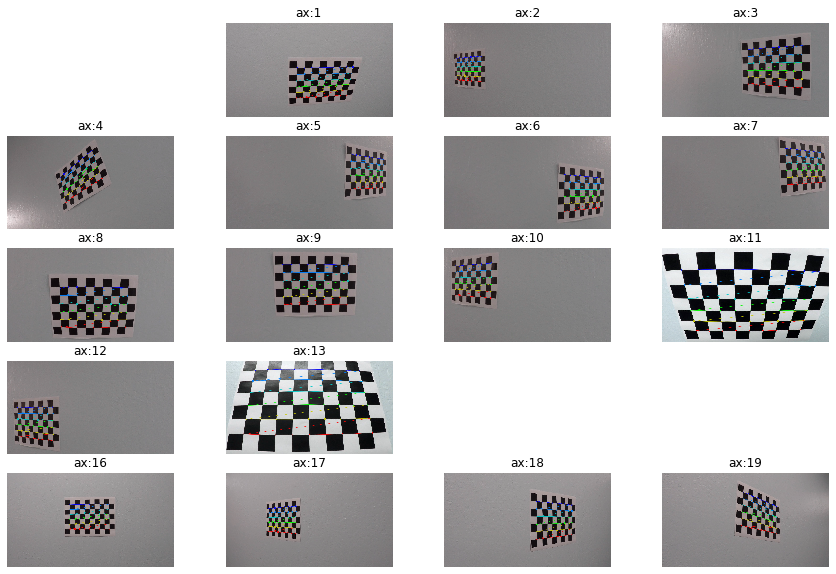

In [3]:
camera_cal_path = 'camera_cal/calibration*.jpg' #calibration images path
nx = 6 #chessboard rows
ny = 9 #chessboard cols

calibrate_camera(camera_cal_path, nx, ny)


* We have 20 images in 'camera_cal' folder but a few images do not have corners so we does not draw these images.

#### Now we are going to test the camera calibration with an  image 

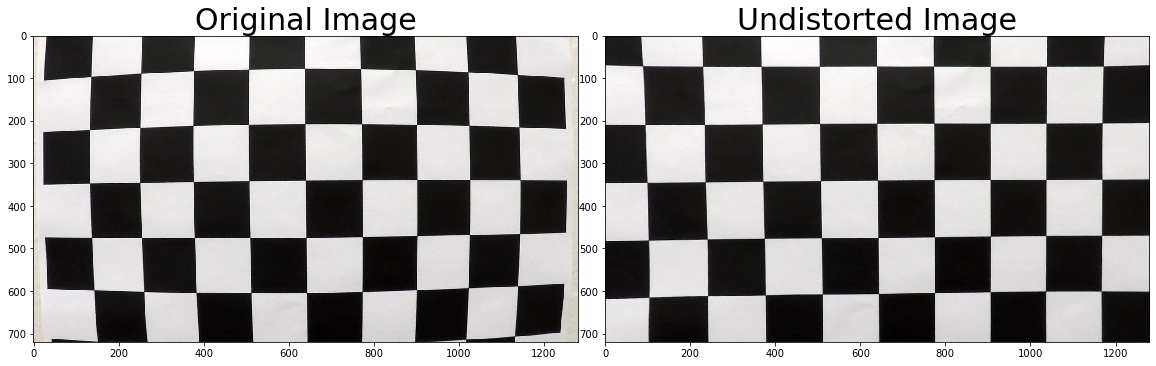

In [4]:
# Read objpoints and imgpoints in 'camera_cal/mtx_dist_pickle.p'
dist_pickle = pickle.load( open( "camera_cal/mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

image_name = 'calibration1.jpg'

# Test undistortion on an image
img = cv2.imread('camera_cal/'+image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Do camera calibration given object points and image points
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_chessboard.png')
plt.show()

* Save the undistorted image to the folder

Step 2 -  Fix The Distortion With OpenCV
===

* Prepare test images for Step-2 and fix the distortion

In [5]:
images = glob.glob('test_images/*.jpg')
# Visualize undistortion on test images

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = 'output_images/undistorted_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)

output_images/undistorted_straight_lines1.jpg
output_images/undistorted_straight_lines2.jpg
output_images/undistorted_test1.jpg
output_images/undistorted_test2.jpg
output_images/undistorted_test3.jpg
output_images/undistorted_test4.jpg
output_images/undistorted_test5.jpg
output_images/undistorted_test6.jpg


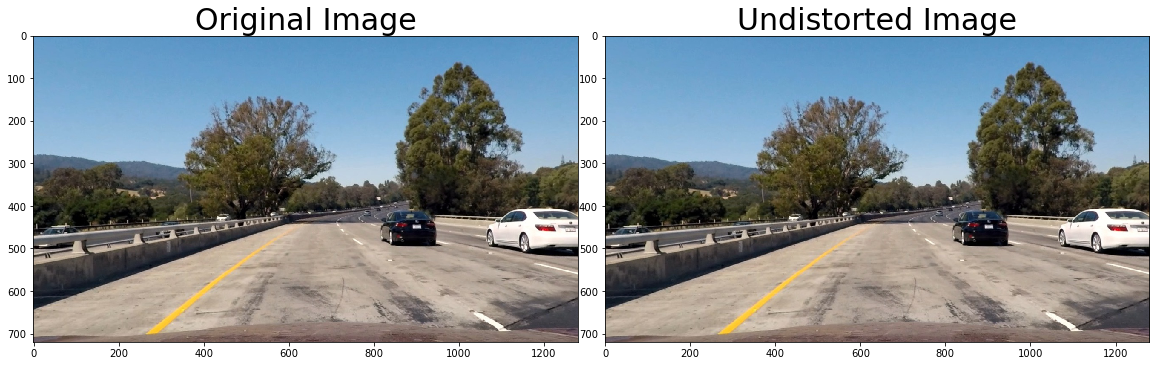

In [6]:
img = cv2.imread('output_images/undistorted_test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = cv2.imread('output_images/undistorted_test1.jpg')
undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_sample.png')
plt.show()

Step 3 - Gradients & Color Threshold
===

### Now we've got undistorted images.
* Convert image HLS color space and apply threshold to s channel.
* abs_sobel_thresh Apply Sobel Operator
* mag_thresh Apply Gradient Magnitude 
* dir_threshold Apply Direction of Gradient

In [7]:
# function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls_scale = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_scale[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


# function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(gray_scale_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        gradient_of_image = cv2.Sobel(gray_scale_img, cv2.CV_64F, 1, 0, sobel_kernel)
    else:
        gradient_of_image = cv2.Sobel(gray_scale_img, cv2.CV_64F, 0, 1, sobel_kernel)
        
    abs_of_gradient = np.absolute(gradient_of_image)
    scale_abs = np.uint8(255*abs_of_gradient/np.max(abs_of_gradient))
    binary_output = np.zeros_like(scale_abs)
    binary_output[(scale_abs>=thresh[0]) & (scale_abs<=thresh[1])] = 1
    return binary_output

# function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray_scale_img, sobel_kernel=3, mag_thresh=(0, 255)):
    grad_x = cv2.Sobel(gray_scale_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray_scale_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt(grad_x**2+grad_y**2)
    scaled_magnitude = np.uint8((255*magnitude)/np.max(magnitude))
    binary_output = np.zeros_like(magnitude)
    binary_output[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1 
    return binary_output

# function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray_scale_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    grad_x = cv2.Sobel(gray_scale_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray_scale_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    absolute_x = np.absolute(grad_x)
    absolute_y = np.absolute(grad_y)
    direction = np.arctan2(absolute_y,absolute_x)
    binary_output = np.zeros_like(gray_scale_img)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output


# function that generate warp and unwarp matrix, 
# M: convert to bird-eye, Minv: bird-eye to normal perspective.
def perpective_matrix():
    src = np.float32([(570,470),
                  (750,470),
                  (250,685),
                  (1125,685)
                  ])

    dst = np.float32([(250,0),
                  (950,0),
                  (250, 720),
                  (950,720)
                  ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

# function that convert normal perspective to bird-eye
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

# function that convert bird-eye to normal perspective
def unwarp(img, Minv):
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, Minv, img_size , flags=cv2.INTER_LINEAR)    
    return unwarped

### So far we calibrated our camera and corrected distorted images. Let's determine the color and gradient threshold and combine the output in  undistorted images under the 'output_images/' folder.

# Thresholds the S-channel of HLS

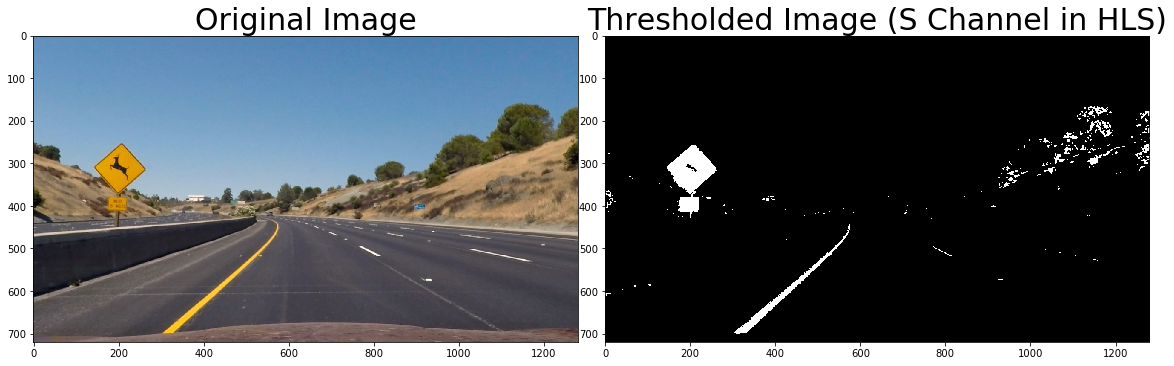

In [8]:
# Test undistortion on an image
img_name = 'undistorted_test2.jpg'
original_img = cv2.imread('output_images/'+img_name)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# binary threshold to s channel in hls color space
hls_image = hls_select(original_img, thresh=(125, 255))

#Save the image to the output_images folder but we multiply with 255 before saving the image.
hls_image_name = 'output_images/hls_'+img_name
cv2.imwrite(hls_image_name,hls_image*255)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_image,cmap='gray')
ax2.set_title('Thresholded Image (S Channel in HLS)', fontsize=30)
plt.savefig('output_images/hls_binary.png')
plt.show()

# Thresholds Sobel x

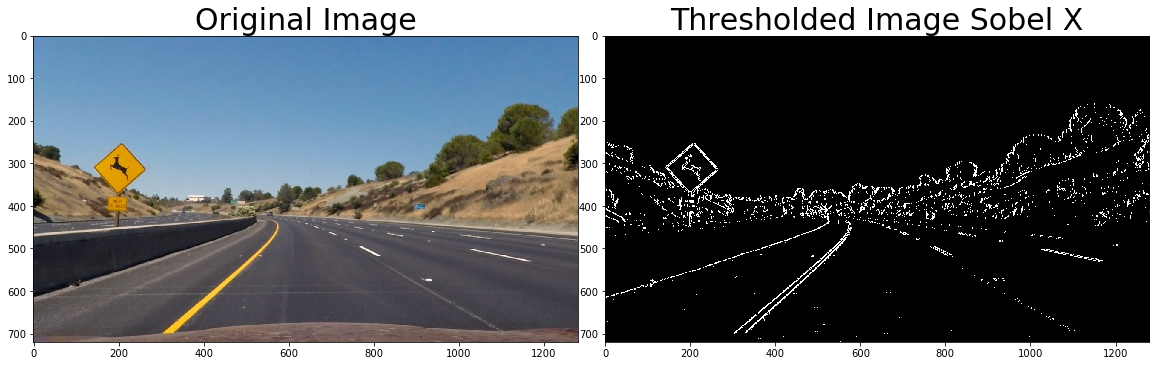

In [9]:
# Test undistortion on an image
img_name = 'undistorted_test2.jpg'
original_img = cv2.imread('output_images/'+img_name)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
gray_scale = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

# apply binary sobel operator threshold to original image
sobel_x = abs_sobel_thresh(gray_scale,thresh=(30,120))

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sobel_x,cmap='gray')
ax2.set_title('Thresholded Image Sobel X', fontsize=30)
plt.savefig('output_images/sobel_x.png')
plt.show()

# Magnitude of Gradient

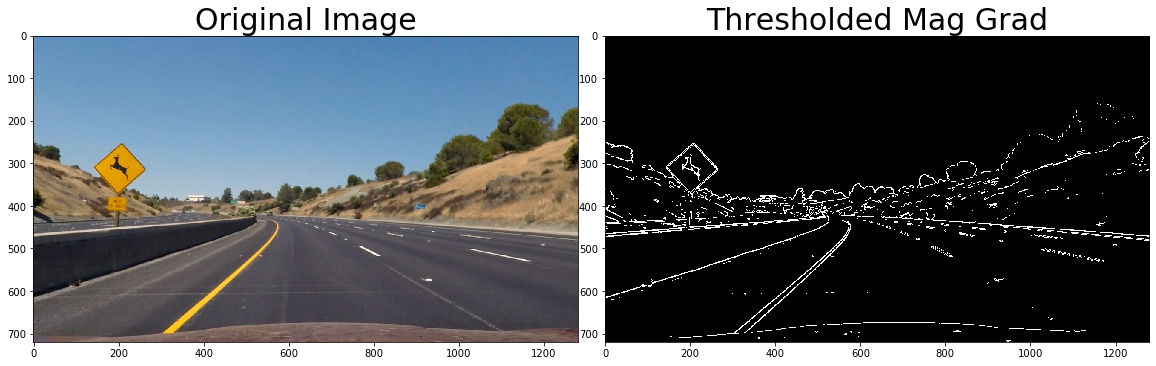

In [10]:
img_name = 'undistorted_test2.jpg'
original_img = cv2.imread('output_images/'+img_name)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
gray_scale = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

# apply binary magnitude gradient threshold to original image
mag_binary = mag_thresh(gray_scale, mag_thresh=(50, 150))

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary,cmap='gray')
ax2.set_title('Thresholded Mag Grad', fontsize=30)
plt.savefig('output_images/mag_binary.png')
plt.show()

# Direction of Gradient

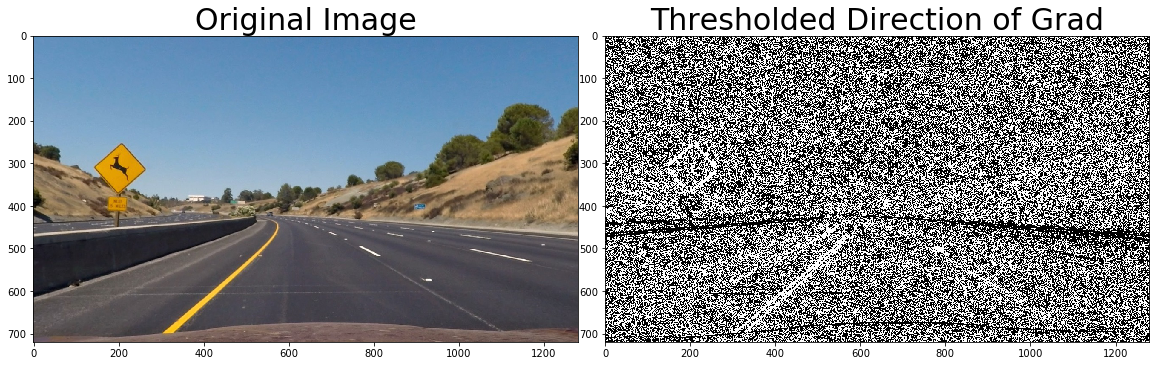

In [11]:
img_name = 'undistorted_test2.jpg'
original_img = cv2.imread('output_images/'+img_name)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
gray_scale = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

# apply direction of gradient threshold to original image
dir_binary = dir_threshold(gray_scale, thresh=(0.5, 1.3))

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary,cmap='gray')
ax2.set_title('Thresholded Direction of Grad', fontsize=30)
plt.savefig('output_images/dir_binary.png')
plt.show()

### Combine the Direction of Gradient - Sobel X - Magnitude of Grad & HLS - S Channel Threshold

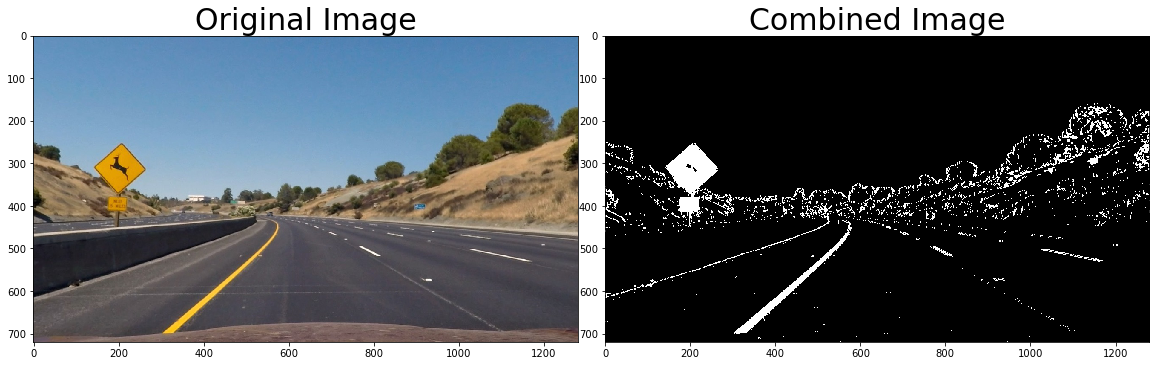

In [12]:
grad_binary = np.zeros_like(dir_binary)
grad_binary[(sobel_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Combine gradient and color thresholds
combined_binary = np.zeros_like(dir_binary)
combined_binary[(sobel_x == 1) | (hls_image == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('Combined Image', fontsize=30)
plt.savefig('output_images/combined_binary.png')
plt.show()

Step 4 - Apply a Perspective Transform
===

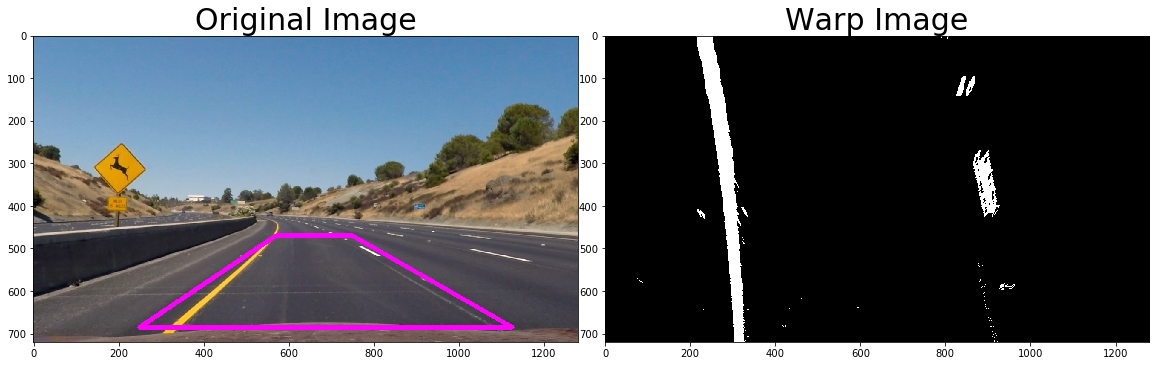

In [13]:
copy_image = np.copy(original_img)
combined_binary_copy = np.copy(combined_binary)

# get perspective matricies
M, Minv = perpective_matrix()

trapezoid_src = np.array([[[250,685], [570,470],[750,470],[1125,685]]], np.int32)
trapezoid_dst = np.array([[[250,720], [250,0],[950,0],[950,720]]], np.int32)

# draw src points
img_mod = cv2.polylines(copy_image, [trapezoid_src], True, (255,0,255),10)

exampleImg_warp = warp(combined_binary_copy, M)
#exampleImg_warp = cv2.polylines(exampleImg_warp, [trapezoid_dst], True, (255,0,255),10)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img_mod)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_warp, cmap='gray')
ax2.set_title('Warp Image', fontsize=30)
plt.savefig('output_images/warped_img.png')
plt.show()

Step 5 - Detect Lane Pixels & Fit To Find Lane Boundary
===

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin   # Update this
        win_xright_high = rightx_current + margin  # Update this
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, left_fitx, right_fit, right_fitx, ploty

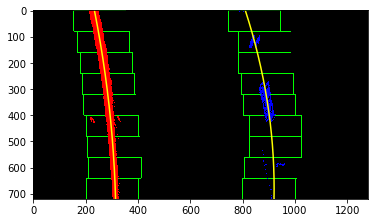

In [15]:
out_img, left_fit, left_fitx, right_fit, right_fitx, ploty = fit_polynomial(exampleImg_warp)

plt.imshow(out_img)
plt.savefig('output_images/sliding_window.png')
plt.show()

Step 6 - Determine The Curvature Of The Lane Line
===

In [16]:
def measure_curvature_real(leftx, rightx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    y_eval = y_eval*ym_per_pix 
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1]))** (3. / 2) )/abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1]))** (3. / 2) )/abs(2*right_fit_cr[0])   ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curve, right_curve = measure_curvature_real(left_fitx, right_fitx, ploty)

print(left_curve, 'm', right_curve, 'm')

1400.4651181280271 m 686.7240006766515 m


Step 7 - UnWarp Image & Display Numerical Estimation
===

In [17]:
def calculate_distance_to_the_center_of_lane(image_size, left_fit, right_fit):
   
    distance_to_the_center = None
    if left_fitx is not None and right_fitx is not None:
        width = image_size[0]
        height = image_size[1]
        print(left_fit)
        center_of_lane = width / 2
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        left_lane_x = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        right_lane_x = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
        estimated_lane_center = (left_lane_x + right_lane_x) /2
        distance_to_the_center = (center_of_lane - estimated_lane_center) * xm_per_pix
        return distance_to_the_center

In [18]:
def add_text(img, left_curve, right_curve, distance_to_the_center ):
    curve = (left_curve + right_curve) / 2
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curve) + 'm'
    cv2.putText(img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if distance_to_the_center > 0:
        direction = 'right'
    elif distance_to_the_center < 0:
        direction = 'left'
    abs_center_dist = abs(distance_to_the_center)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)

[-1.17876728e-04  1.96859646e-01  2.33232974e+02]


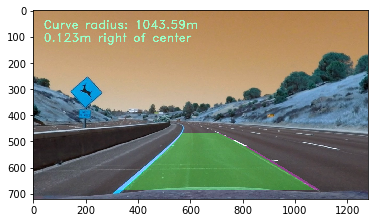

In [19]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(exampleImg_warp).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(220,0,220), thickness=15)
cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(220,0,220), thickness=15)

image_size = (original_img.shape[1], original_img.shape[0])

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, image_size) 

#Calculate vehicle position center of lane
distance = calculate_distance_to_the_center_of_lane(image_size, left_fit, right_fit)

add_text(original_img, left_curve, right_curve, distance)

img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
combines_lane_line_image_name = 'output_images/curved_image.jpg'
cv2.imwrite(combines_lane_line_image_name, result)

plt.imshow(result)


In [24]:
(original_img.shape[1], original_img.shape[0])

(1280, 720)

In [25]:
left_lane_x = left_fit[0]*690**2 + left_fit[1]*690 + left_fit[2]
right_lane_x = right_fit[0]*690**2 + right_fit[1]*690 + right_fit[2]
xm_per_pix = 3.7/700

print(str(left_lane_x) + ' ' + str(right_lane_x))
print((right_lane_x - left_lane_x)*xm_per_pix)

312.9450194555569 920.0438663143423
3.2089510476821514


In [26]:
left_lane_x = left_fit[0]*450**2 + left_fit[1]*450 + left_fit[2]
right_lane_x = right_fit[0]*450**2 + right_fit[1]*450 + right_fit[2]
xm_per_pix = 3.7/700

print(str(left_lane_x) + ' ' + str(right_lane_x))
print((right_lane_x - left_lane_x)*xm_per_pix)

297.94977731800293 907.5685604757389
3.2222707109766042


# Line() class to keep track of all the interesting parameters you measure from frame to frame.

In [27]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #last n fit counter
        self.fit_counter = 0
        self.lane_inds = []
    
    def reset(self):
        self.detected = False  
        self.best_fit = None  

    
    def sliding_windows_find_lanes_coeffs(self, binary_warped, is_left_line=True, blind_search=True):
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Set the width of the windows +/- margin
        margin = 90
        
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        if is_left_line:
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint
        
        if blind_search == True:# first search or blind search for finding polynomial coefficients 

            # Create an output image to draw on and visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))
            
            # HYPERPARAMETERS
            # Choose the number of sliding windows
            nwindows = 9
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Set height of windows - based on nwindows above and image shape
            window_height = np.int(binary_warped.shape[0]//nwindows)
            # Current positions to be updated later for each window in nwindows
            x_current = x_base

            # Create empty lists to receive left and right lane pixel indices
            lane_inds = []
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                ### TO-DO: Find the four below boundaries of the window ###
                win_x_low = x_current - margin  # Update this
                win_x_high = x_current + margin  # Update this

                ### Identify the nonzero pixels in x and y within the window ###
                good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

                # Append these indices to the lists
                lane_inds.append(good_inds)

                ### If you found > minpix pixels, recenter next window. (`right` or `leftx_current`) on their mean position
                if len(good_inds) > minpix:
                    current = np.int(np.mean(nonzerox[good_inds]))

            # Concatenate the arrays of indices (previously was a list of lists of pixels)
            try:
                lane_inds = np.concatenate(lane_inds)
            except ValueError:
                # Avoids an error if the above is not implemented fully
                pass
        else: #  calculate polynomial coefs using the previous best fit 
            lane_inds = ((nonzerox > (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] - margin)) & 
                          (nonzerox < (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] + margin))) 

        self.calculate_polynomial_coefs(nonzerox, nonzeroy, lane_inds)


    def calculate_polynomial_coefs(self, nonzerox, nonzeroy, lane_inds):
        # extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        fit = None
        if len(x) != 0:
            fit = np.polyfit(y, x, 2)
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                    self.best_fit = np.mean(self.current_fit, axis=0)
                else:
                     self.best_fit = self.current_fit[-1]                
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.best_fit = np.mean(self.current_fit, axis=0)
                
                
        self.fit_counter = self.fit_counter + 1
        self.lane_inds = lane_inds

In [28]:
def pipeline(img):
    #Step1 undistort image
    undistored_img = cv2.undistort(img, mtx, dist, None, mtx)
    copy_img = np.copy(undistored_img)
    
    gray_scale_img = cv2.cvtColor(undistored_img, cv2.COLOR_RGB2GRAY)

    #Step2
    # binary threshold to s channel in hls color space
    hls_image = hls_select(undistored_img, thresh=(125, 255))
    
    # apply binary sobel operator threshold to original image
    sobel_x = abs_sobel_thresh(gray_scale_img,thresh=(30,120))
    
    # apply binary magnitude gradient threshold to original image
    mag_binary = mag_thresh(gray_scale_img, mag_thresh=(50, 150))
    
    # apply direction of gradient threshold to original image
    dir_binary = dir_threshold(gray_scale_img, thresh=(0.5, 1.3))

    # Combine gradient and color thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(sobel_x == 1) | (hls_image == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    warp_img = warp(combined_binary, M)
    
    # sliding_windows_find_lanes_coeffs(binary_warped, is_left_line = True, blind_search=True)
    if not left_line.detected or not right_line.detected:
        left_line.sliding_windows_find_lanes_coeffs(warp_img, True, True)
        right_line.sliding_windows_find_lanes_coeffs(warp_img, False, True)
    else:
        left_line.sliding_windows_find_lanes_coeffs(warp_img, True, False)
        right_line.sliding_windows_find_lanes_coeffs(warp_img, False, False)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        height = img.shape[0]
        left_x = left_line.best_fit[0]*height**2 + left_line.best_fit[1]*height + left_line.best_fit[2]
        right_x = right_line.best_fit[0]*height**2 + right_line.best_fit[1]*height + right_line.best_fit[2]
        diff_x = abs(right_x-left_x)
        print(diff_x)
        if abs(700 - diff_x) > 100:
            left_line.reset()
            right_line.reset()
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        ploty = np.linspace(0, gray_scale_img.shape[0]-1, gray_scale_img.shape[0] )

        left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
        right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]

        warp_zero = np.zeros_like(warp_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(220,0,220), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(220,0,220), thickness=15)

        image_size = (original_img.shape[1], original_img.shape[0])

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, image_size) 
        
        left_curve, right_curve = measure_curvature_real(left_fitx, right_fitx, ploty)
        #Calculate vehicle position center of lane
        distance = calculate_distance_to_the_center_of_lane(image_size, left_line.best_fit, right_line.best_fit)

        add_text(undistored_img, left_curve, right_curve, distance)

            # Combine the result with the original image
        result = cv2.addWeighted(undistored_img, 1, newwarp, 0.3, 0)
    else:
        result = undistored_img
    return result


607.515940989361
[-1.18449239e-04  1.97483722e-01  2.33103517e+02]


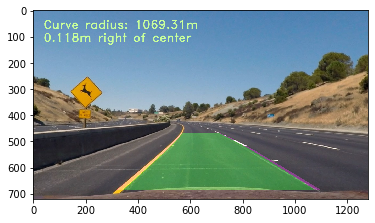

In [29]:
left_line = Line()
right_line= Line()
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result= pipeline(img)
cv2.imwrite('test2.jpg', result)
plt.imshow(result)


In [30]:
left_line = Line()
right_line= Line()

video_output3 = 'project_video_output.mp4'
video_input3 = VideoFileClip('project_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(pipeline)
%time processed_video.write_videofile(video_output3, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

657.8631896395045
[-1.13522013e-04  1.84704993e-01  2.33160121e+02]
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4

653.9878329346949

t:   0%|                                                                    | 2/1260 [00:00<01:53, 11.11it/s, now=None]


[-1.15662872e-04  1.88736848e-01  2.31637770e+02]
655.0617602021929


t:   0%|▏                                                                   | 3/1260 [00:00<02:25,  8.61it/s, now=None]

[-1.32162090e-04  2.00893971e-01  2.31428979e+02]
652.3677297061498
[-1.40080195e-04  2.07984212e-01  2.30559840e+02]


t:   0%|▎                                                                   | 6/1260 [00:00<03:11,  6.55it/s, now=None]

653.5123735793117
[-1.28103006e-04  1.98710088e-01  2.31385041e+02]
650.4787378235651
[-1.31588319e-04  2.03684836e-01  2.30610895e+02]


t:   1%|▍                                                                   | 7/1260 [00:01<03:16,  6.37it/s, now=None]

647.8080542565806
[-1.32989376e-04  2.07097634e-01  2.30255113e+02]
644.8555411504203
[-1.31769519e-04  2.09505539e-01  2.29421082e+02]

t:   1%|▍                                                                   | 9/1260 [00:01<03:24,  6.13it/s, now=None]


642.4022688516636
[-1.28334684e-04  2.10621289e-01  2.28766114e+02]


t:   1%|▌                                                                  | 10/1260 [00:01<03:26,  6.04it/s, now=None]

638.4244316111733
[-1.24573173e-04  2.11361312e-01  2.27597039e+02]
636.6474119539316
[-1.22978578e-04  2.13476568e-01  2.26003333e+02]

t:   1%|▋                                                                  | 12/1260 [00:01<03:31,  5.90it/s, now=None]


636.1757590655063
[-1.24156015e-04  2.17500039e-01  2.24015286e+02]


t:   1%|▋                                                                  | 13/1260 [00:02<03:33,  5.84it/s, now=None]

637.1086663356482
[-1.22751092e-04  2.20052051e-01  2.21281601e+02]
639.2896508069202


t:   1%|▋                                                                  | 14/1260 [00:02<03:33,  5.82it/s, now=None]

[-1.23652281e-04  2.24064479e-01  2.18183706e+02]
645.3296452504393
[-1.26628091e-04  2.29460942e-01  2.15222760e+02]


t:   1%|▉                                                                  | 17/1260 [00:02<03:35,  5.78it/s, now=None]

649.0066777858633
[-1.28743641e-04  2.33031190e-01  2.13297532e+02]
649.5039489469548
[-1.26753464e-04  2.33287329e-01  2.12016700e+02]


t:   2%|█                                                                  | 19/1260 [00:03<03:34,  5.79it/s, now=None]

647.172968344891
[-1.22253125e-04  2.30655738e-01  2.12169867e+02]
643.2418800526568
[-1.13594141e-04  2.24522004e-01  2.12887549e+02]


t:   2%|█                                                                  | 21/1260 [00:03<03:26,  6.01it/s, now=None]

637.9883272690046
[-1.01435632e-04  2.15714036e-01  2.13595684e+02]
633.8040808981157
[-8.79285433e-05  2.06887142e-01  2.13500082e+02]


t:   2%|█▏                                                                 | 22/1260 [00:03<03:27,  5.96it/s, now=None]

631.834011493285
[-7.36425550e-05  1.97655849e-01  2.12846027e+02]
630.6654452958838
[-6.31911139e-05  1.91157789e-01  2.11378249e+02]


t:   2%|█▎                                                                 | 25/1260 [00:04<03:29,  5.91it/s, now=None]

628.3770064467755
[-5.29570018e-05  1.84402923e-01  2.09621923e+02]
627.7695103755284
[-4.47216087e-05  1.77227048e-01  2.09008518e+02]


t:   2%|█▍                                                                 | 26/1260 [00:04<03:30,  5.87it/s, now=None]

628.4059664555472
[-4.30251908e-05  1.73554405e-01  2.08724338e+02]
629.9337749599903
[-4.45114674e-05  1.71778867e-01  2.08254567e+02]


t:   2%|█▍                                                                 | 28/1260 [00:04<03:28,  5.91it/s, now=None]

634.518414999165
[-4.85608183e-05  1.70953083e-01  2.08402791e+02]
641.701611142917
[-5.71229478e-05  1.73935885e-01  2.07934854e+02]


t:   2%|█▌                                                                 | 30/1260 [00:04<03:28,  5.89it/s, now=None]

646.6944141243797
[-6.53880767e-05  1.77604999e-01  2.07281777e+02]
650.2983519683911
[-7.10073920e-05  1.79108154e-01  2.07371384e+02]


t:   3%|█▋                                                                 | 32/1260 [00:05<03:30,  5.83it/s, now=None]

652.6864701110158
[-7.94855210e-05  1.82172979e-01  2.08418935e+02]
652.3062905441144
[-8.87603773e-05  1.85612848e-01  2.10195699e+02]


t:   3%|█▊                                                                 | 34/1260 [00:05<03:30,  5.82it/s, now=None]

650.8375124638412
[-9.51970510e-05  1.87139252e-01  2.12408432e+02]
648.6235207811527
[-1.02999963e-04  1.90117468e-01  2.14411272e+02]


t:   3%|█▉                                                                 | 36/1260 [00:05<03:30,  5.82it/s, now=None]

644.763491773658
[-1.07699620e-04  1.91751500e-01  2.16137038e+02]
642.9563382534766
[-1.12595562e-04  1.94487115e-01  2.17357709e+02]


t:   3%|██                                                                 | 38/1260 [00:06<03:31,  5.78it/s, now=None]

641.7864060234721
[-1.15407411e-04  1.96505100e-01  2.18034434e+02]
641.6786087562268
[-1.22197840e-04  2.01670319e-01  2.18816046e+02]

t:   3%|██▏                                                                | 40/1260 [00:06<03:33,  5.71it/s, now=None]


642.696514112921
[-1.30139626e-04  2.07828772e-01  2.19345367e+02]


t:   3%|██▏                                                                | 41/1260 [00:06<03:33,  5.71it/s, now=None]

645.3476637377158
[-1.41291084e-04  2.17122848e-01  2.18883676e+02]
646.154531800591
[-1.50736581e-04  2.25416667e-01  2.18144747e+02]


t:   3%|██▎                                                                | 43/1260 [00:07<03:30,  5.77it/s, now=None]

645.7040529885251
[-1.57479422e-04  2.33094998e-01  2.16945039e+02]
644.1233359608444
[-1.60769652e-04  2.38661517e-01  2.15520080e+02]


t:   4%|██▍                                                                | 45/1260 [00:07<03:27,  5.85it/s, now=None]

642.658600080373
[-1.61230909e-04  2.42908664e-01  2.13512322e+02]
641.7818948558825
[-1.59264300e-04  2.45444465e-01  2.11622085e+02]


t:   4%|██▍                                                                | 47/1260 [00:07<03:28,  5.80it/s, now=None]

640.0614300263678
[-1.56740951e-04  2.47645491e-01  2.09526272e+02]
638.2877084171236
[-1.55202235e-04  2.49976635e-01  2.07196929e+02]


t:   4%|██▌                                                                | 49/1260 [00:08<03:30,  5.75it/s, now=None]

636.0693899150323
[-1.53390759e-04  2.51576915e-01  2.05191174e+02]
635.2663564251312
[-1.50977689e-04  2.52812071e-01  2.03033959e+02]


t:   4%|██▋                                                                | 51/1260 [00:08<03:26,  5.85it/s, now=None]

634.8096813933637
[-1.50780591e-04  2.55790387e-01  2.00730496e+02]
636.0623466632251
[-1.49498993e-04  2.57935768e-01  1.98587045e+02]


t:   4%|██▊                                                                | 53/1260 [00:08<03:28,  5.78it/s, now=None]

639.441391040769
[-1.49408562e-04  2.60407360e-01  1.97019211e+02]
642.0388797632606

t:   4%|██▊                                                                | 54/1260 [00:09<03:35,  5.60it/s, now=None]


[-1.46779188e-04  2.60551414e-01  1.95801562e+02]
642.3321097993918


t:   4%|██▉                                                                | 55/1260 [00:09<03:38,  5.52it/s, now=None]

[-1.44007706e-04  2.60031993e-01  1.95141521e+02]
641.4239171065892
[-1.33786999e-04  2.53952199e-01  1.95037284e+02]


t:   5%|███                                                                | 57/1260 [00:09<03:32,  5.65it/s, now=None]

639.8068392976138
[-1.20070991e-04  2.44691707e-01  1.95394213e+02]


t:   5%|███                                                                | 58/1260 [00:09<03:54,  5.12it/s, now=None]

637.2157258768884
[-1.04600927e-04  2.33699883e-01  1.95928189e+02]


t:   5%|███▏                                                               | 59/1260 [00:10<03:53,  5.14it/s, now=None]

635.8836061881917
[-9.00953576e-05  2.23202474e-01  1.96315065e+02]
630.8931682349839

t:   5%|███▏                                                               | 60/1260 [00:10<03:53,  5.14it/s, now=None]


[-7.45421592e-05  2.10129771e-01  1.98023837e+02]


t:   5%|███▏                                                               | 61/1260 [00:10<03:57,  5.04it/s, now=None]

627.8951583177234
[-6.23746752e-05  1.97372155e-01  2.00801116e+02]
626.3383402540899


t:   5%|███▎                                                               | 62/1260 [00:10<03:56,  5.06it/s, now=None]

[-5.53211819e-05  1.87418351e-01  2.03697030e+02]
625.8640880172986
[-5.16682830e-05  1.79240336e-01  2.06810402e+02]


t:   5%|███▍                                                               | 64/1260 [00:11<03:42,  5.38it/s, now=None]

627.6907940136065
[-5.17721516e-05  1.73768860e-01  2.09515482e+02]
633.4832938209488
[-5.74528964e-05  1.72810021e-01  2.11347272e+02]

t:   5%|███▌                                                               | 66/1260 [00:11<03:37,  5.49it/s, now=None]


637.6430425428166
[-6.69637198e-05  1.75846931e-01  2.11743456e+02]


t:   5%|███▌                                                               | 67/1260 [00:11<03:37,  5.48it/s, now=None]

639.9543084289173
[-8.00914427e-05  1.82081707e-01  2.11776292e+02]
640.9814438471269
[-9.24828509e-05  1.88710410e-01  2.11219706e+02]

t:   5%|███▋                                                               | 69/1260 [00:11<03:33,  5.57it/s, now=None]


639.976637381661
[-1.02249454e-04  1.94211468e-01  2.10476337e+02]


t:   6%|███▊                                                               | 71/1260 [00:12<03:28,  5.69it/s, now=None]

639.1789833458048
[-1.12441502e-04  2.00576204e-01  2.09541539e+02]
638.8363027245316
[-1.21661517e-04  2.07024278e-01  2.08292412e+02]


t:   6%|███▊                                                               | 72/1260 [00:12<03:27,  5.72it/s, now=None]

633.9980481892774
[-1.26751746e-04  2.11293707e-01  2.06938440e+02]
630.282529987307
[-1.30557991e-04  2.15339180e-01  2.05168563e+02]

t:   6%|███▉                                                               | 74/1260 [00:12<03:26,  5.74it/s, now=None]


628.5324238560348
[-1.32011162e-04  2.17587446e-01  2.03787768e+02]


t:   6%|███▉                                                               | 75/1260 [00:12<03:23,  5.82it/s, now=None]

626.4400405180144
[-1.26394100e-04  2.15220072e-01  2.02469064e+02]
624.8530149903648
[-1.18862879e-04  2.11765717e-01  2.01117989e+02]


t:   6%|████                                                               | 77/1260 [00:13<03:20,  5.89it/s, now=None]

628.5333030599522
[-1.09460903e-04  2.06618890e-01  2.00101333e+02]
631.7678762356552

t:   6%|████▏                                                              | 78/1260 [00:13<03:22,  5.83it/s, now=None]


[-9.73572527e-05  1.99613296e-01  1.98801991e+02]
633.4377718158153
[-8.60688207e-05  1.93201668e-01  1.97284815e+02]


t:   6%|████▎                                                              | 80/1260 [00:13<03:22,  5.83it/s, now=None]

635.6272379641086
[-7.69332243e-05  1.88138520e-01  1.95312345e+02]
636.8602465277477
[-6.60654136e-05  1.80801388e-01  1.94336678e+02]

t:   7%|████▎                                                              | 82/1260 [00:14<03:24,  5.76it/s, now=None]


637.1617289025031
[-5.42293846e-05  1.71763455e-01  1.93761346e+02]


t:   7%|████▍                                                              | 83/1260 [00:14<03:18,  5.92it/s, now=None]

637.4362377475254
[-4.33437684e-05  1.62109908e-01  1.94055292e+02]
637.8705013534224
[-3.61343973e-05  1.54164376e-01  1.94628457e+02]

t:   7%|████▌                                                              | 85/1260 [00:14<03:23,  5.79it/s, now=None]


638.9241645900511
[-2.77021578e-05  1.45816711e-01  1.94745053e+02]


t:   7%|████▌                                                              | 86/1260 [00:14<03:19,  5.89it/s, now=None]

640.0560871210407
[-2.24468966e-05  1.38893257e-01  1.95010713e+02]
640.6910654953082


t:   7%|████▋                                                              | 87/1260 [00:15<03:22,  5.80it/s, now=None]

[-2.11344925e-05  1.34617583e-01  1.95196145e+02]
642.1607898154617
[-2.48152244e-05  1.32099602e-01  1.97070273e+02]


t:   7%|████▋                                                              | 89/1260 [00:15<03:24,  5.74it/s, now=None]

644.4903442835706
[-3.13144063e-05  1.30916177e-01  1.99769131e+02]
647.3267468550999
[-4.33080031e-05  1.32319396e-01  2.03892098e+02]

t:   7%|████▊                                                              | 90/1260 [00:15<03:23,  5.76it/s, now=None]


648.8221196491652
[-5.80187340e-05  1.36175948e-01  2.08451595e+02]


t:   7%|████▉                                                              | 93/1260 [00:16<03:26,  5.65it/s, now=None]

651.7762112524265
[-7.35360061e-05  1.41767311e-01  2.12198718e+02]
652.2584937155591
[-8.62196934e-05  1.48260037e-01  2.14105352e+02]


t:   7%|████▉                                                              | 94/1260 [00:16<03:27,  5.63it/s, now=None]

650.3497689105355
[-9.44372490e-05  1.52803376e-01  2.15744138e+02]
647.0874079988483
[-1.02864978e-04  1.58682920e-01  2.16753074e+02]

t:   8%|█████                                                              | 95/1260 [00:16<03:26,  5.63it/s, now=None]


645.14631854776
[-1.07583990e-04  1.63075393e-01  2.16472684e+02]


t:   8%|█████▏                                                             | 98/1260 [00:16<03:22,  5.73it/s, now=None]

640.2643192643282
[-1.11796029e-04  1.67662520e-01  2.16167803e+02]
635.1808528993788
[-1.15439001e-04  1.71788270e-01  2.15979311e+02]


t:   8%|█████▎                                                             | 99/1260 [00:17<03:22,  5.73it/s, now=None]

631.3498417841935
[-1.17110741e-04  1.75094908e-01  2.15027433e+02]
628.4809560875285
[-1.16000811e-04  1.76471604e-01  2.14210979e+02]


t:   8%|█████▎                                                            | 101/1260 [00:17<03:19,  5.82it/s, now=None]

626.0257527782389
[-1.15221785e-04  1.77781204e-01  2.13647295e+02]
626.6158252941676
[-1.12462206e-04  1.77195817e-01  2.13656205e+02]


t:   8%|█████▍                                                            | 103/1260 [00:17<03:20,  5.77it/s, now=None]

628.2613523528112
[-1.09476780e-04  1.75780375e-01  2.14100666e+02]
629.8720590911178
[-1.08598053e-04  1.75527467e-01  2.14815279e+02]

t:   8%|█████▌                                                            | 105/1260 [00:18<03:22,  5.70it/s, now=None]


630.606908909069
[-1.07695751e-04  1.75272717e-01  2.15426478e+02]


t:   8%|█████▌                                                            | 106/1260 [00:18<03:22,  5.69it/s, now=None]

631.5186183198035
[-1.03802596e-04  1.73462609e-01  2.15769780e+02]
632.0534062079963
[-9.99531641e-05  1.71925750e-01  2.15801833e+02]

t:   9%|█████▋                                                            | 108/1260 [00:18<03:22,  5.68it/s, now=None]


633.5286628062937
[-9.76358627e-05  1.71944027e-01  2.15154788e+02]


t:   9%|█████▋                                                            | 109/1260 [00:18<03:24,  5.63it/s, now=None]

634.2918840267423
[-9.51007443e-05  1.71066948e-01  2.15338211e+02]
636.0226161417811
[-9.17344029e-05  1.69217754e-01  2.15651458e+02]


t:   9%|█████▊                                                            | 111/1260 [00:19<03:25,  5.59it/s, now=None]

635.4148164743357
[-9.17842137e-05  1.68659790e-01  2.16612139e+02]
634.8063587829562

t:   9%|█████▊                                                            | 112/1260 [00:19<03:27,  5.54it/s, now=None]


[-9.37418316e-05  1.69205781e-01  2.17742743e+02]
634.7705928583439

t:   9%|█████▉                                                            | 113/1260 [00:19<03:28,  5.50it/s, now=None]


[-9.47907603e-05  1.69506801e-01  2.18430730e+02]
635.2353350450716


t:   9%|██████                                                            | 115/1260 [00:19<03:26,  5.54it/s, now=None]

[-9.83857928e-05  1.71612421e-01  2.18867612e+02]
636.2030044196656
[-1.03834996e-04  1.75194078e-01  2.19246897e+02]


t:   9%|██████                                                            | 116/1260 [00:20<03:27,  5.53it/s, now=None]

639.5560602559192
[-1.11576123e-04  1.80348502e-01  2.19845836e+02]
641.664771107083

t:   9%|██████▏                                                           | 117/1260 [00:20<03:26,  5.53it/s, now=None]


[-1.18282652e-04  1.84790429e-01  2.20453101e+02]
642.4625727720652
[-1.23959275e-04  1.88428691e-01  2.21575230e+02]


t:   9%|██████▏                                                           | 119/1260 [00:20<03:25,  5.55it/s, now=None]

641.7528323595966
[-1.27218960e-04  1.91564159e-01  2.22081906e+02]
639.6655508665385
[-1.26966242e-04  1.92424064e-01  2.22625525e+02]

t:  10%|██████▎                                                           | 120/1260 [00:20<03:23,  5.59it/s, now=None]


636.8126140236504
[-1.26532385e-04  1.93535527e-01  2.23052497e+02]


t:  10%|██████▍                                                           | 122/1260 [00:21<03:23,  5.59it/s, now=None]

634.8422502536721
[-1.24281817e-04  1.93878527e-01  2.23149457e+02]
630.0968609734261
[-1.24811755e-04  1.95873563e-01  2.23429348e+02]

t:  10%|██████▍                                                           | 124/1260 [00:21<03:18,  5.72it/s, now=None]


628.1051862808256
[-1.26328022e-04  1.98007843e-01  2.23983579e+02]


t:  10%|██████▌                                                           | 125/1260 [00:21<03:17,  5.75it/s, now=None]

626.6185237914408
[-1.28855219e-04  2.00572665e-01  2.24575742e+02]
625.942746884835
[-1.30376981e-04  2.02589426e-01  2.24882948e+02]


t:  10%|██████▋                                                           | 127/1260 [00:22<03:17,  5.75it/s, now=None]

627.6572867060473
[-1.32424058e-04  2.05465756e-01  2.24677329e+02]
632.3099097741887
[-1.33915639e-04  2.07814572e-01  2.24502147e+02]


t:  10%|██████▊                                                           | 130/1260 [00:22<03:14,  5.81it/s, now=None]

635.1400047544902
[-1.35852997e-04  2.11129546e-01  2.23573602e+02]
636.2819211797496
[-1.39641396e-04  2.15794858e-01  2.22881040e+02]


t:  10%|██████▊                                                           | 131/1260 [00:22<03:13,  5.82it/s, now=None]

636.2062371818297
[-1.38315993e-04  2.17528290e-01  2.21969817e+02]
634.5229867183208
[-1.40738346e-04  2.21089396e-01  2.21592411e+02]

t:  10%|██████▉                                                           | 132/1260 [00:22<03:15,  5.76it/s, now=None]


632.0704714679146
[-1.38588782e-04  2.21175220e-01  2.21795477e+02]


t:  11%|███████                                                           | 134/1260 [00:23<03:17,  5.69it/s, now=None]

629.8898553849963
[-1.34094804e-04  2.19239298e-01  2.22385601e+02]
624.9155741656489

t:  11%|███████                                                           | 135/1260 [00:23<03:21,  5.58it/s, now=None]


[-1.28347444e-04  2.16774551e-01  2.22624649e+02]
620.7964355490697

t:  11%|███████                                                           | 136/1260 [00:23<03:21,  5.58it/s, now=None]


[-1.25517510e-04  2.15570965e-01  2.23147741e+02]
618.9393990972832
[-1.18711305e-04  2.11425892e-01  2.23818477e+02]

t:  11%|███████▏                                                          | 138/1260 [00:24<03:17,  5.67it/s, now=None]


618.63350729657
[-1.14429670e-04  2.09322690e-01  2.23685401e+02]


t:  11%|███████▎                                                          | 139/1260 [00:24<03:16,  5.70it/s, now=None]

619.600189557355
[-1.10836512e-04  2.07309465e-01  2.23354467e+02]
626.5422149448186
[-1.07629173e-04  2.04943487e-01  2.22898552e+02]


t:  11%|███████▍                                                          | 142/1260 [00:24<03:09,  5.89it/s, now=None]

633.8565792874408
[-1.03792988e-04  2.02316353e-01  2.21867779e+02]
638.4962200166908
[-1.02163103e-04  2.00723655e-01  2.20942905e+02]


t:  11%|███████▌                                                          | 144/1260 [00:25<03:06,  5.97it/s, now=None]

641.830179841644
[-1.00432520e-04  1.98580318e-01  2.20318842e+02]
642.9857339347643
[-9.98996730e-05  1.97170523e-01  2.20334865e+02]


t:  12%|███████▋                                                          | 146/1260 [00:25<03:06,  5.98it/s, now=None]

642.2665832235009
[-1.00327020e-04  1.96392176e-01  2.20389156e+02]
641.2667898515017
[-1.02115292e-04  1.96156626e-01  2.20875543e+02]


t:  12%|███████▋                                                          | 147/1260 [00:25<03:04,  6.04it/s, now=None]

639.7632168015346
[-1.03580645e-04  1.95861052e-01  2.21586356e+02]
637.4446331094279
[-1.04474130e-04  1.95389797e-01  2.22308230e+02]


t:  12%|███████▊                                                          | 150/1260 [00:26<02:59,  6.18it/s, now=None]

636.5323397619277
[-1.05686804e-04  1.94283342e-01  2.23830556e+02]
635.4923932736482
[-1.04111308e-04  1.91136871e-01  2.25746084e+02]


t:  12%|███████▉                                                          | 152/1260 [00:26<03:01,  6.11it/s, now=None]

634.5399888143213
[-1.00018600e-04  1.86510091e-01  2.27544435e+02]
635.4653995994385
[-9.57966264e-05  1.82563932e-01  2.28537321e+02]


t:  12%|████████                                                          | 153/1260 [00:26<03:02,  6.06it/s, now=None]

638.3263331125559
[-9.25865529e-05  1.79599233e-01  2.29032064e+02]
639.2166715271458
[-8.91349486e-05  1.76995168e-01  2.28710820e+02]


t:  12%|████████▏                                                         | 156/1260 [00:27<03:04,  5.99it/s, now=None]

640.666378062065
[-8.58696414e-05  1.75525208e-01  2.27316295e+02]
641.113154049433
[-8.26483032e-05  1.74685041e-01  2.25638795e+02]


t:  13%|████████▎                                                         | 158/1260 [00:27<03:05,  5.93it/s, now=None]

639.79625693948
[-7.75349919e-05  1.71842515e-01  2.24427260e+02]
638.084402887143
[-7.45239301e-05  1.70379189e-01  2.23271674e+02]


t:  13%|████████▍                                                         | 160/1260 [00:27<03:00,  6.08it/s, now=None]

637.3430606973968
[-7.17438998e-05  1.68905181e-01  2.22087934e+02]
633.1321803544027
[-7.15139074e-05  1.68949111e-01  2.20851905e+02]


t:  13%|████████▍                                                         | 162/1260 [00:28<03:01,  6.04it/s, now=None]

631.6330766115618
[-7.71434423e-05  1.72277360e-01  2.19827271e+02]
631.7370378828837
[-8.53587781e-05  1.78214722e-01  2.17988473e+02]


t:  13%|████████▌                                                         | 163/1260 [00:28<03:03,  5.99it/s, now=None]

632.9821151981803
[-9.29736546e-05  1.84115281e-01  2.15899625e+02]
635.7152876433115
[-9.96162532e-05  1.90291165e-01  2.12990370e+02]


t:  13%|████████▋                                                         | 165/1260 [00:28<03:05,  5.91it/s, now=None]

644.2245929718266
[-1.06760308e-04  1.96617959e-01  2.10783900e+02]
649.0525413640828
[-1.11603906e-04  2.01320361e-01  2.09130345e+02]


t:  13%|████████▋                                                         | 167/1260 [00:28<03:01,  6.02it/s, now=None]

652.067315465403
[-1.13705312e-04  2.03881312e-01  2.07898184e+02]
651.9202693365962


t:  13%|████████▊                                                         | 169/1260 [00:29<03:04,  5.90it/s, now=None]

[-1.15062393e-04  2.05593039e-01  2.07532471e+02]
651.2552784747519
[-1.15196441e-04  2.07263809e-01  2.06684927e+02]


t:  14%|████████▉                                                         | 171/1260 [00:29<03:04,  5.89it/s, now=None]

648.043245390323
[-1.14081203e-04  2.08594616e-01  2.05179170e+02]
646.6937445031778
[-1.10780689e-04  2.09137564e-01  2.02551987e+02]


t:  14%|█████████                                                         | 172/1260 [00:29<03:06,  5.85it/s, now=None]

645.2243628971332
[-1.09170317e-04  2.10710257e-01  1.99981302e+02]
642.8925398984704


t:  14%|█████████                                                         | 174/1260 [00:30<03:04,  5.89it/s, now=None]

[-1.07474382e-04  2.12352682e-01  1.96797822e+02]
639.4258229387558
[-1.04773779e-04  2.11457547e-01  1.95006071e+02]


t:  14%|█████████▏                                                        | 175/1260 [00:30<03:06,  5.82it/s, now=None]

635.901677586363
[-1.00758006e-04  2.08309018e-01  1.94545290e+02]
632.697942535839
[-9.65825618e-05  2.03759672e-01  1.95333351e+02]

t:  14%|█████████▎                                                        | 177/1260 [00:30<03:05,  5.85it/s, now=None]


631.3914052695866
[-9.01999311e-05  1.96763317e-01  1.96820961e+02]


t:  14%|█████████▎                                                        | 178/1260 [00:30<03:04,  5.88it/s, now=None]

633.0183213569279
[-8.23309800e-05  1.88999607e-01  1.97913741e+02]
635.6863423091468
[-7.54090259e-05  1.82470925e-01  1.98645841e+02]


t:  14%|█████████▍                                                        | 180/1260 [00:31<03:03,  5.88it/s, now=None]

638.5311366484273
[-6.79398375e-05  1.75978743e-01  1.98958312e+02]
641.0126150432017
[-6.05069027e-05  1.69713903e-01  1.99033489e+02]


t:  14%|█████████▌                                                        | 182/1260 [00:31<03:08,  5.72it/s, now=None]

642.8798121419019
[-5.81787466e-05  1.66323647e-01  1.99527088e+02]
645.1604392856325

t:  15%|█████████▋                                                        | 184/1260 [00:31<03:04,  5.82it/s, now=None]


[-5.66462165e-05  1.62532557e-01  2.00678784e+02]
647.2477051447343
[-5.95763314e-05  1.60950607e-01  2.02354599e+02]


t:  15%|█████████▋                                                        | 185/1260 [00:31<03:03,  5.86it/s, now=None]

646.566727201371
[-6.93527635e-05  1.63705332e-01  2.04123585e+02]
648.1023190448182
[-8.49553725e-05  1.70170341e-01  2.06075822e+02]


t:  15%|█████████▊                                                        | 188/1260 [00:32<03:01,  5.92it/s, now=None]

650.2234574948345
[-1.03370226e-04  1.79013611e-01  2.08167156e+02]
652.1872853846527
[-1.24867983e-04  1.90852020e-01  2.10128621e+02]


t:  15%|█████████▉                                                        | 189/1260 [00:32<02:58,  5.99it/s, now=None]

655.6618252975454
[-1.46629548e-04  2.04407215e-01  2.11571548e+02]
659.7909383793537


t:  15%|██████████                                                        | 191/1260 [00:32<02:55,  6.08it/s, now=None]

[-1.63666280e-04  2.16093458e-01  2.12546836e+02]
659.9493015293697
[-1.77389510e-04  2.26870617e-01  2.13124269e+02]


t:  15%|██████████                                                        | 193/1260 [00:33<02:57,  6.03it/s, now=None]

658.1256231112009
[-1.84508372e-04  2.34632246e-01  2.13153448e+02]
654.949558480987
[-1.83058359e-04  2.37261165e-01  2.13292777e+02]


t:  15%|██████████▏                                                       | 194/1260 [00:33<02:58,  5.98it/s, now=None]

649.3054973650549
[-1.79327053e-04  2.38638054e-01  2.13458006e+02]
644.5032465024467
[-1.71819285e-04  2.36982808e-01  2.13984484e+02]


t:  16%|██████████▎                                                       | 196/1260 [00:33<02:59,  5.94it/s, now=None]

640.7528369433967
[-1.61902893e-04  2.33265973e-01  2.14502963e+02]
634.9723497572675
[-1.49982947e-04  2.28952624e-01  2.13223984e+02]

t:  16%|██████████▎                                                       | 198/1260 [00:34<03:03,  5.78it/s, now=None]


632.5804580364041
[-1.42120176e-04  2.27135765e-01  2.10761045e+02]


t:  16%|██████████▍                                                       | 199/1260 [00:34<03:05,  5.71it/s, now=None]

632.4419082660588
[-1.31776646e-04  2.23928066e-01  2.06747839e+02]
634.9747342214624
[-1.25397775e-04  2.24553576e-01  2.00916343e+02]


t:  16%|██████████▌                                                       | 202/1260 [00:34<03:00,  5.87it/s, now=None]

639.271830714863
[-1.19522570e-04  2.24980409e-01  1.95210426e+02]
646.4020801503586
[-1.15066061e-04  2.24809836e-01  1.90625969e+02]


t:  16%|██████████▋                                                       | 204/1260 [00:35<02:53,  6.07it/s, now=None]

652.3051501045231
[-1.13655604e-04  2.25066498e-01  1.87711323e+02]
656.3488842498081
[-1.14252613e-04  2.24879429e-01  1.86619458e+02]


t:  16%|██████████▊                                                       | 206/1260 [00:35<02:55,  6.02it/s, now=None]

657.9886634119766
[-1.12042868e-04  2.21700144e-01  1.87023865e+02]
657.2829879682788
[-1.08818407e-04  2.16884899e-01  1.88458519e+02]


t:  16%|██████████▊                                                       | 207/1260 [00:35<02:58,  5.89it/s, now=None]

656.2466201644154
[-1.04744020e-04  2.11257375e-01  1.90706922e+02]
652.9829364817325


t:  17%|██████████▉                                                       | 208/1260 [00:35<02:59,  5.85it/s, now=None]

[-1.00919519e-04  2.05481083e-01  1.93709931e+02]
646.034816275376
[-9.79618121e-05  2.00600342e-01  1.96780475e+02]


t:  17%|███████████                                                       | 211/1260 [00:36<02:54,  6.03it/s, now=None]

640.2425992973474
[-9.55569748e-05  1.95946484e-01  1.99798475e+02]
637.7625397918915
[-9.60642952e-05  1.95058572e-01  2.01116039e+02]


t:  17%|███████████▏                                                      | 213/1260 [00:36<02:57,  5.90it/s, now=None]

636.4885592830575
[-9.86097123e-05  1.96789320e-01  2.01013329e+02]
637.291885691528
[-1.03553067e-04  2.01057707e-01  1.99784619e+02]


t:  17%|███████████▏                                                      | 214/1260 [00:36<02:56,  5.91it/s, now=None]

642.764167152427
[-1.09431874e-04  2.06557762e-01  1.97727580e+02]
648.4453718140012

t:  17%|███████████▎                                                      | 216/1260 [00:37<02:56,  5.92it/s, now=None]


[-1.19721829e-04  2.14962907e-01  1.95646866e+02]
651.9371675114614
[-1.30878893e-04  2.23704093e-01  1.93797860e+02]


t:  17%|███████████▎                                                      | 217/1260 [00:37<02:58,  5.85it/s, now=None]

654.0088654755796
[-1.41810389e-04  2.32006485e-01  1.92530447e+02]
653.749639270443
[-1.49188660e-04  2.38262354e-01  1.91112698e+02]


t:  17%|███████████▍                                                      | 219/1260 [00:37<02:53,  6.00it/s, now=None]

653.0438817538496
[-1.52590672e-04  2.42482601e-01  1.89311345e+02]
650.851841075204
[-1.53040562e-04  2.44648577e-01  1.87977802e+02]


t:  18%|███████████▌                                                      | 221/1260 [00:38<02:51,  6.04it/s, now=None]

648.5219795872338
[-1.47858195e-04  2.43659629e-01  1.86204066e+02]
646.8281591498202
[-1.43147059e-04  2.43162465e-01  1.84412240e+02]


t:  18%|███████████▋                                                      | 224/1260 [00:38<02:56,  5.86it/s, now=None]

643.7412868599301
[-1.36795727e-04  2.41392448e-01  1.82708540e+02]
641.257682146615
[-1.29401228e-04  2.38321521e-01  1.81619422e+02]


t:  18%|███████████▊                                                      | 225/1260 [00:38<02:58,  5.80it/s, now=None]

640.2266327048042
[-1.24331745e-04  2.36243167e-01  1.80828638e+02]
640.8633570964186
[-1.23432425e-04  2.36127398e-01  1.80486251e+02]


t:  18%|███████████▉                                                      | 228/1260 [00:39<02:53,  5.96it/s, now=None]

641.5948333927238
[-1.21526487e-04  2.33548956e-01  1.81218308e+02]
643.8743145421622
[-1.21087172e-04  2.32418635e-01  1.81424981e+02]


t:  18%|████████████                                                      | 230/1260 [00:39<02:50,  6.03it/s, now=None]

645.2610860550135
[-1.22154604e-04  2.32658554e-01  1.81146799e+02]
644.8490036730947
[-1.19005127e-04  2.30652569e-01  1.80229856e+02]


t:  18%|████████████                                                      | 231/1260 [00:39<02:48,  6.10it/s, now=None]

643.0422012770752
[-1.14681655e-04  2.28244256e-01  1.78865510e+02]
640.5852348532892
[-1.09294531e-04  2.25821963e-01  1.77001757e+02]


t:  19%|████████████▎                                                     | 234/1260 [00:40<02:48,  6.07it/s, now=None]

638.952677936776
[-1.01122399e-04  2.21244944e-01  1.75105453e+02]
636.4554771489142
[-9.54411797e-05  2.17937177e-01  1.73372926e+02]


t:  19%|████████████▎                                                     | 235/1260 [00:40<02:52,  5.94it/s, now=None]

633.7122199020353
[-9.02244299e-05  2.14292021e-01  1.71790109e+02]
632.179743250971


t:  19%|████████████▎                                                     | 236/1260 [00:40<02:55,  5.85it/s, now=None]

[-8.58085190e-05  2.10229314e-01  1.70891828e+02]
631.0010830877211
[-8.31222786e-05  2.06288173e-01  1.70749646e+02]


t:  19%|████████████▌                                                     | 239/1260 [00:41<02:48,  6.05it/s, now=None]

630.4001923092683
[-8.32618789e-05  2.03627508e-01  1.71157619e+02]
632.147224856988
[-8.34385837e-05  2.00244635e-01  1.72258313e+02]


t:  19%|████████████▌                                                     | 241/1260 [00:41<02:45,  6.15it/s, now=None]

635.0962978492655
[-8.61963198e-05  1.98490919e-01  1.73560167e+02]
636.8054262188086
[-8.77127172e-05  1.96324276e-01  1.74924372e+02]


t:  19%|████████████▋                                                     | 243/1260 [00:41<02:50,  5.97it/s, now=None]

638.2803099666788
[-8.92799488e-05  1.95770363e-01  1.75173259e+02]
640.2762939490754
[-9.10174696e-05  1.96070839e-01  1.74700065e+02]


t:  19%|████████████▊                                                     | 244/1260 [00:41<02:49,  6.01it/s, now=None]

640.7287321746468
[-9.13490429e-05  1.94862498e-01  1.74899658e+02]
641.4350564545782


t:  20%|████████████▉                                                     | 246/1260 [00:42<02:52,  5.87it/s, now=None]

[-9.23532919e-05  1.94835927e-01  1.74517547e+02]
639.1391654576537
[-9.28628368e-05  1.93468271e-01  1.74874658e+02]


t:  20%|████████████▉                                                     | 248/1260 [00:42<02:50,  5.93it/s, now=None]

637.3044007197949
[-9.45939496e-05  1.92230734e-01  1.75584293e+02]
636.0350161729339
[-9.51732424e-05  1.89681552e-01  1.76980579e+02]


t:  20%|█████████████                                                     | 249/1260 [00:42<02:53,  5.82it/s, now=None]

635.7479272292782
[-1.00159069e-04  1.90970744e-01  1.77784112e+02]
636.4092349522889
[-1.03813642e-04  1.92019620e-01  1.78199433e+02]

t:  20%|█████████████                                                     | 250/1260 [00:42<02:55,  5.75it/s, now=None]


640.2137780490341
[-1.10076028e-04  1.95534902e-01  1.78207427e+02]

t:  20%|█████████████▏                                                    | 251/1260 [00:43<02:57,  5.69it/s, now=None]


644.0035199069201
[-1.14161363e-04  1.98040514e-01  1.77826641e+02]

t:  20%|█████████████▎                                                    | 253/1260 [00:43<02:57,  5.66it/s, now=None]


645.8524763116293
[-1.18219346e-04  2.01108638e-01  1.77332386e+02]


t:  20%|█████████████▎                                                    | 254/1260 [00:43<02:55,  5.72it/s, now=None]

646.3763269458734
[-1.16781423e-04  2.00635174e-01  1.76775158e+02]
646.3484870801699
[-1.14871143e-04  1.99477516e-01  1.76554053e+02]


t:  20%|█████████████▍                                                    | 256/1260 [00:43<02:50,  5.90it/s, now=None]

645.6628143591607
[-1.10453957e-04  1.96092814e-01  1.76986382e+02]
644.7755046133516
[-1.06536778e-04  1.92719228e-01  1.77845689e+02]


t:  20%|█████████████▌                                                    | 258/1260 [00:44<02:52,  5.80it/s, now=None]

640.3853126362594
[-1.03137246e-04  1.88347497e-01  1.79664116e+02]
637.4117081168297
[-1.00621948e-04  1.83921912e-01  1.81869829e+02]

t:  21%|█████████████▌                                                    | 260/1260 [00:44<02:53,  5.78it/s, now=None]


635.1223496703819
[-9.74649327e-05  1.78412014e-01  1.84672530e+02]


t:  21%|█████████████▋                                                    | 261/1260 [00:44<02:50,  5.86it/s, now=None]

633.5373865643303
[-9.64157925e-05  1.74531191e-01  1.87359413e+02]
632.7208630142276
[-9.50675396e-05  1.71434496e-01  1.89336012e+02]


t:  21%|█████████████▊                                                    | 263/1260 [00:45<02:50,  5.84it/s, now=None]

636.4244261667164
[-9.29331233e-05  1.68029549e-01  1.91255202e+02]
639.5059675654688


t:  21%|█████████████▊                                                    | 264/1260 [00:45<02:54,  5.71it/s, now=None]

[-9.24226466e-05  1.66346900e-01  1.92613936e+02]
642.132728877373


t:  21%|█████████████▉                                                    | 265/1260 [00:45<02:57,  5.60it/s, now=None]

[-9.30493069e-05  1.65262669e-01  1.93868849e+02]
643.5635523468859
[-8.96115802e-05  1.61925962e-01  1.94686621e+02]


t:  21%|█████████████▉                                                    | 267/1260 [00:45<02:54,  5.68it/s, now=None]

645.1307740461209
[-8.77973018e-05  1.59493189e-01  1.95338398e+02]
646.1919279978163
[-8.72112256e-05  1.57805428e-01  1.96005523e+02]


t:  21%|██████████████                                                    | 269/1260 [00:46<02:51,  5.78it/s, now=None]

647.2032144997245
[-8.54651958e-05  1.55416492e-01  1.96509499e+02]
648.1386797936924
[-8.40926182e-05  1.54178713e-01  1.96305874e+02]


t:  22%|██████████████▏                                                   | 272/1260 [00:46<02:49,  5.83it/s, now=None]

646.6179872425075
[-8.49029853e-05  1.53753995e-01  1.96290104e+02]
646.1347899274415
[-8.58724467e-05  1.52482759e-01  1.97480778e+02]


t:  22%|██████████████▎                                                   | 273/1260 [00:46<02:52,  5.72it/s, now=None]

646.2647487003611
[-8.89979305e-05  1.52665739e-01  1.99014190e+02]
647.0049728287543
[-9.10350624e-05  1.51955076e-01  2.01031067e+02]


t:  22%|██████████████▍                                                   | 276/1260 [00:47<02:49,  5.81it/s, now=None]

647.865317773772
[-9.32271480e-05  1.50182595e-01  2.04606766e+02]
651.849238526639
[-9.54846359e-05  1.49509962e-01  2.07624011e+02]


t:  22%|██████████████▌                                                   | 277/1260 [00:47<02:51,  5.73it/s, now=None]

653.4660909360608
[-9.76051203e-05  1.50085109e-01  2.09489547e+02]
653.5268633223582


t:  22%|██████████████▌                                                   | 279/1260 [00:47<02:50,  5.77it/s, now=None]

[-9.48873282e-05  1.48567178e-01  2.10368923e+02]
653.0998061295916
[-9.32776049e-05  1.48126043e-01  2.10704143e+02]


t:  22%|██████████████▋                                                   | 280/1260 [00:48<02:49,  5.78it/s, now=None]

651.2436187018968
[-9.05124887e-05  1.47009535e-01  2.10941458e+02]
649.2907912769089
[-8.96792790e-05  1.46790913e-01  2.11416206e+02]


t:  22%|██████████████▊                                                   | 282/1260 [00:48<02:50,  5.73it/s, now=None]

643.4485612928468
[-8.72721306e-05  1.44636811e-01  2.12738879e+02]
639.967687175237

t:  22%|██████████████▊                                                   | 283/1260 [00:48<02:54,  5.59it/s, now=None]


[-8.56854622e-05  1.41836004e-01  2.14979878e+02]
637.7671295254233
[-8.32774921e-05  1.38710910e-01  2.17231224e+02]


t:  23%|██████████████▉                                                   | 285/1260 [00:49<02:52,  5.65it/s, now=None]

636.6719892175042
[-8.23557502e-05  1.37096053e-01  2.18985501e+02]
637.3874223266669
[-8.03871175e-05  1.35057877e-01  2.20534115e+02]


t:  23%|███████████████                                                   | 288/1260 [00:49<02:50,  5.70it/s, now=None]

644.558162171653
[-7.91400860e-05  1.33787329e-01  2.21597526e+02]
649.9566088239799
[-7.89378406e-05  1.33402649e-01  2.22283319e+02]


t:  23%|███████████████▏                                                  | 289/1260 [00:49<02:50,  5.70it/s, now=None]

653.5817666874549
[-7.89067414e-05  1.32972603e-01  2.22979962e+02]
655.1488015570671
[-7.71096129e-05  1.30434877e-01  2.24709413e+02]


t:  23%|███████████████▏                                                  | 291/1260 [00:50<02:52,  5.62it/s, now=None]

655.213835812098
[-7.43621761e-05  1.27150920e-01  2.26502407e+02]
652.6481188139544
[-7.11973324e-05  1.22189090e-01  2.29773720e+02]


t:  23%|███████████████▍                                                  | 294/1260 [00:50<02:47,  5.76it/s, now=None]

649.7908606704331
[-6.72587315e-05  1.16879442e-01  2.33121395e+02]
644.4839815609661
[-6.18912896e-05  1.10482211e-01  2.36637581e+02]


t:  23%|███████████████▍                                                  | 295/1260 [00:50<02:46,  5.81it/s, now=None]

640.7047487954778
[-5.62938947e-05  1.04433311e-01  2.39427499e+02]
638.2409609364987
[-5.28440575e-05  1.00303448e-01  2.41745856e+02]


t:  24%|███████████████▌                                                  | 297/1260 [00:51<02:42,  5.94it/s, now=None]

636.6621231244351
[-4.81655024e-05  9.58365292e-02  2.43477547e+02]
636.3560506730427
[-4.62698107e-05  9.43159496e-02  2.43982090e+02]


t:  24%|███████████████▋                                                  | 299/1260 [00:51<02:42,  5.90it/s, now=None]

640.1987855305083
[-4.53285782e-05  9.37381721e-02  2.44095631e+02]
643.8173955592757
[-4.71481416e-05  9.58999312e-02  2.43149570e+02]

t:  24%|███████████████▊                                                  | 301/1260 [00:51<02:44,  5.84it/s, now=None]


646.4730500868037
[-4.86304838e-05  9.81115685e-02  2.41849266e+02]


t:  24%|███████████████▊                                                  | 302/1260 [00:51<02:44,  5.83it/s, now=None]

648.1747055943335
[-4.94101171e-05  1.00596998e-01  2.40110361e+02]
649.3580645168915
[-4.82745477e-05  1.02367187e-01  2.37830144e+02]

t:  24%|███████████████▉                                                  | 304/1260 [00:52<02:43,  5.86it/s, now=None]


649.3267729801865
[-4.84208699e-05  1.04484020e-01  2.35922460e+02]


t:  24%|███████████████▉                                                  | 305/1260 [00:52<02:43,  5.82it/s, now=None]

649.4080407188058
[-4.52195305e-05  1.03675805e-01  2.34608703e+02]
649.6302515502285
[-4.25044049e-05  1.03051342e-01  2.33406840e+02]


t:  24%|████████████████                                                  | 307/1260 [00:52<02:41,  5.91it/s, now=None]

647.5218663861313
[-4.14718747e-05  1.02048107e-01  2.33343768e+02]
646.7537282402151
[-4.06419737e-05  1.00722439e-01  2.33788172e+02]

t:  25%|████████████████▏                                                 | 309/1260 [00:53<02:40,  5.93it/s, now=None]


646.4307502527357
[-3.84671933e-05  9.61890108e-02  2.36480181e+02]


t:  25%|████████████████▏                                                 | 310/1260 [00:53<02:38,  5.99it/s, now=None]

646.8980709409217
[-3.73549802e-05  9.26245323e-02  2.39107757e+02]
648.9400390955989


t:  25%|████████████████▎                                                 | 312/1260 [00:53<02:39,  5.94it/s, now=None]

[-3.59014022e-05  8.75843662e-02  2.42982874e+02]
652.2824500325573
[-3.57559855e-05  8.37418542e-02  2.46573981e+02]


t:  25%|████████████████▍                                                 | 313/1260 [00:53<02:41,  5.88it/s, now=None]

653.1141941508445
[-3.55238724e-05  7.87948498e-02  2.51034020e+02]
651.624814687141
[-3.50080554e-05  7.46262870e-02  2.54979302e+02]


t:  25%|████████████████▌                                                 | 316/1260 [00:54<02:37,  5.98it/s, now=None]

649.4673070521092
[-3.61111381e-05  7.20521770e-02  2.58419001e+02]
645.0713086807805
[-3.49406916e-05  6.84765968e-02  2.61428909e+02]


t:  25%|████████████████▌                                                 | 317/1260 [00:54<02:39,  5.91it/s, now=None]

642.0894453711371
[-3.19354167e-05  6.48232225e-02  2.63308794e+02]
637.6156582308247
[-2.93827626e-05  6.19158886e-02  2.64790046e+02]

t:  25%|████████████████▋                                                 | 319/1260 [00:54<02:39,  5.88it/s, now=None]


634.3161104913404
[-2.78040385e-05  5.97448157e-02  2.65861686e+02]


t:  25%|████████████████▊                                                 | 320/1260 [00:54<02:40,  5.87it/s, now=None]

630.8748130109315
[-2.40457735e-05  5.56676874e-02  2.67239224e+02]
628.5507785085204
[-2.12599535e-05  5.13895042e-02  2.69386819e+02]

t:  26%|████████████████▊                                                 | 322/1260 [00:55<02:41,  5.81it/s, now=None]


627.0764308487799
[-1.90119238e-05  4.79626086e-02  2.71290248e+02]


t:  26%|████████████████▉                                                 | 323/1260 [00:55<02:41,  5.80it/s, now=None]

628.358570452154
[-1.55255267e-05  4.34140964e-02  2.73499804e+02]
629.7493904442271
[-1.08852917e-05  3.91476725e-02  2.74758065e+02]


t:  26%|█████████████████                                                 | 326/1260 [00:56<02:40,  5.82it/s, now=None]

631.9417432311309
[-7.7502561e-06  3.6739188e-02  2.7507739e+02]
632.2981821040962
[-2.21223899e-06  3.35585447e-02  2.74959792e+02]


t:  26%|█████████████████▏                                                | 328/1260 [00:56<02:38,  5.88it/s, now=None]

632.439986485075
[4.06470671e-06 2.88130356e-02 2.75407482e+02]
632.8023969477902
[8.32818532e-06 2.60038072e-02 2.75044837e+02]


t:  26%|█████████████████▎                                                | 330/1260 [00:56<02:35,  5.97it/s, now=None]

633.6793573157936
[1.13756606e-05 2.40947674e-02 2.74294200e+02]
634.4844065554744
[1.57353024e-05 2.14212364e-02 2.73394628e+02]


t:  26%|█████████████████▎                                                | 331/1260 [00:56<02:36,  5.92it/s, now=None]

634.1425798321643
[1.68875865e-05 1.99265236e-02 2.72944534e+02]
634.5161291036732


t:  26%|█████████████████▍                                                | 332/1260 [00:57<02:38,  5.85it/s, now=None]

[1.85457633e-05 1.71798761e-02 2.73201681e+02]
634.7123897968944
[1.90058000e-05 1.30158058e-02 2.75601618e+02]


t:  27%|█████████████████▍                                                | 334/1260 [00:57<02:39,  5.79it/s, now=None]

634.768202785014
[1.78187987e-05 9.15630482e-03 2.78618201e+02]
634.6479365706408
[1.51557680e-05 5.87738004e-03 2.82448329e+02]


t:  27%|█████████████████▌                                                | 336/1260 [00:57<02:40,  5.75it/s, now=None]

637.2737455334698
[1.09462550e-05 4.92202870e-03 2.85172649e+02]
639.2321081074481
[4.32371111e-06 8.95869597e-03 2.85356592e+02]

t:  27%|█████████████████▋                                                | 338/1260 [00:58<02:39,  5.79it/s, now=None]


640.6407019972041
[1.00354729e-06 1.30304362e-02 2.84003135e+02]


t:  27%|█████████████████▊                                                | 339/1260 [00:58<02:38,  5.82it/s, now=None]

642.251220356666
[-2.04666209e-06  1.83947207e-02  2.81724610e+02]
643.5673241544828
[-5.25020723e-06  2.30913874e-02  2.79917135e+02]

t:  27%|█████████████████▊                                                | 341/1260 [00:58<02:36,  5.86it/s, now=None]


643.6791591784739
[-7.47260429e-06  2.64092608e-02  2.78905855e+02]


t:  27%|█████████████████▉                                                | 342/1260 [00:58<02:36,  5.87it/s, now=None]

640.5688067515532
[-1.07058123e-05  2.87298283e-02  2.79369201e+02]
637.7562028071226
[-1.32670580e-05  2.87406655e-02  2.81343616e+02]


t:  27%|██████████████████                                                | 344/1260 [00:59<02:37,  5.81it/s, now=None]

635.3010398754195
[-1.39795653e-05  2.80548646e-02  2.82878591e+02]
633.5549339515345

t:  27%|██████████████████                                                | 346/1260 [00:59<02:34,  5.92it/s, now=None]


[-1.22120872e-05  2.68792523e-02  2.83596336e+02]
632.7450889699728
[-8.88785024e-06  2.58134770e-02  2.83291664e+02]


t:  28%|██████████████████▏                                               | 348/1260 [00:59<02:35,  5.87it/s, now=None]

636.1401518183272
[-3.11857925e-06  2.37146196e-02  2.82394105e+02]
638.4914314068476
[2.75521242e-06 2.19658133e-02 2.80947903e+02]


t:  28%|██████████████████▎                                               | 349/1260 [00:59<02:35,  5.84it/s, now=None]

640.3948860680302
[8.72048000e-06 1.98311392e-02 2.79637962e+02]
640.7321906457073
[1.67418426e-05 1.44789156e-02 2.79969511e+02]


t:  28%|██████████████████▍                                               | 352/1260 [01:00<02:35,  5.83it/s, now=None]

640.5525225469628
[2.68330210e-05 7.37035210e-03 2.80284649e+02]
639.1692831883904
[ 3.48667572e-05 -2.92341973e-05  2.81700792e+02]


t:  28%|██████████████████▌                                               | 354/1260 [01:00<02:35,  5.81it/s, now=None]

638.7439438148572
[ 3.96303415e-05 -4.27533906e-03  2.82036572e+02]
637.7325148797242
[ 4.13521503e-05 -6.54597464e-03  2.82121553e+02]


t:  28%|██████████████████▌                                               | 355/1260 [01:00<02:34,  5.84it/s, now=None]

636.4039921217801
[ 3.71064917e-05 -4.55115810e-03  2.81540692e+02]
636.5496294765003
[2.51472367e-05 2.94239264e-03 2.80588607e+02]


t:  28%|██████████████████▋                                               | 357/1260 [01:01<02:35,  5.81it/s, now=None]

637.4789553684386
[1.15725831e-05 1.22282756e-02 2.79217462e+02]
638.3053767476144
[-4.43641618e-06  2.30103845e-02  2.78412737e+02]


t:  29%|██████████████████▊                                               | 360/1260 [01:01<02:34,  5.82it/s, now=None]

641.0872092041178
[-2.06072743e-05  3.43123463e-02  2.77745934e+02]
644.2242067195273
[-3.57073947e-05  4.56312880e-02  2.77226221e+02]


t:  29%|██████████████████▉                                               | 362/1260 [01:02<02:32,  5.88it/s, now=None]

645.6032598492791
[-4.75078839e-05  5.52668838e-02  2.76728432e+02]
645.1554039528056
[-5.51520050e-05  6.31622752e-02  2.76011394e+02]


t:  29%|███████████████████                                               | 363/1260 [01:02<02:36,  5.75it/s, now=None]

643.7503163720585
[-5.58274538e-05  6.64568532e-02  2.75409039e+02]
640.4760124395287

t:  29%|███████████████████                                               | 364/1260 [01:02<02:38,  5.65it/s, now=None]


[-5.07112256e-05  6.53804321e-02  2.75553498e+02]
636.8559526200418
[-4.08405273e-05  5.96729939e-02  2.76759888e+02]

t:  29%|███████████████████                                               | 365/1260 [01:02<02:39,  5.60it/s, now=None]


631.6008580872871
[-2.69893299e-05  5.08908372e-02  2.78297102e+02]


t:  29%|███████████████████▏                                              | 367/1260 [01:03<02:41,  5.54it/s, now=None]

627.3471510892241
[-1.02304419e-05  3.87120890e-02  2.80588228e+02]
624.739372391792
[7.35328138e-06 2.60197217e-02 2.82309983e+02]

t:  29%|███████████████████▎                                              | 368/1260 [01:03<02:41,  5.53it/s, now=None]


623.3826218720851

t:  29%|███████████████████▎                                              | 369/1260 [01:03<02:46,  5.36it/s, now=None]


[2.40630106e-05 1.37589676e-02 2.83598809e+02]
623.1790560966135
[4.12849928e-05 4.84890259e-04 2.84829852e+02]

t:  29%|███████████████████▍                                              | 370/1260 [01:03<02:43,  5.44it/s, now=None]


626.6953541142223
[ 5.64815451e-05 -1.20689807e-02  2.85930777e+02]


t:  30%|███████████████████▌                                              | 373/1260 [01:04<02:38,  5.59it/s, now=None]

630.1928576024461
[ 6.90028417e-05 -2.33611383e-02  2.86943932e+02]
633.2127592410676
[ 7.68413919e-05 -3.12039908e-02  2.87281336e+02]


t:  30%|███████████████████▌                                              | 374/1260 [01:04<02:38,  5.59it/s, now=None]

635.5289161133696
[ 8.28711266e-05 -3.85772567e-02  2.87938339e+02]
637.7878211637048
[ 8.40073735e-05 -4.21365667e-02  2.87820399e+02]

t:  30%|███████████████████▋                                              | 376/1260 [01:04<02:36,  5.65it/s, now=None]


638.6616512083394
[ 8.23803972e-05 -4.51144929e-02  2.88695775e+02]


t:  30%|███████████████████▋                                              | 377/1260 [01:04<02:36,  5.65it/s, now=None]

638.9176854274989
[ 7.73653719e-05 -4.71579290e-02  2.90715650e+02]
637.2109212079706
[ 7.03202720e-05 -4.82112247e-02  2.93188875e+02]


t:  30%|███████████████████▊                                              | 379/1260 [01:05<02:35,  5.68it/s, now=None]

636.7186752350253
[ 5.98228033e-05 -4.71413067e-02  2.96022823e+02]
637.0821712099586
[ 4.73344255e-05 -4.22857253e-02  2.97285389e+02]

t:  30%|███████████████████▉                                              | 380/1260 [01:05<02:34,  5.69it/s, now=None]


637.9983307397425
[ 3.61348889e-05 -3.65686156e-02  2.97690409e+02]


t:  30%|████████████████████                                              | 382/1260 [01:05<02:32,  5.76it/s, now=None]

639.3415446284562
[ 2.29146324e-05 -2.60958824e-02  2.95684835e+02]
644.0664425084743


t:  30%|████████████████████                                              | 383/1260 [01:05<02:33,  5.70it/s, now=None]

[ 9.16503219e-06 -1.43988752e-02  2.93418861e+02]
646.6069352854652
[-3.52862276e-06 -3.08892613e-03  2.91208197e+02]


t:  31%|████████████████████▏                                             | 385/1260 [01:06<02:33,  5.71it/s, now=None]

648.3575130124128
[-1.49677046e-05  6.85528440e-03  2.89710015e+02]
648.5867298753092
[-2.46131758e-05  1.62122895e-02  2.88142064e+02]


t:  31%|████████████████████▎                                             | 387/1260 [01:06<02:32,  5.74it/s, now=None]

648.7446646360593
[-3.10186766e-05  2.34397824e-02  2.86641671e+02]
647.5259405493937
[-3.31661859e-05  2.85205604e-02  2.84652488e+02]

t:  31%|████████████████████▍                                             | 389/1260 [01:06<02:32,  5.72it/s, now=None]


646.6087336126886
[-3.39771324e-05  3.32585211e-02  2.82438976e+02]


t:  31%|████████████████████▍                                             | 390/1260 [01:07<02:31,  5.73it/s, now=None]

644.8566764198075
[-3.11367447e-05  3.61563372e-02  2.79666288e+02]
642.2800843591845
[-2.82821825e-05  3.90449283e-02  2.76563433e+02]

t:  31%|████████████████████▌                                             | 392/1260 [01:07<02:31,  5.74it/s, now=None]


638.0998815325829
[-2.16434721e-05  3.83822117e-02  2.74260288e+02]


t:  31%|████████████████████▌                                             | 393/1260 [01:07<02:30,  5.77it/s, now=None]

635.4406454576981
[-1.64175643e-05  3.82833675e-02  2.72135703e+02]
633.4637321475216
[-8.45525329e-06  3.51033307e-02  2.70810272e+02]

t:  31%|████████████████████▋                                             | 394/1260 [01:07<02:30,  5.75it/s, now=None]


633.7684276500956
[-2.00478201e-06  3.26986349e-02  2.69461865e+02]


t:  31%|████████████████████▋                                             | 396/1260 [01:08<02:30,  5.73it/s, now=None]

636.5491092377711
[4.38577752e-06 2.91567288e-02 2.68900564e+02]
640.315979316239
[8.02621023e-06 2.75496239e-02 2.68055894e+02]

t:  32%|████████████████████▊                                             | 398/1260 [01:08<02:31,  5.70it/s, now=None]


642.3529636862447
[1.05438853e-05 2.64427751e-02 2.67245857e+02]


t:  32%|████████████████████▉                                             | 399/1260 [01:08<02:31,  5.69it/s, now=None]

644.0206146205663
[1.05248594e-05 2.78930175e-02 2.65402008e+02]
644.4746606496263
[5.02476867e-06 3.29599914e-02 2.63374773e+02]

t:  32%|█████████████████████                                             | 401/1260 [01:09<02:33,  5.59it/s, now=None]


644.0972367547768
[-2.09492518e-06  3.90632580e-02  2.61344745e+02]


t:  32%|█████████████████████                                             | 402/1260 [01:09<02:33,  5.61it/s, now=None]

644.7228145849615
[-1.13606142e-05  4.70890867e-02  2.58926263e+02]
644.1663820449853

t:  32%|█████████████████████                                             | 403/1260 [01:09<02:34,  5.56it/s, now=None]


[-2.01695211e-05  5.43376785e-02  2.56913860e+02]
642.6897294972647

t:  32%|█████████████████████▏                                            | 404/1260 [01:09<02:34,  5.54it/s, now=None]


[-2.83931788e-05  6.12692815e-02  2.55220930e+02]
641.8669422087802
[-3.12517520e-05  6.45619863e-02  2.53766554e+02]


t:  32%|█████████████████████▎                                            | 406/1260 [01:10<02:33,  5.58it/s, now=None]

641.4314446184131
[-3.30443541e-05  6.69328560e-02  2.52637664e+02]
641.4177318538322

t:  32%|█████████████████████▎                                            | 407/1260 [01:10<02:33,  5.56it/s, now=None]


[-3.21071783e-05  6.77586213e-02  2.51400066e+02]
642.6633298056123


t:  32%|█████████████████████▎                                            | 408/1260 [01:10<02:35,  5.50it/s, now=None]

[-3.02478150e-05  6.78013327e-02  2.50139760e+02]
644.7454033036744
[-2.55809371e-05  6.57816048e-02  2.48859564e+02]

t:  33%|█████████████████████▍                                            | 410/1260 [01:10<02:31,  5.62it/s, now=None]


645.5215418102986
[-1.96572295e-05  6.22726754e-02  2.48201819e+02]


t:  33%|█████████████████████▌                                            | 411/1260 [01:10<02:31,  5.61it/s, now=None]

645.0330856356038
[-9.79262111e-06  5.57679677e-02  2.47894368e+02]
643.2694556010001
[1.50084822e-06 4.71608464e-02 2.48249377e+02]


t:  33%|█████████████████████▋                                            | 413/1260 [01:11<02:29,  5.66it/s, now=None]

641.5614883426981
[1.18290654e-05 3.86658600e-02 2.49068470e+02]
639.1046475017253


t:  33%|█████████████████████▋                                            | 414/1260 [01:11<02:32,  5.54it/s, now=None]

[1.91530927e-05 3.19196060e-02 2.49775024e+02]
637.1348800339844
[2.35431212e-05 2.66814410e-02 2.50587034e+02]


t:  33%|█████████████████████▊                                            | 416/1260 [01:11<02:38,  5.31it/s, now=None]

634.2612407530753
[2.27981157e-05 2.38022770e-02 2.51804723e+02]
633.9433920594611


t:  33%|█████████████████████▊                                            | 417/1260 [01:12<02:39,  5.28it/s, now=None]

[1.76230981e-05 2.53350451e-02 2.51794768e+02]
634.2970447035484

t:  33%|█████████████████████▉                                            | 418/1260 [01:12<02:42,  5.17it/s, now=None]


[1.19219181e-05 2.66387111e-02 2.52203015e+02]


t:  33%|█████████████████████▉                                            | 419/1260 [01:12<02:45,  5.08it/s, now=None]

637.9692921201074
[4.00644667e-06 3.03490276e-02 2.51991560e+02]
641.8135817772952
[-4.11150992e-06  3.52761108e-02  2.51179056e+02]

t:  33%|██████████████████████                                            | 420/1260 [01:12<02:40,  5.24it/s, now=None]


646.453147889635
[-1.32837574e-05  4.21695014e-02  2.49800911e+02]


t:  33%|██████████████████████                                            | 422/1260 [01:12<02:34,  5.43it/s, now=None]

648.3933391880032
[-1.70259839e-05  4.44576053e-02  2.49785481e+02]
648.596276744596

t:  34%|██████████████████████▏                                           | 423/1260 [01:13<02:33,  5.45it/s, now=None]


[-2.17911628e-05  4.76930409e-02  2.49854784e+02]
646.4646559825369
[-2.38583456e-05  4.93408180e-02  2.49717232e+02]

t:  34%|██████████████████████▏                                           | 424/1260 [01:13<02:32,  5.50it/s, now=None]


644.1433002866711


t:  34%|██████████████████████▎                                           | 425/1260 [01:13<02:34,  5.42it/s, now=None]

[-2.51484524e-05  5.03401347e-02  2.49579071e+02]
641.5996275758058
[-2.29698048e-05  4.97696134e-02  2.48719542e+02]


t:  34%|██████████████████████▎                                           | 427/1260 [01:13<02:29,  5.57it/s, now=None]

640.5398079402166
[-2.52776239e-05  5.36129638e-02  2.46276532e+02]
638.3843638278286
[-2.59877299e-05  5.68017250e-02  2.43456344e+02]


t:  34%|██████████████████████▍                                           | 429/1260 [01:14<02:28,  5.61it/s, now=None]

637.3141352467201
[-2.61844156e-05  5.90506382e-02  2.41262367e+02]
636.1410669895877

t:  34%|██████████████████████▌                                           | 430/1260 [01:14<02:27,  5.61it/s, now=None]


[-2.58361577e-05  6.00714911e-02  2.39797887e+02]
637.173504441284
[-2.67676686e-05  6.19091517e-02  2.38247505e+02]

t:  34%|██████████████████████▌                                           | 431/1260 [01:14<02:28,  5.57it/s, now=None]


638.2039972464562
[-2.62393225e-05  6.24300325e-02  2.37007864e+02]


t:  34%|██████████████████████▋                                           | 433/1260 [01:14<02:26,  5.63it/s, now=None]

641.0364570396398
[-2.44913833e-05  6.21085261e-02  2.35703667e+02]
642.7883951813369
[-2.23496154e-05  6.27673610e-02  2.33310480e+02]


t:  35%|██████████████████████▊                                           | 435/1260 [01:15<02:25,  5.68it/s, now=None]

644.4090290516912
[-1.88025821e-05  6.21843914e-02  2.31236716e+02]
644.5053183649982
[-1.49688497e-05  6.11402716e-02  2.29394452e+02]

t:  35%|██████████████████████▉                                           | 437/1260 [01:15<02:24,  5.70it/s, now=None]


643.8236887741473
[-1.01021200e-05  5.71292691e-02  2.29420934e+02]


t:  35%|██████████████████████▉                                           | 438/1260 [01:15<02:22,  5.77it/s, now=None]

642.5431905040095
[-6.49111588e-06  5.30163138e-02  2.30394878e+02]
640.6013624855091
[-4.22837810e-06  4.90950075e-02  2.31800258e+02]


t:  35%|███████████████████████                                           | 440/1260 [01:16<02:23,  5.70it/s, now=None]

637.3857636791536
[-1.69456226e-06  4.40330551e-02  2.34066493e+02]
635.2077091688294


t:  35%|███████████████████████▏                                          | 442/1260 [01:16<02:21,  5.78it/s, now=None]

[1.89842200e-06 3.65956942e-02 2.37747510e+02]
633.530739247066
[5.24170050e-06 3.08183668e-02 2.40268267e+02]


t:  35%|███████████████████████▎                                          | 444/1260 [01:16<02:22,  5.74it/s, now=None]

633.9394068496938
[1.03343092e-05 2.49242995e-02 2.41660344e+02]
636.2035758192397
[1.52669885e-05 2.08351025e-02 2.41622568e+02]


t:  35%|███████████████████████▎                                          | 445/1260 [01:17<02:23,  5.67it/s, now=None]

640.1088239333088
[1.94692640e-05 1.77675522e-02 2.40671759e+02]
643.2773643559982

t:  35%|███████████████████████▎                                          | 446/1260 [01:17<02:23,  5.66it/s, now=None]


[2.40289788e-05 1.66521364e-02 2.37794605e+02]
645.635144517797
[2.97444025e-05 1.28669473e-02 2.36333408e+02]


t:  36%|███████████████████████▍                                          | 448/1260 [01:17<02:23,  5.66it/s, now=None]

646.3261412053569
[3.47415458e-05 7.95065774e-03 2.36233571e+02]
646.09489896952


t:  36%|███████████████████████▌                                          | 450/1260 [01:17<02:21,  5.73it/s, now=None]

[ 4.03957000e-05 -9.16185564e-05  2.38299572e+02]
644.2854332881174
[ 4.34720620e-05 -6.63470420e-03  2.40672144e+02]


t:  36%|███████████████████████▌                                          | 451/1260 [01:18<02:18,  5.84it/s, now=None]

641.4465686240665
[ 4.31535273e-05 -1.15617454e-02  2.43454978e+02]
639.4572777641849
[ 3.91297358e-05 -1.32471490e-02  2.45561244e+02]


t:  36%|███████████████████████▊                                          | 454/1260 [01:18<02:18,  5.83it/s, now=None]

639.6908953744761
[ 3.36549564e-05 -1.22560703e-02  2.46333860e+02]
640.862973361829
[ 2.64480073e-05 -9.48749842e-03  2.46730388e+02]


t:  36%|███████████████████████▊                                          | 455/1260 [01:18<02:19,  5.78it/s, now=None]

644.297655633556
[ 2.05794176e-05 -7.77839092e-03  2.47807798e+02]
648.7952177877522
[ 1.51858103e-05 -6.65470679e-03  2.49388991e+02]

t:  36%|███████████████████████▉                                          | 457/1260 [01:19<02:18,  5.80it/s, now=None]


652.6683747381314
[ 1.13995799e-05 -6.34953245e-03  2.51075649e+02]


t:  36%|███████████████████████▉                                          | 458/1260 [01:19<02:19,  5.76it/s, now=None]

653.6695824466065
[ 9.69355879e-06 -7.27061120e-03  2.53227466e+02]
653.0872728494667
[ 1.10061217e-05 -1.05595490e-02  2.56129764e+02]


t:  37%|████████████████████████                                          | 460/1260 [01:19<02:17,  5.83it/s, now=None]

651.1365010694365
[ 1.21344988e-05 -1.38092111e-02  2.59048864e+02]
649.1954104840954
[ 1.32003445e-05 -1.59882090e-02  2.61115045e+02]


t:  37%|████████████████████████▎                                         | 463/1260 [01:20<02:17,  5.80it/s, now=None]

645.1903814002053
[ 1.44478641e-05 -1.77637242e-02  2.62864532e+02]
642.583475549733
[ 1.49373885e-05 -1.85530598e-02  2.63471021e+02]


t:  37%|████████████████████████▎                                         | 465/1260 [01:20<02:15,  5.88it/s, now=None]

641.3176115380334
[ 1.21223464e-05 -1.58997464e-02  2.62842006e+02]
641.2997767053973
[ 8.21145356e-06 -1.22304529e-02  2.61948162e+02]


t:  37%|████████████████████████▍                                         | 467/1260 [01:20<02:13,  5.93it/s, now=None]

642.1616400917296
[ 2.89641624e-06 -7.77137487e-03  2.61206197e+02]
646.7936813805148
[-5.05654174e-06 -2.37394013e-03  2.61085724e+02]


t:  37%|████████████████████████▌                                         | 468/1260 [01:20<02:13,  5.94it/s, now=None]

650.7756282453231
[-1.35069596e-05  3.46390482e-03  2.61269960e+02]
653.0369148766958
[-2.25960855e-05  9.29117066e-03  2.62109171e+02]

t:  37%|████████████████████████▌                                         | 470/1260 [01:21<02:13,  5.94it/s, now=None]


653.1835823182589
[-2.91781840e-05  1.55450430e-02  2.61604103e+02]


t:  37%|████████████████████████▋                                         | 471/1260 [01:21<02:15,  5.83it/s, now=None]

652.7725915319734
[-3.39010514e-05  2.20049443e-02  2.59971769e+02]
650.0602601030988
[-3.69388088e-05  2.76075704e-02  2.58293806e+02]

t:  38%|████████████████████████▊                                         | 473/1260 [01:21<02:15,  5.81it/s, now=None]


647.4447063134734
[-4.06161308e-05  3.41808920e-02  2.56258115e+02]


t:  38%|████████████████████████▊                                         | 474/1260 [01:22<02:15,  5.80it/s, now=None]

644.859734919893
[-4.13463536e-05  3.86813806e-02  2.54381327e+02]
641.2419954793496
[-4.23823218e-05  4.25939620e-02  2.52907781e+02]


t:  38%|████████████████████████▉                                         | 476/1260 [01:22<02:15,  5.77it/s, now=None]

638.4100897195107
[-4.15990509e-05  4.50552561e-02  2.51549086e+02]
636.5679132210175
[-3.92776402e-05  4.68496942e-02  2.49919968e+02]


t:  38%|█████████████████████████                                         | 478/1260 [01:22<02:13,  5.86it/s, now=None]

635.4587753615021
[-3.43827595e-05  4.67615847e-02  2.48200323e+02]
635.3403340938848
[-2.82274043e-05  4.57507539e-02  2.46356881e+02]


t:  38%|█████████████████████████▏                                        | 480/1260 [01:23<02:12,  5.91it/s, now=None]

637.8584974304755
[-1.97492438e-05  4.32673323e-02  2.44210599e+02]
639.936210084482
[-1.28900939e-05  4.12775795e-02  2.42451369e+02]


t:  38%|█████████████████████████▎                                        | 483/1260 [01:23<02:14,  5.79it/s, now=None]

641.050256621262
[-3.62140011e-06  3.64918052e-02  2.41537005e+02]
642.1087078760684
[4.95215367e-06 3.18363146e-02 2.40553904e+02]


t:  38%|█████████████████████████▎                                        | 484/1260 [01:23<02:14,  5.76it/s, now=None]

643.1088472867663
[1.27866821e-05 2.72439975e-02 2.39522172e+02]
643.7240543585767
[1.71082638e-05 2.35149291e-02 2.39479278e+02]


t:  39%|█████████████████████████▌                                        | 487/1260 [01:24<02:12,  5.83it/s, now=None]

643.6407217589812
[2.16197199e-05 1.82671778e-02 2.40394237e+02]
643.3305278669507
[2.14978286e-05 1.59946956e-02 2.41277957e+02]


t:  39%|█████████████████████████▌                                        | 488/1260 [01:24<02:12,  5.83it/s, now=None]

642.4283237278205
[2.00298086e-05 1.33275895e-02 2.43475866e+02]
642.4927087309343

t:  39%|█████████████████████████▌                                        | 489/1260 [01:24<02:13,  5.77it/s, now=None]


[1.60808907e-05 1.06985418e-02 2.47188467e+02]
643.8068088568194
[1.18995468e-05 8.72152399e-03 2.50786644e+02]


t:  39%|█████████████████████████▋                                        | 491/1260 [01:24<02:12,  5.79it/s, now=None]

645.5530679931153
[7.52655365e-06 7.27321290e-03 2.54317588e+02]
648.0550753962088
[2.59539846e-06 7.79831088e-03 2.56725244e+02]

t:  39%|█████████████████████████▊                                        | 493/1260 [01:25<02:13,  5.74it/s, now=None]


650.4947370920821
[-3.18341692e-06  1.05539515e-02  2.57795002e+02]


t:  39%|█████████████████████████▉                                        | 494/1260 [01:25<02:13,  5.73it/s, now=None]

651.1147695459465
[-6.77835281e-06  1.37427553e-02  2.57674459e+02]
650.6556343512628
[-9.51684239e-06  1.84955381e-02  2.55649843e+02]


t:  39%|██████████████████████████                                        | 497/1260 [01:25<02:10,  5.87it/s, now=None]

649.9562162614881
[-1.00464618e-05  2.21817207e-02  2.53304212e+02]
648.9277455952081
[-8.07636715e-06  2.36672349e-02  2.51190560e+02]


t:  40%|██████████████████████████                                        | 498/1260 [01:26<02:09,  5.86it/s, now=None]

646.8199034405212
[-4.34139063e-06  2.28014493e-02  2.50084107e+02]
643.0990020213209
[-1.54390405e-06  2.16102981e-02  2.49525142e+02]


t:  40%|██████████████████████████▏                                       | 500/1260 [01:26<02:11,  5.80it/s, now=None]

640.480503926918
[2.44873661e-06 1.88967897e-02 2.49345516e+02]
639.2636999199185
[5.04515940e-06 1.75300479e-02 2.48589837e+02]

t:  40%|██████████████████████████▏                                       | 501/1260 [01:26<02:10,  5.79it/s, now=None]


639.193206510519
[5.18062143e-06 1.94454369e-02 2.46547987e+02]


t:  40%|██████████████████████████▎                                       | 503/1260 [01:27<02:11,  5.77it/s, now=None]

641.7902231775089
[5.46600841e-06 2.27518581e-02 2.43379185e+02]
647.483076189736
[4.22654889e-06 2.64575629e-02 2.40822002e+02]


t:  40%|██████████████████████████▍                                       | 505/1260 [01:27<02:11,  5.74it/s, now=None]

652.6164843549404
[7.56780933e-07 3.09523914e-02 2.38931829e+02]
656.1359560884237
[-2.18124317e-06  3.46238584e-02  2.37977758e+02]

t:  40%|██████████████████████████▌                                       | 507/1260 [01:27<02:11,  5.74it/s, now=None]


658.6234802246037
[-3.33042786e-06  3.55914124e-02  2.38220112e+02]


t:  40%|██████████████████████████▌                                       | 508/1260 [01:27<02:10,  5.76it/s, now=None]

660.0645685253992
[-5.63530834e-06  3.65331939e-02  2.38883884e+02]
660.3453143805573


t:  40%|██████████████████████████▋                                       | 509/1260 [01:28<02:11,  5.73it/s, now=None]

[-6.33572794e-06  3.74739227e-02  2.38530020e+02]
660.9470450668362
[-6.64547709e-06  3.91471173e-02  2.37330667e+02]

t:  41%|██████████████████████████▊                                       | 511/1260 [01:28<02:12,  5.67it/s, now=None]


660.9525492783268
[-8.66035564e-06  4.15268088e-02  2.36229710e+02]


t:  41%|██████████████████████████▊                                       | 512/1260 [01:28<02:12,  5.64it/s, now=None]

660.7690132476964
[-1.00266241e-05  4.34657305e-02  2.35001892e+02]
659.1831975529717
[-1.32955934e-05  4.61985896e-02  2.34380722e+02]


t:  41%|██████████████████████████▉                                       | 514/1260 [01:28<02:09,  5.77it/s, now=None]

657.0370412970303
[-1.54743868e-05  4.70652095e-02  2.34886326e+02]
654.1636348474026
[-1.66652405e-05  4.74883565e-02  2.35534289e+02]


t:  41%|███████████████████████████                                       | 516/1260 [01:29<02:09,  5.73it/s, now=None]

652.576325045226
[-1.64190845e-05  4.66460579e-02  2.36482713e+02]
651.8034669079977
[-1.74559386e-05  4.79400807e-02  2.36469372e+02]


t:  41%|███████████████████████████▏                                      | 519/1260 [01:29<02:10,  5.69it/s, now=None]

651.6325816580736
[-1.24424439e-05  4.57624642e-02  2.36147798e+02]
652.0075865806658
[-9.29739445e-06  4.59869936e-02  2.34733079e+02]


t:  41%|███████████████████████████▏                                      | 520/1260 [01:29<02:06,  5.85it/s, now=None]

652.3057178788515
[-6.06102573e-06  4.59099555e-02  2.33445176e+02]
651.6660474559621
[-4.29411173e-06  4.61747479e-02  2.32709216e+02]


t:  41%|███████████████████████████▎                                      | 522/1260 [01:30<02:03,  5.95it/s, now=None]

651.5045330099041
[-6.33803071e-07  4.36414898e-02  2.33318401e+02]
651.3927723712322
[2.28892679e-06 3.98583426e-02 2.35065171e+02]

t:  42%|███████████████████████████▍                                      | 524/1260 [01:30<02:04,  5.90it/s, now=None]


650.0343552792993
[6.79409648e-06 3.39304858e-02 2.37533745e+02]


t:  42%|███████████████████████████▌                                      | 526/1260 [01:30<02:05,  5.85it/s, now=None]

648.604576572915
[8.01972689e-06 2.83508607e-02 2.41187058e+02]
646.8587837221244
[1.11221129e-05 2.08161002e-02 2.45178240e+02]


t:  42%|███████████████████████████▌                                      | 527/1260 [01:31<02:05,  5.84it/s, now=None]

646.3958369475623
[1.08749655e-05 1.78559773e-02 2.46961824e+02]
646.9595692925992
[1.03699000e-05 1.63796789e-02 2.47606285e+02]

t:  42%|███████████████████████████▋                                      | 528/1260 [01:31<02:05,  5.85it/s, now=None]


649.6547510169307
[7.50477115e-06 1.84309239e-02 2.46380682e+02]


t:  42%|███████████████████████████▊                                      | 530/1260 [01:31<02:07,  5.71it/s, now=None]

652.4843826473015
[5.80761071e-06 2.02741347e-02 2.44999383e+02]
654.7703356625307

t:  42%|███████████████████████████▊                                      | 531/1260 [01:31<02:08,  5.69it/s, now=None]


[2.64799101e-06 2.36279054e-02 2.43894247e+02]
654.1996037863919
[5.82000258e-07 2.36849525e-02 2.45335179e+02]


t:  42%|███████████████████████████▉                                      | 533/1260 [01:32<02:08,  5.65it/s, now=None]

651.6645777501161
[-2.76960496e-07  1.98261784e-02  2.49674127e+02]
648.815548158931
[-7.48606576e-07  1.50771919e-02  2.54961747e+02]


t:  42%|████████████████████████████                                      | 535/1260 [01:32<02:07,  5.70it/s, now=None]

644.2239849079507
[4.43398946e-07 9.76238788e-03 2.59885720e+02]
641.4372051749131
[1.60243184e-06 7.16161923e-03 2.62089114e+02]


t:  43%|████████████████████████████▏                                     | 538/1260 [01:33<02:03,  5.86it/s, now=None]

640.8110381383881
[2.09850106e-06 7.33036842e-03 2.62324795e+02]
640.0224639797905
[-8.39031283e-06  1.88910528e-02  2.59190230e+02]


t:  43%|████████████████████████████▏                                     | 539/1260 [01:33<02:03,  5.82it/s, now=None]

635.0700028998706
[-1.87580238e-05  3.13969455e-02  2.54908962e+02]
630.3387196131632

t:  43%|████████████████████████████▎                                     | 541/1260 [01:33<02:05,  5.73it/s, now=None]


[-2.99243590e-05  4.51275877e-02  2.50589582e+02]
627.0520940298038
[-3.40906794e-05  5.04428071e-02  2.48744494e+02]


t:  43%|████████████████████████████▍                                     | 542/1260 [01:33<02:04,  5.78it/s, now=None]

625.3045512269462
[-3.00414700e-05  4.77405391e-02  2.49450556e+02]
624.3424612193326
[-1.87078166e-05  3.98187383e-02  2.50909792e+02]


t:  43%|████████████████████████████▍                                     | 544/1260 [01:34<02:04,  5.76it/s, now=None]

627.2634618261252
[1.01274681e-07 2.59946176e-02 2.53960463e+02]
633.5289660734254
[3.20990549e-06 2.09917854e-02 2.56317163e+02]

t:  43%|████████████████████████████▌                                     | 546/1260 [01:34<02:03,  5.80it/s, now=None]


639.9288362692522
[5.54362751e-08 2.32172264e-02 2.56667587e+02]


t:  43%|████████████████████████████▋                                     | 547/1260 [01:34<02:01,  5.85it/s, now=None]

644.8351498941146
[-8.52182147e-06  3.10278652e-02  2.55227814e+02]
649.5930885357209
[-1.48394043e-05  3.85265842e-02  2.53013471e+02]


t:  44%|████████████████████████████▊                                     | 549/1260 [01:34<02:02,  5.82it/s, now=None]

652.8342608812911
[-2.14543173e-05  4.72315964e-02  2.50290081e+02]
654.0588196234482
[-7.99506500e-06  4.36086095e-02  2.48162510e+02]


t:  44%|████████████████████████████▊                                     | 551/1260 [01:35<02:02,  5.79it/s, now=None]

657.1470915581967
[-9.95095502e-06  4.92642136e-02  2.44244856e+02]
658.7616915667916
[-1.14867036e-05  5.23479722e-02  2.41523589e+02]


t:  44%|████████████████████████████▉                                     | 553/1260 [01:35<02:00,  5.85it/s, now=None]

659.9316847246782
[-8.27721170e-06  5.07903673e-02  2.39474423e+02]
661.5135376383498
[-9.61529296e-06  5.02713836e-02  2.38053288e+02]


t:  44%|█████████████████████████████                                     | 555/1260 [01:36<02:01,  5.80it/s, now=None]

661.494085922624
[-1.47047800e-05  5.31232100e-02  2.36005661e+02]
656.6371885302253
[-3.70689641e-06  4.48762897e-02  2.37019986e+02]


t:  44%|█████████████████████████████▏                                    | 557/1260 [01:36<02:01,  5.81it/s, now=None]

649.7655988740756
[4.21409341e-06 3.85552064e-02 2.38401616e+02]
641.5327761253574
[4.20220487e-06 3.66902138e-02 2.40275594e+02]


t:  44%|█████████████████████████████▎                                    | 559/1260 [01:36<01:59,  5.86it/s, now=None]

632.8398417789158
[2.19296876e-06 3.78504294e-02 2.40594669e+02]
630.3078850416384
[3.14569456e-06 3.87113967e-02 2.38618654e+02]


t:  45%|█████████████████████████████▍                                    | 561/1260 [01:37<02:00,  5.79it/s, now=None]

634.0737509697342
[2.63883816e-06 4.77724358e-02 2.29917992e+02]
642.2089255394551
[2.95369516e-06 5.87501204e-02 2.18301531e+02]


t:  45%|█████████████████████████████▍                                    | 563/1260 [01:37<01:58,  5.87it/s, now=None]

656.2208625854369
[8.90593181e-07 7.35021645e-02 2.04182237e+02]
671.7853860735336

t:  45%|█████████████████████████████▌                                    | 564/1260 [01:37<01:59,  5.81it/s, now=None]


[-6.22631491e-06  8.47311416e-02  1.95651979e+02]
680.8950733565282
[-1.55398435e-05  8.98136112e-02  1.94519718e+02]


t:  45%|█████████████████████████████▋                                    | 567/1260 [01:38<01:58,  5.82it/s, now=None]

687.4729062499106
[-2.54317525e-05  8.72855204e-02  2.01338027e+02]
687.7206798470786
[-3.08873488e-05  7.65589704e-02  2.13641739e+02]


t:  45%|█████████████████████████████▊                                    | 568/1260 [01:38<01:58,  5.85it/s, now=None]

680.7959218863164
[-2.94400563e-05  5.76404486e-02  2.29822825e+02]
673.9137654599479

t:  45%|█████████████████████████████▊                                    | 569/1260 [01:38<01:59,  5.76it/s, now=None]


[-2.39379678e-05  4.28815142e-02  2.41182999e+02]
669.3490517115547


t:  45%|█████████████████████████████▊                                    | 570/1260 [01:38<02:02,  5.61it/s, now=None]

[-1.54915102e-05  3.19377415e-02  2.47232421e+02]
661.0991767453622
[-5.46963006e-06  2.23179884e-02  2.50797967e+02]

t:  45%|█████████████████████████████▉                                    | 571/1260 [01:38<02:04,  5.51it/s, now=None]


658.3597655125959
[3.18992770e-07 2.16303512e-02 2.48889655e+02]


t:  45%|██████████████████████████████                                    | 573/1260 [01:39<02:06,  5.43it/s, now=None]

659.6897478740406
[-6.81309627e-07  2.73590659e-02  2.45226347e+02]
661.3650097822326

t:  46%|██████████████████████████████                                    | 574/1260 [01:39<02:06,  5.43it/s, now=None]


[-1.02167939e-06  3.29995807e-02  2.40611512e+02]
662.6517507646813


t:  46%|██████████████████████████████▏                                   | 576/1260 [01:39<02:03,  5.52it/s, now=None]

[-4.58583257e-06  3.92643726e-02  2.37715569e+02]
664.7678283043095
[-5.54686061e-06  4.14472744e-02  2.36574279e+02]


t:  46%|██████████████████████████████▏                                   | 577/1260 [01:39<02:05,  5.46it/s, now=None]

665.9156838622785
[-4.87755213e-06  3.93285019e-02  2.38315208e+02]
666.0694208952502

t:  46%|██████████████████████████████▎                                   | 578/1260 [01:40<02:05,  5.43it/s, now=None]


[5.64074047e-06 2.80329229e-02 2.42049594e+02]
665.5751204265739


t:  46%|██████████████████████████████▎                                   | 579/1260 [01:40<02:06,  5.37it/s, now=None]

[1.08936750e-05 1.89943527e-02 2.46908322e+02]
664.9002921144191


t:  46%|██████████████████████████████▍                                   | 580/1260 [01:40<02:08,  5.30it/s, now=None]

[1.63732572e-05 9.39116133e-03 2.51763396e+02]
665.082069204906

t:  46%|██████████████████████████████▍                                   | 581/1260 [01:40<02:11,  5.17it/s, now=None]


[2.06575722e-05 1.42725556e-03 2.55946456e+02]


t:  46%|██████████████████████████████▍                                   | 582/1260 [01:40<02:15,  5.02it/s, now=None]

667.0667042994492
[ 2.40640869e-05 -5.09475803e-03  2.59236515e+02]
669.0771730644574


t:  46%|██████████████████████████████▌                                   | 583/1260 [01:41<02:11,  5.15it/s, now=None]

[ 1.96238372e-05 -2.82484854e-03  2.59632979e+02]
670.6392311018162

t:  46%|██████████████████████████████▌                                   | 584/1260 [01:41<02:12,  5.12it/s, now=None]


[1.37151351e-05 2.86095754e-03 2.58325449e+02]


t:  46%|██████████████████████████████▋                                   | 585/1260 [01:41<02:12,  5.11it/s, now=None]

671.480560653192
[4.30895406e-06 1.19320602e-02 2.56476893e+02]
671.3017957546649

t:  47%|██████████████████████████████▋                                   | 586/1260 [01:41<02:10,  5.16it/s, now=None]


[-2.09536763e-06  1.99458200e-02  2.53316734e+02]
668.390550384224

t:  47%|██████████████████████████████▋                                   | 587/1260 [01:41<02:10,  5.15it/s, now=None]


[-1.13517558e-06  1.92556233e-02  2.53387456e+02]
666.6589794988485

t:  47%|██████████████████████████████▊                                   | 588/1260 [01:42<02:07,  5.26it/s, now=None]


[-3.18145231e-06  2.25790772e-02  2.51943662e+02]
666.8395560127245

t:  47%|██████████████████████████████▊                                   | 589/1260 [01:42<02:07,  5.26it/s, now=None]


[2.96996790e-06 1.72080682e-02 2.53163394e+02]
675.6601874991889


t:  47%|██████████████████████████████▉                                   | 590/1260 [01:42<02:06,  5.31it/s, now=None]

[1.07844947e-05 1.22410485e-02 2.53034171e+02]
682.3110809418552

t:  47%|██████████████████████████████▉                                   | 591/1260 [01:42<02:08,  5.22it/s, now=None]


[1.36519295e-05 1.25558967e-02 2.51644724e+02]
686.8695923154094
[-1.23951697e-07  3.11588982e-02  2.43833440e+02]

t:  47%|███████████████████████████████                                   | 592/1260 [01:42<02:06,  5.29it/s, now=None]


688.6544953131508
[-1.59722024e-05  4.94730276e-02  2.37236492e+02]

t:  47%|███████████████████████████████                                   | 593/1260 [01:42<02:05,  5.31it/s, now=None]


690.5764460794173
[-3.21709054e-05  6.98772762e-02  2.28700119e+02]


t:  47%|███████████████████████████████▏                                  | 595/1260 [01:43<02:01,  5.47it/s, now=None]

683.0436384671476
[-4.49709945e-05  8.62167047e-02  2.21107742e+02]
677.0680752197686
[-6.00833981e-05  1.02571396e-01  2.15166355e+02]

t:  47%|███████████████████████████████▏                                  | 596/1260 [01:43<02:00,  5.53it/s, now=None]


673.5587884140866
[-5.69001005e-05  1.02124991e-01  2.13068658e+02]


t:  47%|███████████████████████████████▎                                  | 598/1260 [01:43<01:59,  5.56it/s, now=None]

672.2358192937303
[-4.60229011e-05  9.55717510e-02  2.11635586e+02]
670.3087487066402

t:  48%|███████████████████████████████▍                                  | 599/1260 [01:44<01:58,  5.58it/s, now=None]


[-3.58899247e-05  8.88316017e-02  2.10603303e+02]
670.7294158542493
[-2.52714830e-05  8.12840219e-02  2.09810827e+02]

t:  48%|███████████████████████████████▍                                  | 601/1260 [01:44<01:58,  5.54it/s, now=None]


673.2826443447829
[-8.32668807e-06  6.72305988e-02  2.10357457e+02]


t:  48%|███████████████████████████████▌                                  | 602/1260 [01:44<01:59,  5.51it/s, now=None]

675.3473266161108
[3.97037074e-06 5.84105315e-02 2.09113414e+02]
677.9098771205894
[2.03394275e-05 4.56137835e-02 2.08709169e+02]


t:  48%|███████████████████████████████▋                                  | 604/1260 [01:44<01:59,  5.49it/s, now=None]

680.9835567666939
[2.94536053e-05 3.73833807e-02 2.08170669e+02]
682.736377868796


t:  48%|███████████████████████████████▋                                  | 605/1260 [01:45<01:59,  5.47it/s, now=None]

[2.86006217e-05 3.75670862e-02 2.06562684e+02]
678.1488334535582
[3.05585090e-05 3.25856438e-02 2.07566145e+02]

t:  48%|███████████████████████████████▋                                  | 606/1260 [01:45<01:58,  5.54it/s, now=None]


674.8160705476444
[2.50059024e-05 3.26141630e-02 2.09516649e+02]


t:  48%|███████████████████████████████▊                                  | 608/1260 [01:45<01:57,  5.55it/s, now=None]

670.7921283722828
[2.70060780e-05 2.53115013e-02 2.13601954e+02]
667.313903564532
[4.22047211e-05 7.60520377e-03 2.18551130e+02]

t:  48%|███████████████████████████████▉                                  | 610/1260 [01:46<01:54,  5.67it/s, now=None]


665.6659295128954
[ 6.42839572e-05 -1.58840452e-02  2.24028122e+02]


t:  48%|████████████████████████████████                                  | 611/1260 [01:46<01:54,  5.67it/s, now=None]

669.0947630198698
[ 8.24487954e-05 -3.28956143e-02  2.26122613e+02]
672.4765876933602
[ 1.03931956e-04 -5.28590081e-02  2.27932535e+02]

t:  49%|████████████████████████████████                                  | 612/1260 [01:46<01:56,  5.57it/s, now=None]


676.4373373472538

t:  49%|████████████████████████████████                                  | 613/1260 [01:46<01:58,  5.46it/s, now=None]


[ 1.22892004e-04 -7.19139518e-02  2.30475884e+02]
680.8971243883116
[ 1.39639932e-04 -8.97631526e-02  2.33928944e+02]

t:  49%|████████████████████████████████▏                                 | 614/1260 [01:46<01:57,  5.49it/s, now=None]


685.7077947208796
[ 1.56940924e-04 -1.10514546e-01  2.39101375e+02]


t:  49%|████████████████████████████████▎                                 | 616/1260 [01:47<01:55,  5.58it/s, now=None]

690.6935427737367
[ 1.70124630e-04 -1.28402143e-01  2.44031511e+02]
690.0618396439858
[ 1.77662543e-04 -1.45506736e-01  2.50757196e+02]


t:  49%|████████████████████████████████▎                                 | 618/1260 [01:47<01:54,  5.61it/s, now=None]

685.1277184891624
[ 1.70523369e-04 -1.51468365e-01  2.55883834e+02]
676.0683411614928
[ 1.58577739e-04 -1.53864490e-01  2.60738909e+02]


t:  49%|████████████████████████████████▍                                 | 620/1260 [01:47<01:54,  5.58it/s, now=None]

665.8798037268095
[ 1.43943344e-04 -1.56023710e-01  2.67399379e+02]
657.5014834653439
[ 1.28551448e-04 -1.57834731e-01  2.74467557e+02]


t:  49%|████████████████████████████████▌                                 | 622/1260 [01:48<01:56,  5.49it/s, now=None]

653.7403456974544
[ 1.18784095e-04 -1.62449927e-01  2.81765353e+02]
655.005445442823

t:  49%|████████████████████████████████▋                                 | 623/1260 [01:48<01:56,  5.47it/s, now=None]


[ 1.16138480e-04 -1.67803121e-01  2.87005398e+02]
657.7970614520036


t:  50%|████████████████████████████████▋                                 | 624/1260 [01:48<01:56,  5.45it/s, now=None]

[ 1.16937751e-04 -1.74721835e-01  2.92695824e+02]
659.7689501240793


t:  50%|████████████████████████████████▋                                 | 625/1260 [01:48<01:57,  5.42it/s, now=None]

[ 1.23494920e-04 -1.82234779e-01  2.96662389e+02]
656.8357099409338

t:  50%|████████████████████████████████▊                                 | 626/1260 [01:48<01:57,  5.40it/s, now=None]


[ 1.39839940e-04 -2.03158696e-01  3.07465573e+02]
653.3425385550603
[ 1.57189063e-04 -2.23539019e-01  3.18029707e+02]

t:  50%|████████████████████████████████▊                                 | 627/1260 [01:49<01:56,  5.43it/s, now=None]


649.2691651513169
[ 1.71158397e-04 -2.44218200e-01  3.29924890e+02]

t:  50%|████████████████████████████████▉                                 | 629/1260 [01:49<01:56,  5.43it/s, now=None]


644.9231551061133
[ 1.80167781e-04 -2.65056236e-01  3.44217061e+02]


t:  50%|█████████████████████████████████                                 | 631/1260 [01:49<01:53,  5.56it/s, now=None]

642.9823711185393
[ 1.81868671e-04 -2.78622243e-01  3.55968305e+02]
646.151467386102
[ 1.70048984e-04 -2.69311859e-01  3.55437377e+02]


t:  50%|█████████████████████████████████                                 | 632/1260 [01:50<01:53,  5.53it/s, now=None]

650.8759883429423
[ 1.53312342e-04 -2.51562873e-01  3.49448416e+02]
656.4353672257482


t:  50%|█████████████████████████████████▏                                | 633/1260 [01:50<01:54,  5.49it/s, now=None]

[ 1.32183338e-04 -2.26619596e-01  3.39744274e+02]
662.7734236782857


t:  50%|█████████████████████████████████▏                                | 634/1260 [01:50<01:57,  5.32it/s, now=None]

[ 1.13570409e-04 -1.99061262e-01  3.26139085e+02]
668.3531911092919

t:  50%|█████████████████████████████████▎                                | 635/1260 [01:50<01:57,  5.31it/s, now=None]


[ 9.99715535e-05 -1.78846189e-01  3.16042783e+02]
670.286222365313

t:  50%|█████████████████████████████████▎                                | 636/1260 [01:50<01:56,  5.36it/s, now=None]


[ 9.52008016e-05 -1.75673854e-01  3.15738943e+02]
668.8579952530965

t:  51%|█████████████████████████████████▎                                | 637/1260 [01:50<01:56,  5.35it/s, now=None]


[ 9.71300174e-05 -1.86200947e-01  3.24140022e+02]
664.633071264798

t:  51%|█████████████████████████████████▍                                | 638/1260 [01:51<01:55,  5.38it/s, now=None]


[ 1.04207478e-04 -2.08236653e-01  3.40299546e+02]
659.4709398681514
[ 1.10112734e-04 -2.29297416e-01  3.57239210e+02]

t:  51%|█████████████████████████████████▍                                | 639/1260 [01:51<01:55,  5.39it/s, now=None]


653.8250746989551
[ 1.11767945e-04 -2.41545100e-01  3.69570297e+02]


t:  51%|█████████████████████████████████▌                                | 641/1260 [01:51<01:53,  5.46it/s, now=None]

650.410624037757
[ 1.09334303e-04 -2.41097448e-01  3.73655011e+02]
650.7869281034385
[ 1.01903258e-04 -2.26894318e-01  3.68953551e+02]


t:  51%|█████████████████████████████████▋                                | 643/1260 [01:52<01:51,  5.54it/s, now=None]

652.4396021025177
[ 9.25289740e-05 -2.04676039e-01  3.58271267e+02]
653.9782635328802

t:  51%|█████████████████████████████████▋                                | 644/1260 [01:52<01:52,  5.50it/s, now=None]


[ 8.32263366e-05 -1.83742554e-01  3.48290789e+02]
654.4035356079745

t:  51%|█████████████████████████████████▊                                | 645/1260 [01:52<01:52,  5.46it/s, now=None]


[ 7.69098717e-05 -1.69591387e-01  3.42412259e+02]
653.622949147932

t:  51%|█████████████████████████████████▊                                | 646/1260 [01:52<01:52,  5.45it/s, now=None]


[ 7.09419125e-05 -1.60718490e-01  3.40842046e+02]
652.3026864698384
[ 6.70418273e-05 -1.59917450e-01  3.44884107e+02]

t:  51%|█████████████████████████████████▉                                | 647/1260 [01:52<01:51,  5.48it/s, now=None]


650.8834663787712
[ 6.47360888e-05 -1.61296072e-01  3.49704646e+02]

t:  52%|█████████████████████████████████▉                                | 649/1260 [01:53<01:49,  5.60it/s, now=None]


649.9031022742951
[ 6.36654136e-05 -1.61642568e-01  3.52967727e+02]


t:  52%|██████████████████████████████████                                | 651/1260 [01:53<01:47,  5.68it/s, now=None]

648.8481142466906
[ 6.18768800e-05 -1.59266698e-01  3.54148330e+02]
647.8924083291508
[ 5.95068256e-05 -1.54775420e-01  3.53438428e+02]


t:  52%|██████████████████████████████████▏                               | 653/1260 [01:53<01:43,  5.89it/s, now=None]

646.2458192649409
[ 5.56163694e-05 -1.47310109e-01  3.50928310e+02]
645.1007949273712
[ 5.03272011e-05 -1.38735190e-01  3.48293178e+02]


t:  52%|██████████████████████████████████▎                               | 654/1260 [01:53<01:42,  5.89it/s, now=None]

643.5459050175575
[ 4.62977429e-05 -1.31491005e-01  3.46387892e+02]
640.6647910151657
[ 4.47385599e-05 -1.25992479e-01  3.44716796e+02]


t:  52%|██████████████████████████████████▎                               | 656/1260 [01:54<01:45,  5.74it/s, now=None]

636.2475536120148
[ 4.61294731e-05 -1.23764827e-01  3.44602817e+02]
632.6023838081278
[ 5.31777915e-05 -1.25748270e-01  3.44897103e+02]

t:  52%|██████████████████████████████████▍                               | 657/1260 [01:54<01:45,  5.74it/s, now=None]


629.280673218032
[ 6.29295533e-05 -1.30181378e-01  3.45777604e+02]


t:  52%|██████████████████████████████████▌                               | 659/1260 [01:54<01:47,  5.58it/s, now=None]

626.6984099718867
[ 7.48103875e-05 -1.37378637e-01  3.47279413e+02]
626.1711234265316
[ 8.79203355e-05 -1.45564941e-01  3.48305541e+02]


t:  52%|██████████████████████████████████▌                               | 661/1260 [01:55<01:47,  5.58it/s, now=None]

626.9892382996929
[ 1.01653080e-04 -1.55240550e-01  3.49611027e+02]
627.7765460593304

t:  53%|██████████████████████████████████▋                               | 662/1260 [01:55<01:47,  5.54it/s, now=None]


[ 1.11298178e-04 -1.61790971e-01  3.50001267e+02]
628.3459360652091


t:  53%|██████████████████████████████████▋                               | 663/1260 [01:55<01:46,  5.60it/s, now=None]

[ 1.19597345e-04 -1.66949574e-01  3.49550228e+02]
628.83653980529
[ 1.24081655e-04 -1.68688250e-01  3.48058391e+02]


t:  53%|██████████████████████████████████▊                               | 665/1260 [01:55<01:45,  5.63it/s, now=None]

629.5413907496591
[ 1.25782881e-04 -1.69150642e-01  3.46943546e+02]
630.7885664138786
[ 1.24533979e-04 -1.67738792e-01  3.45859229e+02]


t:  53%|██████████████████████████████████▉                               | 667/1260 [01:56<01:42,  5.80it/s, now=None]

631.4147700365339
[ 1.22590505e-04 -1.67780827e-01  3.46462392e+02]
630.7439476404561


t:  53%|███████████████████████████████████                               | 669/1260 [01:56<01:42,  5.77it/s, now=None]

[ 1.19345511e-04 -1.68239529e-01  3.48175691e+02]
631.3642003002124
[ 1.16408995e-04 -1.68215713e-01  3.49304236e+02]


t:  53%|███████████████████████████████████                               | 670/1260 [01:56<01:42,  5.75it/s, now=None]

633.1546807135924
[ 1.11831156e-04 -1.66481071e-01  3.50074689e+02]
634.6668167279591
[ 1.09266967e-04 -1.65414247e-01  3.50336148e+02]


t:  53%|███████████████████████████████████▏                              | 672/1260 [01:57<01:42,  5.71it/s, now=None]

635.4375604586039
[ 1.07693374e-04 -1.63732744e-01  3.49644727e+02]
639.2051360121185

t:  53%|███████████████████████████████████▎                              | 674/1260 [01:57<01:40,  5.83it/s, now=None]


[ 1.04221946e-04 -1.60962429e-01  3.49106005e+02]
641.3786889627598
[ 1.00711161e-04 -1.59006139e-01  3.49239767e+02]


t:  54%|███████████████████████████████████▎                              | 675/1260 [01:57<01:38,  5.91it/s, now=None]

641.9557139402048
[ 9.77005430e-05 -1.58042916e-01  3.50016643e+02]
642.0660739515727
[ 9.22243020e-05 -1.55694192e-01  3.51004105e+02]

t:  54%|███████████████████████████████████▍                              | 677/1260 [01:58<01:39,  5.88it/s, now=None]


643.012179566956
[ 8.36886351e-05 -1.51232687e-01  3.52143198e+02]


t:  54%|███████████████████████████████████▌                              | 678/1260 [01:58<01:39,  5.85it/s, now=None]

642.0685232985106
[ 7.71605913e-05 -1.47253917e-01  3.52731802e+02]
641.5245971916676

t:  54%|███████████████████████████████████▌                              | 679/1260 [01:58<01:41,  5.73it/s, now=None]


[ 7.08553216e-05 -1.42214959e-01  3.52816171e+02]
639.2555612696639
[ 6.54955201e-05 -1.37492665e-01  3.52876206e+02]


t:  54%|███████████████████████████████████▋                              | 681/1260 [01:58<01:41,  5.72it/s, now=None]

636.8208027722931
[ 6.19615080e-05 -1.33195032e-01  3.52474672e+02]
635.5888373820228
[ 6.16921211e-05 -1.31100148e-01  3.52046418e+02]


t:  54%|███████████████████████████████████▊                              | 684/1260 [01:59<01:40,  5.73it/s, now=None]

634.468991975541
[ 6.26790401e-05 -1.29678435e-01  3.51432589e+02]
634.0690486435791
[ 6.43043406e-05 -1.29036545e-01  3.50989483e+02]


t:  54%|███████████████████████████████████▉                              | 685/1260 [01:59<01:39,  5.79it/s, now=None]

636.5901591689566
[ 6.76471846e-05 -1.29205392e-01  3.50013320e+02]
639.2418691671244

t:  54%|███████████████████████████████████▉                              | 686/1260 [01:59<01:41,  5.68it/s, now=None]


[ 7.10118074e-05 -1.29780745e-01  3.49336048e+02]
639.8715543654013
[ 7.23743698e-05 -1.29520138e-01  3.48965232e+02]

t:  55%|███████████████████████████████████▉                              | 687/1260 [01:59<01:41,  5.66it/s, now=None]


639.9225793769801
[ 7.20943428e-05 -1.27997296e-01  3.48388444e+02]

t:  55%|████████████████████████████████████                              | 688/1260 [01:59<01:42,  5.60it/s, now=None]


639.1613678556107
[ 7.05265120e-05 -1.25411469e-01  3.47405454e+02]


t:  55%|████████████████████████████████████▏                             | 690/1260 [02:00<01:42,  5.54it/s, now=None]

637.5809092310164
[ 6.65952276e-05 -1.19766776e-01  3.45263410e+02]
636.2908239595833
[ 6.25830980e-05 -1.13998479e-01  3.43178066e+02]

t:  55%|████████████████████████████████████▏                             | 691/1260 [02:00<01:42,  5.53it/s, now=None]


635.43512365423
[ 5.89891411e-05 -1.07846845e-01  3.40515309e+02]


t:  55%|████████████████████████████████████▎                             | 693/1260 [02:00<01:43,  5.46it/s, now=None]

631.207370052997
[ 5.97863044e-05 -1.05777456e-01  3.38938902e+02]
627.0971511467733


t:  55%|████████████████████████████████████▎                             | 694/1260 [02:01<01:43,  5.44it/s, now=None]

[ 6.29440468e-05 -1.05932416e-01  3.38017272e+02]
623.1788342247487
[ 6.80466630e-05 -1.09491637e-01  3.38583102e+02]

t:  55%|████████████████████████████████████▍                             | 695/1260 [02:01<01:43,  5.45it/s, now=None]


620.3378604272224
[ 7.73415593e-05 -1.16527740e-01  3.39516375e+02]

t:  55%|████████████████████████████████████▍                             | 696/1260 [02:01<01:43,  5.44it/s, now=None]


618.8118034548679
[ 8.85961549e-05 -1.25122961e-01  3.40491076e+02]


t:  55%|████████████████████████████████████▌                             | 698/1260 [02:01<01:43,  5.43it/s, now=None]

620.9868412628371
[ 9.89791766e-05 -1.33537718e-01  3.41509768e+02]
623.7927687187208


t:  55%|████████████████████████████████████▌                             | 699/1260 [02:01<01:42,  5.45it/s, now=None]

[ 1.10270321e-04 -1.44158833e-01  3.43506428e+02]
625.4581617406722
[ 1.20528515e-04 -1.54330621e-01  3.45922866e+02]


t:  56%|████████████████████████████████████▋                             | 701/1260 [02:02<01:41,  5.51it/s, now=None]

626.4092213181862
[ 1.28044368e-04 -1.63962845e-01  3.49053718e+02]
626.4785275893325

t:  56%|████████████████████████████████████▊                             | 702/1260 [02:02<01:41,  5.47it/s, now=None]


[ 1.32563553e-04 -1.72377627e-01  3.52703836e+02]
627.1292642719607

t:  56%|████████████████████████████████████▊                             | 703/1260 [02:02<01:42,  5.45it/s, now=None]


[ 1.33649503e-04 -1.76698557e-01  3.54821785e+02]
627.0567459355098

t:  56%|████████████████████████████████████▉                             | 704/1260 [02:02<01:42,  5.41it/s, now=None]


[ 1.30583878e-04 -1.77051194e-01  3.56065565e+02]
628.0117857954319


t:  56%|████████████████████████████████████▉                             | 705/1260 [02:03<01:43,  5.36it/s, now=None]

[ 1.26558559e-04 -1.76635398e-01  3.56970190e+02]
628.5535729513902


t:  56%|████████████████████████████████████▉                             | 706/1260 [02:03<01:44,  5.29it/s, now=None]

[ 1.19230993e-04 -1.72840617e-01  3.56879826e+02]
630.6041304154186

t:  56%|█████████████████████████████████████                             | 707/1260 [02:03<01:45,  5.24it/s, now=None]


[ 1.12127783e-04 -1.67994833e-01  3.55886310e+02]
632.1517711516083


t:  56%|█████████████████████████████████████                             | 708/1260 [02:03<01:45,  5.21it/s, now=None]

[ 1.06985562e-04 -1.65184669e-01  3.55496108e+02]
635.6241321655784
[ 1.02564189e-04 -1.62803265e-01  3.55019689e+02]

t:  56%|█████████████████████████████████████▏                            | 709/1260 [02:03<01:43,  5.31it/s, now=None]


637.3888996288416
[ 9.91882764e-05 -1.61482792e-01  3.54861767e+02]


t:  56%|█████████████████████████████████████▏                            | 711/1260 [02:04<01:38,  5.59it/s, now=None]

639.3232785384838
[ 9.77338026e-05 -1.61315026e-01  3.54792813e+02]
638.8600258406103
[ 9.76155585e-05 -1.62030709e-01  3.55056967e+02]


t:  57%|█████████████████████████████████████▎                            | 713/1260 [02:04<01:36,  5.64it/s, now=None]

638.4511081268914
[ 9.60684285e-05 -1.61011584e-01  3.54792483e+02]
636.2472939721638
[ 9.49756002e-05 -1.59917907e-01  3.54306063e+02]

t:  57%|█████████████████████████████████████▍                            | 715/1260 [02:04<01:35,  5.71it/s, now=None]


634.7121532300305
[ 9.35205135e-05 -1.58677891e-01  3.54199163e+02]


t:  57%|█████████████████████████████████████▌                            | 716/1260 [02:05<01:35,  5.71it/s, now=None]

632.1631108708128
[ 9.34113723e-05 -1.58349795e-01  3.54591038e+02]
629.0685887711716
[ 9.34417627e-05 -1.58383600e-01  3.55235581e+02]


t:  57%|█████████████████████████████████████▌                            | 718/1260 [02:05<01:34,  5.71it/s, now=None]

626.5963364689289
[ 9.40079334e-05 -1.58640362e-01  3.55875347e+02]
625.2314824945126

t:  57%|█████████████████████████████████████▋                            | 719/1260 [02:05<01:35,  5.69it/s, now=None]


[ 9.30429917e-05 -1.57547290e-01  3.56213393e+02]
624.467583962934

t:  57%|█████████████████████████████████████▋                            | 720/1260 [02:05<01:37,  5.54it/s, now=None]


[ 9.22775235e-05 -1.56197737e-01  3.56184623e+02]
626.8920203267153

t:  57%|█████████████████████████████████████▊                            | 721/1260 [02:05<01:39,  5.41it/s, now=None]


[ 8.76394429e-05 -1.51080021e-01  3.54806920e+02]


t:  57%|█████████████████████████████████████▊                            | 722/1260 [02:06<01:40,  5.35it/s, now=None]

630.986347618152
[ 8.30106262e-05 -1.46240471e-01  3.53434782e+02]


t:  57%|█████████████████████████████████████▊                            | 723/1260 [02:06<01:41,  5.30it/s, now=None]

634.4216993461519
[ 7.90959684e-05 -1.42622875e-01  3.52744854e+02]
636.2276259326499
[ 7.59818322e-05 -1.39879872e-01  3.52600588e+02]

t:  57%|█████████████████████████████████████▉                            | 724/1260 [02:06<01:39,  5.38it/s, now=None]


638.0074756080662
[ 7.34166856e-05 -1.37294882e-01  3.52165377e+02]

t:  58%|██████████████████████████████████████                            | 726/1260 [02:06<01:37,  5.50it/s, now=None]


637.6612761311033
[ 7.22736460e-05 -1.35419815e-01  3.51604831e+02]


t:  58%|██████████████████████████████████████                            | 727/1260 [02:07<01:35,  5.55it/s, now=None]

636.7045665821747
[ 7.12922229e-05 -1.34038905e-01  3.51637963e+02]
635.648580897681
[ 7.33988912e-05 -1.35648313e-01  3.52561124e+02]

t:  58%|██████████████████████████████████████▏                           | 729/1260 [02:07<01:34,  5.61it/s, now=None]


634.96457193857
[ 7.62005662e-05 -1.38164242e-01  3.53932127e+02]


t:  58%|██████████████████████████████████████▏                           | 730/1260 [02:07<01:34,  5.62it/s, now=None]

631.5834157906278
[ 7.90039804e-05 -1.41103085e-01  3.55718328e+02]
630.1672940064605
[ 8.28223545e-05 -1.45471680e-01  3.58371799e+02]


t:  58%|██████████████████████████████████████▎                           | 732/1260 [02:07<01:33,  5.67it/s, now=None]

628.5870629065794
[ 9.00832996e-05 -1.52715024e-01  3.61506215e+02]
627.406477222345
[ 9.73430189e-05 -1.60955053e-01  3.65316207e+02]


t:  58%|██████████████████████████████████████▍                           | 734/1260 [02:08<01:33,  5.62it/s, now=None]

627.0163843001478
[ 1.04699307e-04 -1.70199082e-01  3.69755313e+02]
629.374639932166
[ 1.13669383e-04 -1.80690253e-01  3.74128468e+02]

t:  58%|██████████████████████████████████████▌                           | 736/1260 [02:08<01:32,  5.64it/s, now=None]


629.4043323876407
[ 1.21167863e-04 -1.90007023e-01  3.78149722e+02]


t:  58%|██████████████████████████████████████▌                           | 737/1260 [02:08<01:33,  5.62it/s, now=None]

629.1532604915136
[ 1.25539773e-04 -1.96170347e-01  3.81353245e+02]
628.9921153700848
[ 1.24551071e-04 -1.96838699e-01  3.82843286e+02]


t:  59%|██████████████████████████████████████▋                           | 739/1260 [02:09<01:31,  5.72it/s, now=None]

628.3911414821698
[ 1.21949323e-04 -1.96064524e-01  3.83861684e+02]
627.6787926732486
[ 1.17857786e-04 -1.92712147e-01  3.84005412e+02]


t:  59%|██████████████████████████████████████▊                           | 742/1260 [02:09<01:27,  5.93it/s, now=None]

626.0346749374361
[ 1.14898895e-04 -1.91493602e-01  3.85304469e+02]
625.1532082608973
[ 1.11259789e-04 -1.90005061e-01  3.86483913e+02]


t:  59%|██████████████████████████████████████▉                           | 744/1260 [02:10<01:25,  6.02it/s, now=None]

624.659510265702
[ 1.09915752e-04 -1.90936021e-01  3.88625480e+02]
624.7851002403012
[ 1.11805129e-04 -1.93118640e-01  3.90454618e+02]


t:  59%|███████████████████████████████████████                           | 745/1260 [02:10<01:24,  6.10it/s, now=None]

625.140473439443
[ 1.12256845e-04 -1.95581298e-01  3.93084128e+02]
627.5811313185833


t:  59%|███████████████████████████████████████▏                          | 747/1260 [02:10<01:27,  5.88it/s, now=None]

[ 1.12657300e-04 -1.96525594e-01  3.94541878e+02]
629.5493048250214
[ 1.13661253e-04 -1.97447798e-01  3.95675147e+02]


t:  59%|███████████████████████████████████████▏                          | 748/1260 [02:10<01:27,  5.84it/s, now=None]

630.6804948783549
[ 1.11209958e-04 -1.94710996e-01  3.95712909e+02]
630.8266724949679

t:  59%|███████████████████████████████████████▏                          | 749/1260 [02:10<01:29,  5.73it/s, now=None]


[ 1.05095025e-04 -1.88743091e-01  3.94935027e+02]
630.3694647924076
[ 9.95622481e-05 -1.82356774e-01  3.93706763e+02]

t:  60%|███████████████████████████████████████▎                          | 751/1260 [02:11<01:29,  5.72it/s, now=None]


629.2641639461935
[ 9.32336759e-05 -1.76065716e-01  3.92994647e+02]


t:  60%|███████████████████████████████████████▍                          | 752/1260 [02:11<01:29,  5.70it/s, now=None]

628.3024760403408
[ 8.57918519e-05 -1.69351976e-01  3.92729994e+02]
627.8227919800443
[ 8.24316421e-05 -1.65565357e-01  3.92776221e+02]


t:  60%|███████████████████████████████████████▍                          | 754/1260 [02:11<01:27,  5.80it/s, now=None]

625.1111428782584
[ 8.08295333e-05 -1.64352618e-01  3.94043712e+02]
623.8109712980142
[ 7.91715667e-05 -1.64699370e-01  3.96694996e+02]

t:  60%|███████████████████████████████████████▌                          | 756/1260 [02:12<01:28,  5.72it/s, now=None]


622.6664559814258
[ 7.95821197e-05 -1.66392099e-01  3.99580991e+02]


t:  60%|███████████████████████████████████████▋                          | 757/1260 [02:12<01:29,  5.62it/s, now=None]

622.2664801833321
[ 8.05631444e-05 -1.67177672e-01  4.01590374e+02]
622.0902638616121
[ 8.24764977e-05 -1.68551744e-01  4.03598697e+02]


t:  60%|███████████████████████████████████████▊                          | 759/1260 [02:12<01:28,  5.64it/s, now=None]

624.7342369020721
[ 8.36705886e-05 -1.67942341e-01  4.04294721e+02]
625.928221461565
[ 8.24966350e-05 -1.63320386e-01  4.03036024e+02]

t:  60%|███████████████████████████████████████▊                          | 760/1260 [02:12<01:28,  5.64it/s, now=None]


626.4643445261063
[ 8.03518789e-05 -1.57620111e-01  4.01198464e+02]


t:  61%|███████████████████████████████████████▉                          | 763/1260 [02:13<01:24,  5.89it/s, now=None]

626.1938338810398
[ 7.80012640e-05 -1.52650680e-01  3.99757835e+02]
625.9649223301504
[ 7.24107155e-05 -1.44720063e-01  3.97384915e+02]


t:  61%|████████████████████████████████████████                          | 764/1260 [02:13<01:24,  5.85it/s, now=None]

625.2794195172514
[ 6.91346347e-05 -1.38876505e-01  3.95481146e+02]
625.496970820547
[ 6.79852616e-05 -1.34724643e-01  3.93659381e+02]

t:  61%|████████████████████████████████████████                          | 766/1260 [02:13<01:24,  5.82it/s, now=None]


624.0831774149892
[ 6.81303062e-05 -1.31378665e-01  3.91737827e+02]


t:  61%|████████████████████████████████████████▏                         | 767/1260 [02:14<01:24,  5.84it/s, now=None]

622.8003713115929
[ 7.34316720e-05 -1.32763922e-01  3.90863818e+02]
621.5566001702451
[ 8.11610341e-05 -1.36270920e-01  3.90477940e+02]


t:  61%|████████████████████████████████████████▎                         | 770/1260 [02:14<01:22,  5.90it/s, now=None]

619.4056544906987
[ 8.99964313e-05 -1.41691396e-01  3.90909427e+02]
618.5402430926463
[ 1.03209643e-04 -1.52149754e-01  3.93031413e+02]


t:  61%|████████████████████████████████████████▍                         | 771/1260 [02:14<01:23,  5.84it/s, now=None]

619.7998427288475
[ 1.15101734e-04 -1.62383859e-01  3.95569543e+02]
621.4188209115979
[ 1.22482718e-04 -1.68793704e-01  3.97216037e+02]


t:  61%|████████████████████████████████████████▍                         | 773/1260 [02:15<01:24,  5.77it/s, now=None]

623.0467611253907
[ 1.28739996e-04 -1.74459733e-01  3.98627215e+02]
626.2167811184211
[ 1.31369678e-04 -1.77068747e-01  3.99001894e+02]

t:  62%|████████████████████████████████████████▌                         | 775/1260 [02:15<01:22,  5.90it/s, now=None]


628.2265607965668
[ 1.29016108e-04 -1.75430949e-01  3.98294723e+02]


t:  62%|████████████████████████████████████████▋                         | 776/1260 [02:15<01:22,  5.88it/s, now=None]

630.3763278272361
[ 1.26837927e-04 -1.73437262e-01  3.97175343e+02]
632.4387282500053
[ 1.23461768e-04 -1.71339637e-01  3.96676902e+02]

t:  62%|████████████████████████████████████████▊                         | 778/1260 [02:15<01:22,  5.86it/s, now=None]


631.9145954348685
[ 1.19920246e-04 -1.70211912e-01  3.97103663e+02]


t:  62%|████████████████████████████████████████▊                         | 780/1260 [02:16<01:19,  6.04it/s, now=None]

632.6735884065076
[ 1.16019608e-04 -1.69826715e-01  3.98596851e+02]
632.8939736079074
[ 1.13725303e-04 -1.70529978e-01  4.00179446e+02]


t:  62%|████████████████████████████████████████▉                         | 781/1260 [02:16<01:20,  5.95it/s, now=None]

634.3565191102732
[ 1.08336229e-04 -1.68430400e-01  4.01161082e+02]
636.696416614548
[ 1.03920217e-04 -1.65295247e-01  4.00882243e+02]


t:  62%|█████████████████████████████████████████                         | 783/1260 [02:16<01:21,  5.88it/s, now=None]

640.9671441310863
[ 9.83328974e-05 -1.59546776e-01  3.98980741e+02]
642.8858070427639
[ 9.49462972e-05 -1.54532429e-01  3.96578890e+02]

t:  62%|█████████████████████████████████████████                         | 784/1260 [02:16<01:22,  5.79it/s, now=None]


644.4347145287596
[ 9.03469352e-05 -1.47342643e-01  3.93259705e+02]


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [02:17<01:18,  5.99it/s, now=None]

644.4468790411938
[ 8.72889413e-05 -1.41084601e-01  3.89807340e+02]
643.8622506469862
[ 8.14323929e-05 -1.33893821e-01  3.87100097e+02]


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [02:17<01:18,  6.03it/s, now=None]

643.0334348045078
[ 7.84815487e-05 -1.29622442e-01  3.85605261e+02]
641.6032384539163
[ 7.39647609e-05 -1.24147833e-01  3.84150188e+02]


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [02:18<01:18,  6.01it/s, now=None]

638.6816405907398
[ 7.15454032e-05 -1.21660180e-01  3.84062059e+02]
636.6399374797966
[ 7.18744035e-05 -1.22034609e-01  3.85059280e+02]


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [02:18<01:19,  5.91it/s, now=None]

634.5319809818449
[ 7.60772285e-05 -1.24457563e-01  3.85810414e+02]
633.1346464616427
[ 8.14946289e-05 -1.27970576e-01  3.86544320e+02]

t:  63%|█████████████████████████████████████████▌                        | 794/1260 [02:18<01:18,  5.96it/s, now=None]


633.2894042749301
[ 8.85413561e-05 -1.33291697e-01  3.87688814e+02]


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [02:18<01:19,  5.86it/s, now=None]

634.7821600109612
[ 9.34372667e-05 -1.36523708e-01  3.88002408e+02]
634.6864433204162
[ 9.56710708e-05 -1.38392203e-01  3.88411214e+02]

t:  63%|█████████████████████████████████████████▋                        | 797/1260 [02:19<01:19,  5.84it/s, now=None]


633.4078710342267
[ 9.39825206e-05 -1.37916946e-01  3.88927635e+02]


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [02:19<01:20,  5.74it/s, now=None]

631.8628855390705
[ 8.75854390e-05 -1.33555132e-01  3.88863237e+02]
629.7232758460939
[ 7.92093010e-05 -1.26267330e-01  3.87661408e+02]


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [02:19<01:20,  5.74it/s, now=None]

628.428974733773
[ 7.00942087e-05 -1.16659144e-01  3.85204526e+02]
626.0664047552145

t:  64%|█████████████████████████████████████████▉                        | 801/1260 [02:19<01:20,  5.70it/s, now=None]


[ 5.91769475e-05 -1.03904817e-01  3.81130192e+02]
625.33108482025
[ 4.99529145e-05 -9.12873536e-02  3.76100996e+02]


t:  64%|██████████████████████████████████████████                        | 804/1260 [02:20<01:19,  5.74it/s, now=None]

625.2193249422083
[ 4.24678632e-05 -7.97848514e-02  3.70917252e+02]
625.6012267418419
[ 3.77641062e-05 -7.07799120e-02  3.66077039e+02]


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [02:20<01:19,  5.73it/s, now=None]

626.3667992574125
[ 3.38557966e-05 -6.49715991e-02  3.63430205e+02]
627.9229268106599

t:  64%|██████████████████████████████████████████▏                       | 806/1260 [02:20<01:20,  5.67it/s, now=None]


[ 3.41014203e-05 -6.40831336e-02  3.62722110e+02]
628.6153907706264
[ 3.70110170e-05 -6.55658083e-02  3.62644510e+02]


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [02:21<01:19,  5.72it/s, now=None]

627.9981495453893
[ 4.04281156e-05 -6.75292186e-02  3.62828051e+02]
626.4698850428455
[ 4.54766325e-05 -7.05219259e-02  3.63314527e+02]

t:  64%|██████████████████████████████████████████▍                       | 810/1260 [02:21<01:17,  5.84it/s, now=None]


624.5823389943439
[ 5.10448514e-05 -7.13865416e-02  3.61613320e+02]


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [02:21<01:16,  5.88it/s, now=None]

624.2046872912074
[ 5.43951078e-05 -6.88975168e-02  3.58012786e+02]
624.2149490090778
[ 5.90985585e-05 -6.68483954e-02  3.54046463e+02]


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [02:21<01:17,  5.75it/s, now=None]

625.4573888490747
[ 6.33780782e-05 -6.40043521e-02  3.49201244e+02]
626.2163865446694
[ 6.64056706e-05 -6.01267433e-02  3.43564104e+02]


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [02:22<01:17,  5.75it/s, now=None]

627.7457873885996
[ 7.15072058e-05 -5.95953316e-02  3.38988961e+02]
629.782690730505
[ 7.98414744e-05 -6.35285749e-02  3.35916835e+02]


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [02:22<01:14,  5.96it/s, now=None]

633.305486782949
[ 8.88966647e-05 -7.13500405e-02  3.35116110e+02]
635.7347458091542
[ 1.00904877e-04 -8.52181063e-02  3.37542259e+02]


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [02:22<01:14,  5.95it/s, now=None]

638.7575713052532
[ 1.10831311e-04 -9.87156533e-02  3.40823675e+02]
640.1985644280007
[ 1.19044156e-04 -1.10443163e-01  3.43859407e+02]


t:  65%|███████████████████████████████████████████                       | 822/1260 [02:23<01:12,  6.08it/s, now=None]

640.4058983954353
[ 1.23637566e-04 -1.19015209e-01  3.46316130e+02]
639.261638737961
[ 1.23888303e-04 -1.21671769e-01  3.46345019e+02]


t:  65%|███████████████████████████████████████████                       | 823/1260 [02:23<01:12,  6.05it/s, now=None]

639.1603002435462
[ 1.18989675e-04 -1.17376427e-01  3.43318573e+02]
638.9748470122671
[ 1.11987212e-04 -1.10988352e-01  3.39671186e+02]


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [02:23<01:11,  6.09it/s, now=None]

640.0008477980803
[ 1.02836157e-04 -1.04037598e-01  3.36486965e+02]
639.6806749026298
[ 9.45025543e-05 -9.81739068e-02  3.33774957e+02]


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [02:24<01:12,  5.97it/s, now=None]

638.9719320583797
[ 8.47054492e-05 -9.26406141e-02  3.32278790e+02]
637.57691330392
[ 7.59390466e-05 -8.88814331e-02  3.32105276e+02]


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [02:24<01:12,  5.96it/s, now=None]

637.6027180530309
[ 6.86422021e-05 -8.60110316e-02  3.32127048e+02]
636.2922742246952
[ 6.47038009e-05 -8.55998940e-02  3.32722815e+02]


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [02:25<01:11,  6.02it/s, now=None]

636.1584169469613
[ 6.11239970e-05 -8.39748912e-02  3.32571552e+02]
635.6944452863161
[ 5.92128101e-05 -8.19883250e-02  3.31518438e+02]


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [02:25<01:09,  6.11it/s, now=None]

634.7956456207476
[ 5.89220162e-05 -8.01833332e-02  3.29879867e+02]
633.0290083778018
[ 5.97012333e-05 -7.91600544e-02  3.28248421e+02]


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [02:25<01:11,  5.96it/s, now=None]

631.6753603436077
[ 6.13833119e-05 -7.64638832e-02  3.24955930e+02]
630.7280885014302
[ 6.29365671e-05 -7.40807142e-02  3.21618772e+02]


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [02:26<01:09,  6.07it/s, now=None]

630.245322838204
[ 6.56332578e-05 -7.17182109e-02  3.17401437e+02]
630.3090909898324
[ 6.78833308e-05 -6.86078078e-02  3.12526114e+02]


t:  67%|████████████████████████████████████████████                      | 840/1260 [02:26<01:09,  6.01it/s, now=None]

630.218482856894
[ 7.16829019e-05 -6.72484211e-02  3.08084001e+02]
630.850658162168
[ 7.42173384e-05 -6.72549576e-02  3.05014512e+02]


t:  67%|████████████████████████████████████████████                      | 841/1260 [02:26<01:09,  6.00it/s, now=None]

632.0623012262739
[ 7.92734302e-05 -7.03566507e-02  3.02951285e+02]
633.6444978309452
[ 8.52589009e-05 -7.52829917e-02  3.01750203e+02]


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [02:26<01:09,  5.97it/s, now=None]

635.420429375919
[ 9.34058103e-05 -8.17231998e-02  3.00464974e+02]
637.2784628204174
[ 1.00625620e-04 -8.71257704e-02  2.98678054e+02]

t:  67%|████████████████████████████████████████████▎                     | 845/1260 [02:27<01:09,  5.97it/s, now=None]


638.9212914754029
[ 1.06835373e-04 -9.09387211e-02  2.95863183e+02]


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [02:27<01:09,  5.91it/s, now=None]

640.22030145385
[ 1.10300462e-04 -9.27801825e-02  2.92830716e+02]
640.9900989200237
[ 1.12026247e-04 -9.55093772e-02  2.91445338e+02]


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [02:27<01:07,  6.11it/s, now=None]

641.3261987871639
[ 1.11769579e-04 -9.87777783e-02  2.91507208e+02]
642.1076232386931
[ 1.12563924e-04 -1.02357569e-01  2.91260628e+02]


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [02:28<01:07,  6.06it/s, now=None]

642.795613219816
[ 1.12380788e-04 -1.06227788e-01  2.92021877e+02]
643.4310895405199
[ 1.12943589e-04 -1.10989334e-01  2.93370402e+02]


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [02:28<01:08,  5.99it/s, now=None]

643.6737908423971
[ 1.14391313e-04 -1.16003618e-01  2.94553151e+02]
645.3523264145554
[ 1.15448741e-04 -1.20540611e-01  2.95740081e+02]


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [02:28<01:06,  6.05it/s, now=None]

647.1801451030598
[ 1.16624245e-04 -1.27612163e-01  2.99125604e+02]
649.5144082858804
[ 1.15773015e-04 -1.32042391e-01  3.01706604e+02]


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [02:29<01:08,  5.91it/s, now=None]

652.0488189539451
[ 1.12492197e-04 -1.33039320e-01  3.03091543e+02]
655.1609755246463
[ 1.04408314e-04 -1.29609255e-01  3.03634930e+02]

t:  68%|████████████████████████████████████████████▉                     | 858/1260 [02:29<01:08,  5.90it/s, now=None]


657.1441720661421
[ 9.40938024e-05 -1.24161986e-01  3.04026451e+02]


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [02:29<01:08,  5.89it/s, now=None]

658.6068815864725
[ 7.95909993e-05 -1.13678603e-01  3.02910548e+02]
658.9414580335733
[ 6.69669983e-05 -1.05262291e-01  3.02812934e+02]


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [02:30<01:04,  6.18it/s, now=None]

658.6578002781112
[ 5.64801042e-05 -9.81052994e-02  3.02804534e+02]
657.3832230784983
[ 4.96300582e-05 -9.30123924e-02  3.02922627e+02]


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [02:30<01:05,  6.09it/s, now=None]

656.2901643442524
[ 4.76998000e-05 -9.00848285e-02  3.02590825e+02]
655.4531741219942
[ 5.02875605e-05 -8.97152668e-02  3.01988312e+02]


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [02:30<01:06,  5.93it/s, now=None]

654.592610734406
[ 5.83548058e-05 -9.17030344e-02  3.00471824e+02]
654.8058968137532
[ 6.66172958e-05 -9.31030812e-02  2.98254637e+02]


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [02:31<01:03,  6.14it/s, now=None]

655.3944403531631
[ 7.70465521e-05 -9.72051452e-02  2.96783253e+02]
655.8416104106348
[ 8.46683667e-05 -9.89720622e-02  2.94583508e+02]


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [02:31<01:02,  6.23it/s, now=None]

656.1388977430418
[ 8.79160580e-05 -9.91637165e-02  2.92978639e+02]
656.5139144098526
[ 8.26781588e-05 -9.55654318e-02  2.92419144e+02]


t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [02:31<01:04,  6.07it/s, now=None]

656.2910401302123
[ 7.60504164e-05 -9.15377599e-02  2.92427950e+02]
655.2918969915614
[ 6.82238032e-05 -8.60529100e-02  2.91932412e+02]


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [02:32<01:03,  6.11it/s, now=None]

655.0225468128008
[ 5.81275579e-05 -7.90127435e-02  2.91299085e+02]
654.3802442305371
[ 5.25971695e-05 -7.43372398e-02  2.90438843e+02]


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [02:32<01:02,  6.19it/s, now=None]

653.5828775115499
[ 5.09669916e-05 -7.04930080e-02  2.88251077e+02]
652.8768185989105
[ 5.21694475e-05 -6.96137066e-02  2.86947397e+02]


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [02:32<01:02,  6.07it/s, now=None]

653.5714099352444
[ 5.55719770e-05 -7.09714195e-02  2.86443125e+02]
653.4779940018857
[ 6.36656145e-05 -7.61117666e-02  2.86769836e+02]


t:  70%|██████████████████████████████████████████████                    | 879/1260 [02:32<01:03,  5.99it/s, now=None]

653.8667196320184
[ 7.38656185e-05 -8.29047933e-02  2.87250874e+02]
654.5310064903736
[ 8.53560218e-05 -9.28805548e-02  2.89569669e+02]


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [02:33<01:01,  6.11it/s, now=None]

655.1891096988204
[ 9.39460853e-05 -1.00701721e-01  2.91465725e+02]
655.8398736324027
[ 9.58014814e-05 -1.03307157e-01  2.92177700e+02]


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [02:33<01:01,  6.14it/s, now=None]

656.8064203621478
[ 9.38086828e-05 -1.02671948e-01  2.92015787e+02]
657.0551386023101
[ 8.92543577e-05 -1.01220830e-01  2.92420389e+02]


t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [02:34<01:00,  6.17it/s, now=None]

657.6705473758166
[ 8.50275696e-05 -1.00232492e-01  2.93050466e+02]
656.753522361711
[ 8.45332613e-05 -1.03160414e-01  2.94848076e+02]


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [02:34<00:59,  6.21it/s, now=None]

654.958440531596
[ 8.92394979e-05 -1.11217935e-01  2.98478826e+02]
653.9220907211693
[ 9.41926100e-05 -1.20574646e-01  3.03166780e+02]


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [02:34<00:58,  6.28it/s, now=None]

654.4300588852641
[ 9.71874946e-05 -1.28488837e-01  3.07921119e+02]
654.845442879154
[ 9.68290711e-05 -1.32901357e-01  3.11799804e+02]


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [02:34<00:59,  6.17it/s, now=None]

656.6202637177666
[ 9.20409791e-05 -1.31465146e-01  3.13381441e+02]
659.4649025301878
[ 8.28126353e-05 -1.24188316e-01  3.12450588e+02]


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [02:35<00:58,  6.28it/s, now=None]

661.5678376981132
[ 7.14502224e-05 -1.14863298e-01  3.11054527e+02]
662.4129272830731
[ 5.70086760e-05 -1.02253044e-01  3.08773163e+02]


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [02:35<00:59,  6.18it/s, now=None]

663.1135364694107
[ 4.58693724e-05 -9.14085397e-02  3.06593157e+02]
663.2334549304628
[ 3.55650486e-05 -8.33561128e-02  3.06565015e+02]


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [02:35<00:59,  6.05it/s, now=None]

661.1016769299545
[ 2.75689904e-05 -7.72325288e-02  3.07518467e+02]
657.4762276563158
[ 2.61366979e-05 -7.54671000e-02  3.08921574e+02]

t:  71%|███████████████████████████████████████████████                   | 899/1260 [02:36<01:00,  6.01it/s, now=None]


651.6894699150367
[ 2.88661020e-05 -7.61962243e-02  3.10440359e+02]


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [02:36<00:59,  6.01it/s, now=None]

647.454782984493
[ 3.18767165e-05 -7.66563996e-02  3.11295962e+02]
644.4656644688582
[ 3.73933745e-05 -7.85583033e-02  3.11975648e+02]


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [02:36<00:58,  6.08it/s, now=None]

643.1165830769868
[ 4.46375161e-05 -8.27663113e-02  3.13191131e+02]
643.5578017953745

t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [02:36<00:58,  6.07it/s, now=None]


[ 4.71991314e-05 -8.35793580e-02  3.13624283e+02]
646.3553597326802
[ 4.87464405e-05 -8.35642393e-02  3.13656901e+02]


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [02:37<00:58,  6.08it/s, now=None]

647.9322061516177
[ 4.75901827e-05 -8.08720126e-02  3.12830525e+02]
648.7787810811304
[ 4.60276105e-05 -7.58959928e-02  3.10353721e+02]


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [02:37<00:57,  6.17it/s, now=None]

649.6877937806682
[ 4.31510424e-05 -6.87720656e-02  3.06756671e+02]
650.24810134785
[ 4.12911577e-05 -6.26181053e-02  3.03385929e+02]


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [02:37<00:57,  6.08it/s, now=None]

649.8517256875743
[ 3.99134191e-05 -5.78440221e-02  3.00806334e+02]
649.4120508131372
[ 3.94089593e-05 -5.50080484e-02  2.99197908e+02]


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [02:38<00:58,  6.01it/s, now=None]

649.2237520438908
[ 3.85002982e-05 -5.40929553e-02  2.98999409e+02]
649.0535339185817
[ 3.92734717e-05 -5.43019028e-02  2.98826964e+02]

t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [02:38<00:58,  5.98it/s, now=None]


648.6039830322811
[ 4.69025817e-05 -6.01320346e-02  2.99346469e+02]


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [02:38<00:58,  5.92it/s, now=None]

648.2870272876223
[ 5.62718539e-05 -6.77659250e-02  3.00301443e+02]
647.3176332204159
[ 6.82317951e-05 -7.76177536e-02  3.01549669e+02]


t:  73%|████████████████████████████████████████████████                  | 917/1260 [02:39<00:56,  6.09it/s, now=None]

646.0788597141423
[ 8.12198674e-05 -8.67228825e-02  3.01678056e+02]
644.755160637285
[ 9.25902110e-05 -9.55479770e-02  3.02205442e+02]


t:  73%|████████████████████████████████████████████████                  | 918/1260 [02:39<00:56,  6.09it/s, now=None]

643.3163720543042
[ 1.00031875e-04 -1.01388365e-01  3.02494764e+02]
641.5902708027137
[ 1.02338094e-04 -1.03073797e-01  3.01842185e+02]


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [02:39<00:56,  6.05it/s, now=None]

641.1020896523021
[ 1.01517165e-04 -1.02386384e-01  3.00657592e+02]
639.449195564936
[ 1.01690139e-04 -1.04691261e-01  3.01080381e+02]


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [02:40<00:54,  6.15it/s, now=None]

638.7085311230069
[ 1.04202013e-04 -1.09696630e-01  3.02225424e+02]
638.8480624328561
[ 1.04316857e-04 -1.13760585e-01  3.03629865e+02]


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [02:40<00:54,  6.20it/s, now=None]

640.6356567442241
[ 1.11123446e-04 -1.23303082e-01  3.05866008e+02]
642.5984474282034
[ 1.16592283e-04 -1.32119370e-01  3.08265639e+02]


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [02:40<00:54,  6.11it/s, now=None]

645.3337933207447
[ 1.18743485e-04 -1.39157760e-01  3.11092081e+02]
647.5353626087509
[ 1.18018658e-04 -1.43636170e-01  3.13455000e+02]


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [02:40<00:54,  6.08it/s, now=None]

649.2022223570784
[ 1.14980228e-04 -1.45772096e-01  3.15290530e+02]
650.7113607081757
[ 1.05710417e-04 -1.41931216e-01  3.15958115e+02]


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [02:41<00:54,  6.05it/s, now=None]

651.163775311077
[ 9.73987256e-05 -1.37812302e-01  3.16253680e+02]
651.5625143202775
[ 8.85699862e-05 -1.31737881e-01  3.15444797e+02]


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [02:41<00:55,  5.96it/s, now=None]

651.1837818163848
[ 8.09209685e-05 -1.26171826e-01  3.14684259e+02]
651.4603314507257
[ 7.35944145e-05 -1.21371026e-01  3.14722166e+02]

t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [02:41<00:53,  6.07it/s, now=None]


651.3664458463779
[ 6.80617356e-05 -1.18553545e-01  3.15760927e+02]


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [02:42<00:52,  6.16it/s, now=None]

651.8363432753918
[ 6.44182359e-05 -1.17207114e-01  3.17142954e+02]
653.9381779883493
[ 6.03623485e-05 -1.15681143e-01  3.18919710e+02]


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [02:42<00:52,  6.15it/s, now=None]

655.9988677612962
[ 5.53040018e-05 -1.12392921e-01  3.20345504e+02]
656.62734834006
[ 5.24469591e-05 -1.09631765e-01  3.21295735e+02]


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [02:42<00:52,  6.09it/s, now=None]

656.9553323667744
[ 5.04399877e-05 -1.07286827e-01  3.22028031e+02]
656.333413307994
[ 4.53974675e-05 -1.02413182e-01  3.22326706e+02]


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [02:43<00:52,  6.03it/s, now=None]

654.1896070207699
[ 4.20830686e-05 -9.79391899e-02  3.21911041e+02]
653.6110049065385
[ 4.33403585e-05 -9.66137333e-02  3.21461302e+02]


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [02:43<00:52,  6.01it/s, now=None]

652.8610921607983
[ 4.61418408e-05 -9.68980932e-02  3.21085039e+02]
650.0013889258438
[ 5.15840398e-05 -9.91763591e-02  3.20924246e+02]


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [02:43<00:51,  6.14it/s, now=None]

648.1944617098748
[ 6.15616682e-05 -1.04188383e-01  3.20197599e+02]
646.4627386842026
[ 7.68418174e-05 -1.14495271e-01  3.20807501e+02]


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [02:44<00:51,  6.05it/s, now=None]

643.6572965405977
[ 9.13070855e-05 -1.25177674e-01  3.21790698e+02]
642.1071792914297

t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [02:44<00:52,  5.93it/s, now=None]


[ 1.03564374e-04 -1.34129386e-01  3.22368765e+02]
642.7452326230812
[ 1.16495204e-04 -1.45051431e-01  3.23878084e+02]


t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [02:44<00:51,  5.97it/s, now=None]

643.2132090469304
[ 1.26332565e-04 -1.55017054e-01  3.26172398e+02]
644.1267292056077
[ 1.27020478e-04 -1.57528597e-01  3.27006031e+02]

t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [02:44<00:51,  5.94it/s, now=None]


645.4718598989365
[ 1.20890447e-04 -1.54634950e-01  3.26683803e+02]


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [02:45<00:51,  5.95it/s, now=None]

647.3938393724383
[ 1.11737088e-04 -1.48546536e-01  3.25351945e+02]
649.4828484482183
[ 9.76456891e-05 -1.38523808e-01  3.23663102e+02]


t:  76%|██████████████████████████████████████████████████                | 955/1260 [02:45<00:51,  5.92it/s, now=None]

650.8702493335493
[ 8.20519166e-05 -1.26515601e-01  3.21378971e+02]
651.024674082591
[ 7.05600332e-05 -1.18233857e-01  3.20128397e+02]


t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [02:45<00:51,  5.85it/s, now=None]

651.0969352362278
[ 6.62586321e-05 -1.16574154e-01  3.20992645e+02]
649.8847064260008
[ 6.64372835e-05 -1.19129647e-01  3.23318598e+02]

t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [02:46<00:52,  5.73it/s, now=None]


649.5838995197316
[ 6.55659988e-05 -1.20295270e-01  3.25384796e+02]


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [02:46<00:52,  5.69it/s, now=None]

650.2097004111047
[ 7.08085831e-05 -1.26215655e-01  3.28346778e+02]
651.550769242562
[ 7.67748571e-05 -1.33420183e-01  3.32312206e+02]


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [02:46<00:50,  5.88it/s, now=None]

652.5245290889834
[ 8.00663086e-05 -1.37439432e-01  3.35288778e+02]
653.7373311279567
[ 7.98986079e-05 -1.39150559e-01  3.38336327e+02]


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [02:46<00:50,  5.90it/s, now=None]

654.111780072132
[ 8.18217229e-05 -1.42524907e-01  3.41517653e+02]
654.0614054759192
[ 7.92572156e-05 -1.42677673e-01  3.44563408e+02]

t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [02:47<00:50,  5.86it/s, now=None]


654.6325639182422
[ 7.60357576e-05 -1.41118084e-01  3.46640770e+02]


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [02:47<00:48,  6.04it/s, now=None]

652.1540048436348
[ 7.11627034e-05 -1.38643331e-01  3.48843711e+02]
651.0183508269258
[ 7.30453507e-05 -1.41266823e-01  3.51559782e+02]


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [02:47<00:47,  6.08it/s, now=None]

649.9242763333122
[ 7.87735275e-05 -1.46723532e-01  3.54502521e+02]
650.1900208013108
[ 8.68499902e-05 -1.53993775e-01  3.57606643e+02]


t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [02:48<00:48,  5.93it/s, now=None]

650.8072269784118
[ 9.23548517e-05 -1.56555872e-01  3.58160776e+02]
654.6488823972948
[ 9.40035107e-05 -1.55420834e-01  3.57575529e+02]

t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [02:48<00:48,  5.93it/s, now=None]


656.9370033840942
[ 8.81551418e-05 -1.48717323e-01  3.56204531e+02]


t:  77%|███████████████████████████████████████████████████               | 975/1260 [02:48<00:47,  5.99it/s, now=None]

658.5883855658351
[ 7.48727292e-05 -1.34918698e-01  3.53215470e+02]
658.6239533666269
[ 6.02518547e-05 -1.19808696e-01  3.49763931e+02]


t:  77%|███████████████████████████████████████████████████               | 976/1260 [02:48<00:47,  5.96it/s, now=None]

657.5459039958821
[ 4.39832500e-05 -1.04636699e-01  3.47193720e+02]
656.5056086403058
[ 3.31254402e-05 -9.37448281e-02  3.45571404e+02]

t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [02:49<00:47,  5.90it/s, now=None]


653.9468202048699
[ 2.28883221e-05 -8.19369325e-02  3.43367173e+02]


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [02:49<00:48,  5.79it/s, now=None]

649.9689849040692
[ 1.50720711e-05 -7.17447944e-02  3.41412845e+02]
645.940639411473

t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [02:49<00:48,  5.74it/s, now=None]


[ 9.48481535e-06 -6.31948334e-02  3.39972939e+02]
641.5926628394502

t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [02:49<00:49,  5.63it/s, now=None]


[ 1.79095396e-05 -6.55573252e-02  3.39944187e+02]
636.8861525995072


t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [02:50<00:50,  5.56it/s, now=None]

[ 2.96657830e-05 -7.04690301e-02  3.39869217e+02]
634.6047003222851
[ 4.46983892e-05 -7.78038280e-02  3.39910442e+02]


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [02:50<00:48,  5.75it/s, now=None]

633.5935481973547
[ 6.45912979e-05 -8.80272275e-02  3.39531347e+02]
632.7541166488259
[ 7.62755704e-05 -9.10803374e-02  3.36983476e+02]


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [02:50<00:46,  5.85it/s, now=None]

633.7306172981916
[ 7.38665806e-05 -8.42590472e-02  3.33174109e+02]
635.7591106243278
[ 6.39117445e-05 -7.06107486e-02  3.27864747e+02]


t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [02:51<00:46,  5.86it/s, now=None]

636.7278723819512
[ 5.53332935e-05 -5.88520031e-02  3.23026876e+02]
636.2086633203016
[ 4.41272496e-05 -4.62199384e-02  3.18696618e+02]


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [02:51<00:46,  5.86it/s, now=None]

632.7522483875396
[ 2.54269575e-05 -3.12794511e-02  3.14451064e+02]
629.7528252730881
[ 1.10342813e-05 -1.92763394e-02  3.09846006e+02]

t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [02:51<00:45,  5.88it/s, now=None]


630.5307034869786
[ 1.72462151e-06 -1.06569824e-02  3.05610838e+02]


t:  79%|████████████████████████████████████████████████████              | 993/1260 [02:51<00:44,  5.99it/s, now=None]

637.227582957152
[-2.50830133e-06 -4.06890745e-03  3.00766164e+02]
643.5293089749757
[-1.55074203e-06 -1.42451778e-03  2.96416647e+02]


t:  79%|████████████████████████████████████████████████████              | 995/1260 [02:52<00:43,  6.04it/s, now=None]

652.6314052509422
[ 1.95197093e-05 -1.34753903e-02  2.95182236e+02]
657.3879297530386
[ 4.46681149e-05 -2.93461973e-02  2.95585860e+02]


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [02:52<00:42,  6.16it/s, now=None]

655.8562293330679
[ 7.05415598e-05 -4.66797519e-02  2.96292282e+02]
648.7935473220978
[ 9.80299066e-05 -6.70743532e-02  2.97676736e+02]


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [02:53<00:43,  5.97it/s, now=None]

644.5132226005221
[ 1.17914743e-04 -8.32958144e-02  2.98188122e+02]
640.5237691373136
[ 1.26808066e-04 -8.94430533e-02  2.95685157e+02]


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [02:53<00:43,  5.89it/s, now=None]

640.217444720103
[ 1.28945532e-04 -9.17683577e-02  2.92543851e+02]
633.8224088303203
[ 1.23526212e-04 -8.96395544e-02  2.88363189e+02]


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [02:53<00:43,  5.90it/s, now=None]

631.8273551259623
[ 1.12180370e-04 -8.13580530e-02  2.81426815e+02]
636.4890494938102

t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [02:53<00:44,  5.78it/s, now=None]


[ 9.68642435e-05 -6.63567551e-02  2.71098732e+02]
640.081733894566
[ 8.67546234e-05 -5.26114721e-02  2.59343929e+02]


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [02:54<00:44,  5.76it/s, now=None]

650.9900311998242
[ 7.98141243e-05 -4.13655183e-02  2.48822165e+02]
667.9382290984715
[ 7.27041708e-05 -3.98322187e-02  2.48589028e+02]


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [02:54<00:42,  5.93it/s, now=None]

673.0009112664484
[ 5.95420110e-05 -3.48730844e-02  2.50394246e+02]
676.7877145471746
[ 5.60527181e-05 -4.49111003e-02  2.60294943e+02]


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [02:54<00:43,  5.79it/s, now=None]

681.3523360769702
[ 5.37507024e-05 -5.81462802e-02  2.72739251e+02]
677.3709618517207
[ 4.78280515e-05 -6.38436286e-02  2.80743185e+02]


t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [02:55<00:42,  5.78it/s, now=None]

674.8940200090117
[ 3.95815611e-05 -5.80967219e-02  2.79153289e+02]
680.8050967678156
[ 3.43428240e-05 -5.02481384e-02  2.73476484e+02]

t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [02:55<00:42,  5.75it/s, now=None]


681.0418515535029
[ 3.09093245e-05 -3.88425289e-02  2.63313274e+02]


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [02:55<00:42,  5.82it/s, now=None]

680.9468869178876
[ 2.56341768e-05 -2.66212182e-02  2.53972279e+02]
683.7825829390846

t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [02:55<00:42,  5.72it/s, now=None]


[ 2.46524760e-05 -1.90244175e-02  2.46583345e+02]
689.4196780934678
[ 3.36916542e-05 -1.80577470e-02  2.40178212e+02]

t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [02:56<00:43,  5.62it/s, now=None]


689.1069552799906
[ 4.61921548e-05 -2.59997750e-02  2.39442505e+02]


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [02:56<00:42,  5.63it/s, now=None]

686.0025056180795
[ 5.13271500e-05 -3.08015088e-02  2.40155799e+02]
684.2292701868357

t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [02:56<00:42,  5.59it/s, now=None]


[ 4.84544779e-05 -2.89790615e-02  2.39542501e+02]
679.8114946888494
[ 4.77426124e-05 -2.91219082e-02  2.39557339e+02]

t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [02:56<00:42,  5.63it/s, now=None]


672.6024338969771
[ 5.19382934e-05 -3.74411927e-02  2.43201553e+02]


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [02:57<00:40,  5.82it/s, now=None]

670.9468369775252
[ 5.32451419e-05 -4.09001678e-02  2.44544358e+02]
673.6543143702061
[ 5.42487705e-05 -4.10114818e-02  2.42787039e+02]

t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [02:57<00:41,  5.72it/s, now=None]


676.3834777245368
[ 5.63507229e-05 -4.13636817e-02  2.40217427e+02]


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [02:57<00:41,  5.61it/s, now=None]

680.1533212365092
[ 5.18720556e-05 -3.59944541e-02  2.36159915e+02]
682.5956748130695
[ 6.36562823e-05 -4.57840474e-02  2.35204554e+02]

t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [02:57<00:42,  5.54it/s, now=None]


687.8925916688065
[ 6.54198926e-05 -5.15978986e-02  2.36400026e+02]


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [02:58<00:40,  5.67it/s, now=None]

686.6190028780111
[ 7.16348783e-05 -6.39297904e-02  2.41704058e+02]
684.9276632911385
[ 8.42860286e-05 -8.18965688e-02  2.49022471e+02]


t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [02:58<00:40,  5.62it/s, now=None]

682.3476918727796
[ 1.09206944e-04 -1.11340420e-01  2.58974467e+02]
682.0411520691287
[ 8.64754246e-05 -1.00467211e-01  2.61433569e+02]


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [02:58<00:41,  5.49it/s, now=None]

673.0328210145511
[ 5.71566042e-05 -8.14461671e-02  2.60843316e+02]
667.9938969611627

t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [02:59<00:41,  5.50it/s, now=None]


[ 5.14265107e-05 -7.53300267e-02  2.58400188e+02]
663.6323879414393
[ 8.05121677e-05 -9.84136416e-02  2.61480306e+02]

t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [02:59<00:40,  5.53it/s, now=None]


659.3671867352215

t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [02:59<00:41,  5.41it/s, now=None]


[ 1.20066732e-04 -1.31155810e-01  2.67625369e+02]
652.1681467907222

t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [02:59<00:42,  5.30it/s, now=None]


[ 2.0755076e-04 -1.9966040e-01  2.7856513e+02]
652.4407246025659

t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [02:59<00:41,  5.29it/s, now=None]


[ 3.09043111e-04 -2.83255840e-01  2.93275290e+02]


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [03:00<00:43,  5.14it/s, now=None]

671.0741930040256
[ 3.78046820e-04 -3.45358381e-01  3.06717500e+02]


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [03:00<00:43,  5.10it/s, now=None]

700.732679151964
[ 4.21395933e-04 -3.87252247e-01  3.16774678e+02]
724.49205948343

t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [03:00<00:42,  5.15it/s, now=None]


[ 4.41383254e-04 -4.06548580e-01  3.21806069e+02]
756.2000926750652

t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [03:00<00:42,  5.18it/s, now=None]


[ 4.30629672e-04 -4.01614833e-01  3.21456605e+02]


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [03:00<00:42,  5.06it/s, now=None]

782.7532634659823
[ 3.93145103e-04 -3.80998818e-01  3.19553559e+02]


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [03:01<00:42,  5.03it/s, now=None]

795.3488890649177
[ 3.33642412e-04 -3.41065050e-01  3.14716556e+02]


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [03:01<00:43,  4.96it/s, now=None]

796.1265043775729
[ 2.68584908e-04 -2.94189060e-01  3.08141114e+02]


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [03:01<00:42,  5.03it/s, now=None]

802.6625808851215
656.7498413358745
[ 1.70709529e-04 -2.08962897e-01  3.65100207e+02]


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [03:01<00:41,  5.14it/s, now=None]

635.3835323546672
[ 2.17834184e-04 -2.10886998e-01  3.63422448e+02]
628.6964104522822

t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [03:01<00:41,  5.10it/s, now=None]


[ 2.38210578e-04 -2.10416702e-01  3.59207834e+02]
624.4266382013449

t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [03:02<00:40,  5.22it/s, now=None]


[ 2.57683445e-04 -2.11982230e-01  3.54510052e+02]
620.8677529204967

t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [03:02<00:39,  5.24it/s, now=None]


[ 2.87479609e-04 -2.26010253e-01  3.52722783e+02]
677.4596366530898

t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [03:02<00:39,  5.26it/s, now=None]


[ 2.66180073e-04 -2.20630874e-01  2.79686848e+02]
672.163959062251
[ 2.06632982e-04 -1.99672318e-01  2.75891179e+02]

t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [03:02<00:36,  5.62it/s, now=None]


645.6773690682246
[ 2.13535901e-04 -2.10896500e-01  2.78310002e+02]


t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [03:03<00:36,  5.64it/s, now=None]

617.1231123443154
[ 1.95999847e-04 -2.13198550e-01  2.86207902e+02]
661.5134031952994
[ 1.58482714e-04 -2.06348252e-01  2.97387761e+02]

t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [03:03<00:35,  5.79it/s, now=None]


663.3272668975322
[ 1.37343230e-04 -2.03874715e-01  3.07323990e+02]


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [03:03<00:34,  5.82it/s, now=None]

665.4468888553838
[ 1.04469997e-04 -1.95827139e-01  3.18149091e+02]
669.8877412798813
[ 5.93280776e-05 -1.79796283e-01  3.29280800e+02]


t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [03:03<00:33,  5.91it/s, now=None]

673.4755892334799
[ 3.77138639e-05 -1.72052574e-01  3.37670471e+02]
667.0961192159318
[ 3.46428974e-05 -1.73166398e-01  3.45754091e+02]

t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [03:04<00:33,  5.91it/s, now=None]


659.4022510198613
[ 3.89538588e-05 -1.79529849e-01  3.54894061e+02]


t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [03:04<00:32,  6.00it/s, now=None]

653.1000822944037
[ 4.78809263e-05 -1.85904119e-01  3.61956549e+02]
647.8502435288772
[ 5.85535899e-05 -1.87615933e-01  3.63941693e+02]


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [03:04<00:32,  6.01it/s, now=None]

645.2276403236242
[ 6.59940157e-05 -1.82419664e-01  3.61019353e+02]
646.4982955090427
[ 7.23177566e-05 -1.72327491e-01  3.53040148e+02]


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [03:05<00:32,  5.93it/s, now=None]

650.059261415841
[ 7.32862396e-05 -1.54756362e-01  3.40432168e+02]
653.5709311834312
[ 7.10967495e-05 -1.37603494e-01  3.28837879e+02]


t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [03:05<00:32,  5.90it/s, now=None]

656.4328676262883
[ 6.66839819e-05 -1.24475861e-01  3.21304555e+02]
658.2157011662555
[ 6.28672785e-05 -1.17050430e-01  3.17865096e+02]


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [03:05<00:31,  5.94it/s, now=None]

658.6342591955568
[ 5.86855074e-05 -1.13708804e-01  3.18185836e+02]
658.4343243553421
[ 5.27230799e-05 -1.09265936e-01  3.18698534e+02]


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [03:06<00:32,  5.81it/s, now=None]

657.6143376462617
[ 4.86538522e-05 -1.06643911e-01  3.19690984e+02]
658.757113855533
[ 4.32756863e-05 -1.03046644e-01  3.20562101e+02]


t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [03:06<00:31,  5.87it/s, now=None]

658.5086626358975
[ 3.77475034e-05 -9.78586929e-02  3.20246831e+02]
657.006128469212
[ 3.09634490e-05 -9.14179667e-02  3.19912399e+02]


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [03:06<00:30,  5.96it/s, now=None]

653.2574514364695
[ 2.43387961e-05 -8.60364987e-02  3.20515962e+02]
650.1743191429496
[ 2.23827820e-05 -8.55109856e-02  3.23188158e+02]


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [03:07<00:30,  5.88it/s, now=None]

645.3483116458726
[ 2.43803982e-05 -8.87363234e-02  3.27286870e+02]
642.6284200937876
[ 3.00907298e-05 -9.43222501e-02  3.31189843e+02]


t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [03:07<00:29,  6.06it/s, now=None]

641.2132914871929
[ 3.78460655e-05 -9.98007870e-02  3.33994677e+02]
641.8203357505308
[ 5.00415527e-05 -1.06778785e-01  3.35654001e+02]


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [03:07<00:29,  6.06it/s, now=None]

642.0796311053336
[ 5.82011342e-05 -1.09289670e-01  3.35050172e+02]
644.0276200283215
[ 6.52429317e-05 -1.10515426e-01  3.33528934e+02]


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [03:08<00:29,  6.00it/s, now=None]

645.9537642736655
[ 7.10497894e-05 -1.10478074e-01  3.31471784e+02]
647.7566078311859
[ 7.38009708e-05 -1.10253140e-01  3.30310028e+02]


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [03:08<00:27,  6.17it/s, now=None]

649.8276181040617
[ 7.41177147e-05 -1.09143218e-01  3.29328392e+02]
651.5544399781144
[ 7.43850594e-05 -1.08664041e-01  3.28634303e+02]


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [03:08<00:27,  6.08it/s, now=None]

651.2818583705666
[ 7.33905040e-05 -1.08655338e-01  3.28845173e+02]
651.4022065258009
[ 6.93220164e-05 -1.06877285e-01  3.29425932e+02]


t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [03:09<00:27,  6.17it/s, now=None]

651.621525877037
[ 6.70475871e-05 -1.07375554e-01  3.30932465e+02]
650.8463458029346
[ 6.46389924e-05 -1.07984131e-01  3.32869943e+02]


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [03:09<00:27,  6.15it/s, now=None]

650.9064761896522
[ 6.21142475e-05 -1.06136968e-01  3.33138641e+02]
651.0694385164389
[ 6.28362534e-05 -1.04808291e-01  3.32475618e+02]

t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [03:09<00:27,  5.98it/s, now=None]


650.3299174340278
[ 6.66454240e-05 -1.04554676e-01  3.31023246e+02]


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [03:10<00:26,  6.09it/s, now=None]

648.905176936797
[ 7.23346203e-05 -1.06048943e-01  3.30045148e+02]
647.1897929165102
[ 7.77568528e-05 -1.09305074e-01  3.30635702e+02]


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [03:10<00:26,  6.01it/s, now=None]

644.2507827647437
[ 7.95096542e-05 -1.11303431e-01  3.32019702e+02]
641.9297659862252
[ 7.63156439e-05 -1.11115071e-01  3.33869462e+02]

t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [03:10<00:26,  6.12it/s, now=None]


640.0323724108371
[ 7.12290229e-05 -1.10301174e-01  3.36211759e+02]


t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [03:10<00:26,  6.06it/s, now=None]

638.9430841554342
[ 5.87361331e-05 -1.01930951e-01  3.36637098e+02]
639.1281916172289
[ 4.40511950e-05 -9.22251793e-02  3.37184872e+02]


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [03:11<00:25,  6.09it/s, now=None]

641.9069541695767
[ 2.81840152e-05 -7.73729398e-02  3.34257403e+02]
643.8151859500083
[ 1.49965933e-05 -6.44052641e-02  3.31983170e+02]


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [03:11<00:25,  6.10it/s, now=None]

645.207430219235
[ 2.39779692e-06 -5.05214406e-02  3.29290182e+02]
646.7750808990038
[-4.68316352e-06 -4.00881899e-02  3.26425934e+02]


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [03:11<00:25,  5.94it/s, now=None]

647.095258860902
[-4.64414310e-06 -3.53762173e-02  3.24821339e+02]
645.565866620939
[ 6.50962788e-07 -3.52274223e-02  3.24410528e+02]


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [03:12<00:25,  5.84it/s, now=None]

644.5150908999957
[ 1.21826822e-05 -4.06260073e-02  3.24775406e+02]
642.9194639224573
[ 2.63271022e-05 -4.83659261e-02  3.25107545e+02]


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [03:12<00:25,  5.88it/s, now=None]

642.5164956921076
[ 4.47327266e-05 -6.05997019e-02  3.26285184e+02]
643.3959701811275
[ 6.04429426e-05 -7.16229184e-02  3.27257949e+02]


t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [03:12<00:24,  5.90it/s, now=None]

645.1962033664504
[ 7.53128560e-05 -8.38035001e-02  3.29004519e+02]
646.094011453341
[ 8.36888917e-05 -9.12985610e-02  3.30039760e+02]


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [03:13<00:23,  6.04it/s, now=None]

647.6074631831241
[ 8.68492896e-05 -9.63025584e-02  3.31190046e+02]
648.3365117615992
[ 8.55480004e-05 -9.60174157e-02  3.30385008e+02]


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [03:13<00:23,  6.15it/s, now=None]

646.9442671381476
[ 8.09532265e-05 -9.36365724e-02  3.30035799e+02]
643.9466665533962
[ 7.53930779e-05 -9.17912877e-02  3.31044443e+02]


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [03:13<00:23,  6.09it/s, now=None]

641.978547239727
[ 6.61983527e-05 -8.57939954e-02  3.30637169e+02]
639.6073534750685
[ 5.90607572e-05 -8.07452389e-02  3.30192470e+02]


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [03:14<00:22,  6.00it/s, now=None]

636.5571732081241
[ 4.76533233e-05 -7.23718855e-02  3.29330140e+02]
634.9705057302854
[ 3.71351772e-05 -6.14703851e-02  3.25539053e+02]


t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [03:14<00:22,  6.03it/s, now=None]

635.1318952619422
[ 2.61348273e-05 -4.85672040e-02  3.20167541e+02]
636.0049989689792
[ 1.94645070e-05 -3.68966562e-02  3.13673114e+02]


t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [03:14<00:22,  6.08it/s, now=None]

637.1207040782178
[ 1.48142585e-05 -2.87254219e-02  3.09291894e+02]
639.1651338761441
[ 1.46873671e-05 -2.36765254e-02  3.05185020e+02]


t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [03:15<00:22,  6.04it/s, now=None]

641.0975024370023
[ 1.53534443e-05 -2.05995575e-02  3.02355546e+02]
641.2661444073294
[ 2.10415109e-05 -2.33904476e-02  3.02011670e+02]


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [03:15<00:21,  6.03it/s, now=None]

641.0320811044593
[ 2.74218356e-05 -2.76255105e-02  3.02330201e+02]
640.2941477698682
[ 3.64420973e-05 -3.44346337e-02  3.03237584e+02]


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [03:15<00:21,  6.08it/s, now=None]

638.4062933424337
[ 4.84047595e-05 -4.60570344e-02  3.06465433e+02]
636.8297013533862
[ 6.28650800e-05 -5.95125832e-02  3.09492039e+02]


t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [03:16<00:20,  6.19it/s, now=None]

634.6902403087325
[ 7.67973644e-05 -7.51104920e-02  3.13956849e+02]
633.5198350383913
[ 8.90209938e-05 -8.90386808e-02  3.17498863e+02]


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [03:16<00:20,  6.15it/s, now=None]

634.1430736085891
[ 1.02060858e-04 -1.03160220e-01  3.20261462e+02]
635.7031034734338
[ 1.10463069e-04 -1.13857282e-01  3.22339128e+02]


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [03:16<00:20,  6.04it/s, now=None]

637.5880391305337
[ 1.10509761e-04 -1.19162008e-01  3.24331462e+02]
640.6788780834615
[ 1.02560846e-04 -1.16869575e-01  3.24652904e+02]


t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [03:17<00:20,  5.98it/s, now=None]

642.9634708042595
[ 9.04943042e-05 -1.12846576e-01  3.26080041e+02]
643.7023333226148
[ 7.56349169e-05 -1.04725641e-01  3.26433178e+02]


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [03:17<00:19,  5.95it/s, now=None]

643.9973568866076
[ 6.10797409e-05 -9.61573409e-02  3.26779166e+02]
644.7425401454389
[ 4.99106099e-05 -8.68292308e-02  3.25229042e+02]


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [03:17<00:19,  5.92it/s, now=None]

645.0260580841205
[ 4.11735877e-05 -7.79915793e-02  3.22899706e+02]
643.6956558706652
[ 3.78824864e-05 -7.30777524e-02  3.21324998e+02]


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [03:18<00:19,  6.00it/s, now=None]

643.226876519972
[ 3.56578388e-05 -6.95984405e-02  3.20092259e+02]
642.7740247528881
[ 3.41556430e-05 -6.75713299e-02  3.20040160e+02]


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [03:18<00:18,  6.13it/s, now=None]

642.3472141183568
[ 3.50544797e-05 -6.81673367e-02  3.20856682e+02]
642.819557968146
[ 3.59326924e-05 -6.81579965e-02  3.21197893e+02]


t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [03:18<00:18,  6.15it/s, now=None]

643.6651455462481
[ 3.56378091e-05 -6.76999865e-02  3.21741861e+02]
644.6957312210802
[ 3.20836778e-05 -6.20876503e-02  3.19853091e+02]


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [03:19<00:18,  6.04it/s, now=None]

644.7002673974814
[ 3.21869527e-05 -5.83697136e-02  3.17413616e+02]
642.7868234217267
[ 3.61530330e-05 -5.79711773e-02  3.15825723e+02]


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [03:19<00:17,  5.97it/s, now=None]

640.7894707338269
[ 4.28402441e-05 -6.01071348e-02  3.14582841e+02]
639.7453616710475
[ 5.02492923e-05 -6.31317375e-02  3.13467792e+02]


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [03:19<00:17,  6.11it/s, now=None]

638.7225091111604
[ 5.77922283e-05 -6.67393875e-02  3.12388928e+02]
637.7558669161426
[ 6.18185532e-05 -6.85552345e-02  3.11114020e+02]


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [03:20<00:16,  6.05it/s, now=None]

637.8308821305026
[ 6.03528092e-05 -6.70354868e-02  3.09560762e+02]
640.274884434019
[ 5.61830670e-05 -6.14912699e-02  3.06014071e+02]


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [03:20<00:16,  6.00it/s, now=None]

642.931525859466
[ 5.12068655e-05 -5.62033006e-02  3.03045493e+02]
645.2471352609066
[ 4.47360592e-05 -5.19567522e-02  3.01798263e+02]

t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [03:20<00:16,  5.99it/s, now=None]


647.957353285705
[ 4.14547310e-05 -5.05030997e-02  3.01278664e+02]


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [03:21<00:15,  6.07it/s, now=None]

649.1274676951805
[ 4.51192274e-05 -5.63966877e-02  3.03412467e+02]
648.0403701745477
[ 5.22601510e-05 -6.57076174e-02  3.06696404e+02]


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [03:21<00:15,  6.17it/s, now=None]

646.6434772680209
[ 6.43606579e-05 -7.95184640e-02  3.10975724e+02]
643.9636952330532
[ 8.05030718e-05 -9.69253781e-02  3.15975221e+02]


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [03:21<00:15,  6.14it/s, now=None]

642.7550504045178
[ 9.49798518e-05 -1.10173258e-01  3.18275593e+02]
641.71927139953
[ 1.04594083e-04 -1.18492279e-01  3.18903184e+02]


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [03:22<00:15,  6.02it/s, now=None]

640.8844746644322
[ 1.14723846e-04 -1.28777184e-01  3.20626678e+02]
641.1324547040209
[ 1.21377873e-04 -1.35538991e-01  3.21124462e+02]


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [03:22<00:15,  5.94it/s, now=None]

643.0234335456651
[ 1.22810451e-04 -1.40488282e-01  3.22669838e+02]
644.3400348098039
[ 1.19251616e-04 -1.43207871e-01  3.25282737e+02]


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [03:22<00:14,  6.12it/s, now=None]

646.8417465697116
[ 1.09863480e-04 -1.43167625e-01  3.28558306e+02]
648.8495125115958
[ 9.56141080e-05 -1.39167314e-01  3.31617035e+02]


t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [03:23<00:13,  6.14it/s, now=None]

649.8510352597958
[ 7.89371119e-05 -1.31704265e-01  3.33571459e+02]
649.1908475897678
[ 6.48763047e-05 -1.24876824e-01  3.35539671e+02]


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [03:23<00:13,  6.28it/s, now=None]

648.6840840846947
[ 5.33622027e-05 -1.18708112e-01  3.37251583e+02]
647.9171261434698
[ 4.70262176e-05 -1.13389817e-01  3.37473452e+02]


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [03:23<00:13,  6.10it/s, now=None]

644.6858993829128
[ 4.38249519e-05 -1.10589432e-01  3.38593963e+02]
642.1783795446323
[ 4.19241853e-05 -1.07460757e-01  3.39065654e+02]


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [03:24<00:12,  6.20it/s, now=None]

640.5062382250649
[ 4.02751101e-05 -1.03723728e-01  3.38812014e+02]
639.2050616220204
[ 4.12312864e-05 -1.03277345e-01  3.39627842e+02]


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [03:24<00:12,  6.13it/s, now=None]

638.6505131214633
[ 4.05636752e-05 -1.01525866e-01  3.40201153e+02]
640.9337172347722
[ 3.69734367e-05 -9.76972633e-02  3.40424475e+02]


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [03:24<00:12,  6.00it/s, now=None]

642.4273748534549
[ 3.19680094e-05 -9.34367723e-02  3.41118586e+02]
643.6023065479496
[ 3.02638600e-05 -9.03576731e-02  3.41477262e+02]


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [03:25<00:12,  5.92it/s, now=None]

643.5503476074305
[ 2.80469394e-05 -8.75621122e-02  3.42712423e+02]
643.8594289730448
[ 2.87260659e-05 -8.60579018e-02  3.43593684e+02]


t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [03:25<00:12,  5.92it/s, now=None]

644.3050216323749
[ 3.15869991e-05 -8.53182093e-02  3.43957317e+02]
643.361746919622
[ 3.77673825e-05 -8.80568272e-02  3.45123186e+02]


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [03:25<00:11,  5.94it/s, now=None]

643.6411116665065
[ 4.13536050e-05 -8.78490982e-02  3.44523604e+02]
644.1573643106592
[ 4.67689760e-05 -8.86505240e-02  3.43460815e+02]


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [03:26<00:11,  6.00it/s, now=None]

643.9235206084487
[ 5.18657173e-05 -9.07316829e-02  3.43273126e+02]
642.905321887288
[ 5.85862347e-05 -9.49004654e-02  3.43676145e+02]


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [03:26<00:10,  6.13it/s, now=None]

642.3065491882872
[ 6.49135145e-05 -9.97526690e-02  3.44819989e+02]
641.1691312566691
[ 7.09630927e-05 -1.04671454e-01  3.46138432e+02]


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [03:26<00:10,  6.15it/s, now=None]

639.0337276489684
[ 7.70053337e-05 -1.10409530e-01  3.48004664e+02]
635.8937966497507
[ 8.19914948e-05 -1.15951714e-01  3.50333550e+02]


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [03:27<00:10,  6.08it/s, now=None]

632.4339845801558
[ 8.76541756e-05 -1.20576163e-01  3.51314301e+02]
630.4841736468684
[ 9.27273907e-05 -1.23016380e-01  3.50583914e+02]


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [03:27<00:09,  6.06it/s, now=None]

630.5001696641173
[ 9.37699600e-05 -1.21091595e-01  3.48164691e+02]
633.0527647911506
[ 8.99951299e-05 -1.12228923e-01  3.42342403e+02]


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [03:27<00:09,  6.03it/s, now=None]

636.7689720335837
[ 8.82181385e-05 -1.06623412e-01  3.37899429e+02]
642.6706371220716
[ 8.38355289e-05 -1.00142693e-01  3.34089031e+02]


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [03:28<00:09,  6.07it/s, now=None]

648.7403542696636
[ 7.69800087e-05 -9.41590831e-02  3.32173344e+02]
652.860306274764
[ 7.01921204e-05 -9.26500734e-02  3.34308011e+02]


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [03:28<00:08,  6.08it/s, now=None]

654.8136450628854
[ 6.36213802e-05 -9.41053638e-02  3.39193924e+02]
655.0344611956998
[ 5.74408658e-05 -9.56736704e-02  3.44652033e+02]


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [03:28<00:08,  6.16it/s, now=None]

652.4327198382852
[ 5.98361565e-05 -1.04551223e-01  3.52178658e+02]
649.1737965656356
[ 6.44051951e-05 -1.13268046e-01  3.58524253e+02]


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [03:28<00:08,  6.24it/s, now=None]

642.8104798438762
[ 7.57385757e-05 -1.27540456e-01  3.65877842e+02]
635.4792757004209
[ 8.92685157e-05 -1.41280834e-01  3.71653146e+02]


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [03:29<00:07,  6.15it/s, now=None]

631.0002563043673
[ 1.02443170e-04 -1.53149494e-01  3.75590309e+02]
627.4581815882984
[ 1.10773947e-04 -1.60354413e-01  3.77729573e+02]


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [03:29<00:07,  6.10it/s, now=None]

625.1438358071582
[ 1.16994825e-04 -1.64299363e-01  3.78090746e+02]
626.948938120775
[ 1.18141181e-04 -1.63256250e-01  3.76826003e+02]


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [03:29<00:07,  6.13it/s, now=None]

630.5074609136491
[ 1.15041871e-04 -1.60999232e-01  3.76303550e+02]
633.3363862518032
[ 1.06961493e-04 -1.53677639e-01  3.74054020e+02]


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [03:30<00:06,  6.21it/s, now=None]

636.8255080238653
[ 9.12709436e-05 -1.41997008e-01  3.72202817e+02]
638.4227611649699
[ 7.83827127e-05 -1.33560934e-01  3.71938791e+02]


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [03:30<00:06,  6.30it/s, now=None]

639.4357834208761
[ 6.71178270e-05 -1.25059570e-01  3.70940981e+02]
640.0800816216821
[ 6.17895518e-05 -1.21167261e-01  3.71082354e+02]


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [03:30<00:05,  6.18it/s, now=None]

639.9022942839107
[ 6.21137028e-05 -1.21592592e-01  3.72127244e+02]
637.2855392318204
[ 6.75949711e-05 -1.25241349e-01  3.73516203e+02]


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [03:31<00:05,  6.25it/s, now=None]

635.5381119552555
[ 7.47383706e-05 -1.33137466e-01  3.77177598e+02]
633.8406723612939
[ 7.95850237e-05 -1.38674690e-01  3.80253389e+02]


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [03:31<00:05,  6.15it/s, now=None]

633.2641842604385
[ 7.93142279e-05 -1.39890814e-01  3.82652909e+02]
633.1760708862616
[ 7.20729617e-05 -1.34569604e-01  3.83257524e+02]


t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [03:31<00:05,  6.08it/s, now=None]

636.1374398347724
[ 6.25927403e-05 -1.24706090e-01  3.80986098e+02]
639.0825645692148


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [03:31<00:05,  5.95it/s, now=None]

[ 4.86478968e-05 -1.08494032e-01  3.75854920e+02]
641.5878089033422
[ 3.63108455e-05 -9.19600837e-02  3.69616517e+02]


t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [03:32<00:04,  5.98it/s, now=None]

643.6226966221732
[ 2.81157175e-05 -7.75382725e-02  3.62720125e+02]
645.7189689704073
[ 2.83179652e-05 -7.16862961e-02  3.58626393e+02]


t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [03:32<00:04,  5.97it/s, now=None]

646.7056241172083
[ 3.12358054e-05 -6.94441863e-02  3.56321195e+02]
643.7083974649619
[ 3.87200401e-05 -7.29988388e-02  3.56649227e+02]


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [03:32<00:04,  5.92it/s, now=None]

640.7996972012313
[ 4.94958903e-05 -8.12423081e-02  3.58863412e+02]
636.4824913094092
[ 6.06407032e-05 -8.96066069e-02  3.60832545e+02]

t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [03:33<00:03,  5.95it/s, now=None]


632.9721383800177
[ 6.59189552e-05 -9.34110987e-02  3.61910486e+02]


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [03:33<00:03,  5.96it/s, now=None]

631.3361073044498
[ 6.64177815e-05 -9.29678300e-02  3.61716988e+02]
634.3459251209777
[ 5.89401061e-05 -8.48399697e-02  3.59128275e+02]


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [03:33<00:03,  6.06it/s, now=None]

636.8057133090515
[ 4.35028511e-05 -7.11365447e-02  3.56361270e+02]
640.2645567548209
[ 2.72772210e-05 -5.63217496e-02  3.53400796e+02]


t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [03:34<00:02,  6.11it/s, now=None]

642.7123232938998
[ 1.16390155e-05 -4.16296941e-02  3.50564445e+02]
644.2778199137588
[ 2.67728894e-06 -3.28345171e-02  3.49289231e+02]


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [03:34<00:02,  6.19it/s, now=None]

645.3667995255817
[ 8.29686055e-07 -2.72071948e-02  3.47132657e+02]
644.5364331958428
[ 4.59976907e-06 -2.55209532e-02  3.45426459e+02]


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [03:34<00:02,  6.06it/s, now=None]

644.195195837286
[ 9.02240317e-06 -2.41241217e-02  3.43507598e+02]
643.9583731446194
[ 1.65603201e-05 -2.44887000e-02  3.41249532e+02]


t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [03:35<00:01,  6.12it/s, now=None]

643.0537314860987
[ 2.01682664e-05 -2.35594933e-02  3.40225166e+02]
642.1837254423156
[ 2.16981626e-05 -2.24640321e-02  3.39946457e+02]


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [03:35<00:01,  6.10it/s, now=None]

643.5677986491589
[ 2.15128684e-05 -1.99827828e-02  3.39072688e+02]
643.7016954859215
[ 1.89027738e-05 -1.76703494e-02  3.39242126e+02]


t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [03:35<00:01,  6.15it/s, now=None]

644.114769620407
[ 1.46027371e-05 -1.32056439e-02  3.38235359e+02]
644.7808335573201
[ 1.27700573e-05 -8.71383647e-03  3.35353411e+02]

t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [03:36<00:00,  6.10it/s, now=None]


643.7117588140082
[ 1.37099128e-05 -6.77550408e-03  3.32855875e+02]


t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [03:36<00:00,  6.11it/s, now=None]

642.7951780970923
[ 1.70255184e-05 -5.31858207e-03  3.29278695e+02]
642.0905373359788
[ 2.13724008e-05 -4.43503536e-03  3.25559598e+02]


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [03:36<00:00,  6.23it/s, now=None]

641.8564577993304
[ 2.57735454e-05 -4.75935998e-03  3.22601164e+02]
642.1190607934047
[ 2.93187975e-05 -4.65186489e-03  3.19515001e+02]

t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [03:36<00:00,  6.11it/s, now=None]


645.0361138554408
[ 2.68451338e-05 -4.60276805e-04  3.16375669e+02]


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [03:37<00:00,  6.13it/s, now=None]

648.1151446289048
[2.25311702e-05 5.34264294e-03 3.12774407e+02]
651.8036438002168
[1.81117007e-05 1.18866310e-02 3.08381596e+02]


Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 3min 37s
